In [19]:
import numpy as np
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cftime
import datetime
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.metrics.pairwise import haversine_distances

grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [2]:
# Read in mooring data for 4 time periods from 3 files
bdir = '/glade/work/lettier/BGEP/'
files = ['BGEP-A_AWAC_2012-2013_converted.nc',
         'BGEP-D_AWAC_2014-2015_converted.nc',
         'BGEP-A_AWAC_2017-2018_converted.nc',]        
bounds = [['2012-08','2012-11'],
          ['2015-08','2015-10'],
          ['2017-10','2017-12'],
          ['2018-07','2018-10']]

bds12 = xr.open_dataset(bdir+files[0]).sel(time=slice(bounds[0][0],bounds[0][1]))
bds15 = xr.open_dataset(bdir+files[1]).sel(time=slice(bounds[1][0],bounds[1][1]))
bds17 = xr.open_dataset(bdir+files[2]).sel(time=slice(bounds[2][0],bounds[2][1]))
bds18 = xr.open_dataset(bdir+files[2]).sel(time=slice(bounds[3][0],bounds[3][1]))

# modwl data
mdir = '/glade/work/lettier/CICE/cicefsdww3i_output_concat/' ## location of file before changing dim names
mdir_adj = '/glade/u/home/vcooper/work/BGEP_vtc/adjfiles/' # location of adjusted files, changed dims to lat and lon
ice_file = 'cicefsdww3i.cice.h.concat.0068-0084.nc' # monthly ice output
wave_file = 'cicefsdww3i.ww3.sigheight.2000-2016.nc' # daily wave output
mwds = xr.open_dataset(mdir_adj+wave_file)
mwdscp = mwds.copy()
mwdscp = mwdscp.set_coords(['longitude','latitude']) # copying variable to be safe, not alter early analysis

mwds18 = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/cicefsdww3i.cice.h1.2018.nc') # 2018 model output

# SODA data
sodaA = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_A_sigWaves.mat_converted.nc')
sodaB = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_B_sigWaves.mat_converted.nc')
sodaC = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_C_sigWaves.mat_converted.nc')


# swift data
swiftpath = '/glade/work/lettier/SWIFT_SeaState2015/'
swift_files = ('SWIFT13_11-14Oct2015_30min_converted.nc','SWIFT11_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT09_06-08Oct2015_30min_converted.nc','SWIFT15_23-25Oct2015_30min_converted.nc',
              'SWIFT12_02Oct2015_30min_converted.nc','SWIFT11_23-24Oct2015_30min_converted.nc',
              'SWIFT09_11-14Oct2015_30min_converted.nc','SWIFT11_10Oct2015_30min_converted.nc',
              'SWIFT14_23-24Oct2015_30min_converted.nc','SWIFT09_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT12_23-24Oct2015_30min_converted.nc','SWIFT15_11-13Oct2015_30min_converted.nc',
              'SWIFT14_10Oct2015_30min_converted.nc','SWIFT09_02Nov2015_30min_converted.nc',
              'SWIFT14_04Oct2015_30min_converted.nc','SWIFT13_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT14_11-13Oct2015_30min_converted.nc','SWIFT13_23-24Oct2015_30min_converted.nc',
              'SWIFT14_16-18Oct2015_30min_converted.nc','SWIFT15_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT11_16-18Oct2015_30min_converted.nc','SWIFT11_11-14Oct2015_30min_converted.nc',
              'SWIFT09_23-24Oct2015_30min_converted.nc','SWIFT11_04Oct2015_30min_converted.nc',
              'SWIFT12_11-14Oct2015_30min_converted.nc','SWIFT12_04Oct2015_30min_converted.nc',
              'SWIFT12_06-08Oct2015_30min_converted.nc')

swift_files = sorted(swift_files)  # sorted list of all SWIFT files
swift_names = swift_files # initialize list of shortened names for use as xarray data
swift_dict = {}
nswift = len(swift_names)

for i, file in enumerate(swift_files):
    swift_names[i] = file[:-19] # drops final 19 chars
    swift_dict[swift_names[i]] = xr.open_dataset(swiftpath + file) # datasets for each file, key to swift_names


In [3]:
bds18

<xarray.Dataset>
Dimensions:         (freq: 42, time: 2058)
Coordinates:
  * time            (time) datetime64[ns] 2018-07-01T00:31:01.000004 ... 2018-09-24T17:31:00.999998
  * freq            (freq) float64 0.009766 0.02148 0.0332 ... 0.4785 0.4902
Data variables:
    lat             (time) int64 ...
    lon             (time) int64 ...
    icethickness    (time) float64 ...
    sigwaveheight   (time) float64 ...
    peakwaveperiod  (time) float64 ...
    peakwavedirT    (time) float64 ...
    energy          (time, freq) float64 ...
    a1              (time, freq) float64 ...
    b1              (time, freq) float64 ...
    a2              (time, freq) float64 ...
    b2              (time, freq) float64 ...
    check           (time, freq) float64 ...
Attributes:
    description:   AWAC
    processed by:  Jim Thomson, APL

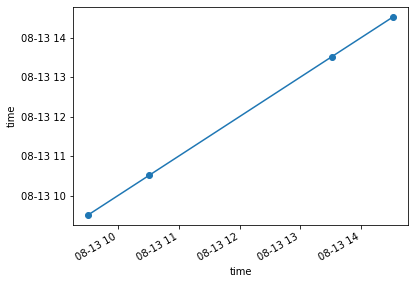

In [5]:
#confirming data is hourly-ish
bds12.time[0:4].plot(marker='o')

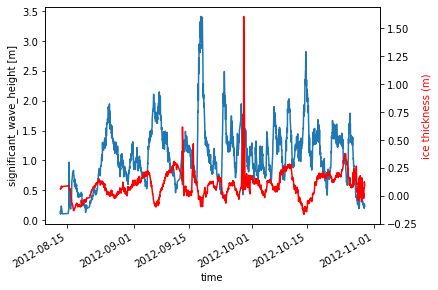

In [6]:
bds12.time.values = np.array(bds12.time.values,dtype='datetime64[h]')

fig, ax = plt.subplots(1)
bds12.sigwaveheight.plot(ax=ax); 
ax2 = ax.twinx()
bds12.icethickness.plot(ax=ax2,color='r');
ax2.set_ylabel('ice thickness (m)',color='r')
plt.show(); plt.close()

In [7]:
# from lettie's notebook, think about later
plots = [['BGEP-A_AWAC_2012-2013_converted.nc','2012-08','2012-11'], 
         ['BGEP-A_AWAC_2017-2018_converted.nc','2017-10','2017-12'],
         ['BGEP-A_AWAC_2017-2018_converted.nc','2018-07','2018-10'],
         ['BGEP-D_AWAC_2014-2015_converted.nc','2015-08','2015-10']]

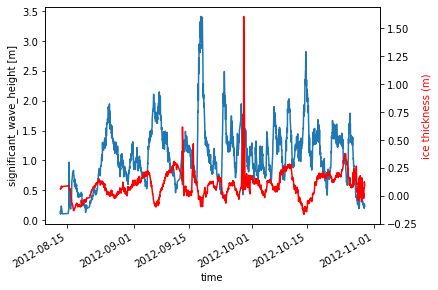

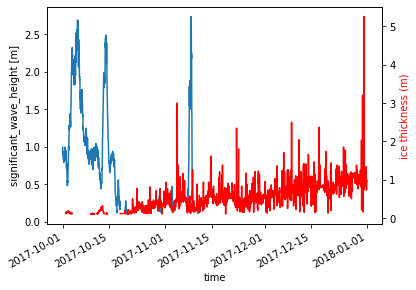

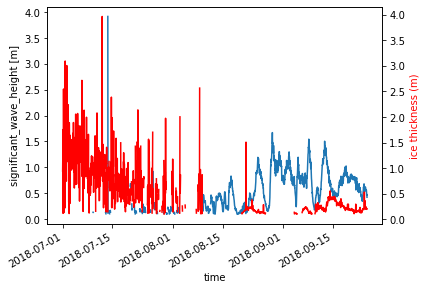

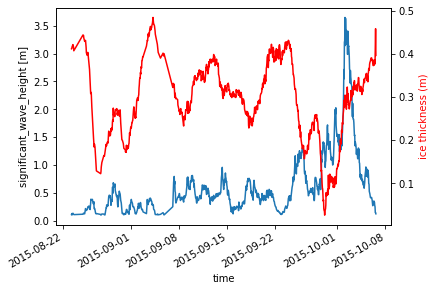

In [7]:
# from lettie's notebook, think about later
for p, plotdata in enumerate(plots):
    bds = xr.open_dataset(bdir+plotdata[0]).sel(time=slice(plotdata[1],plotdata[2]))
    # Bin so values are hourly - this truncates rather than rounds
    # So 10.31 -> 10. Think this is ok
    bds.time.values = np.array(bds.time.values,dtype='datetime64[h]') 
    
    fig, ax = plt.subplots(1)
    bds.sigwaveheight.plot(ax=ax); 
    ax2 = ax.twinx()
    bds.icethickness.plot(ax=ax2,color='r');
    ax2.set_ylabel('ice thickness (m)', color='r')
    plt.show(); plt.close()

In [8]:
# confirm lat and lon for each of the time series

print('bds12: LAT mean sd', np.mean(bds12.lat).values, np.std(bds12.lat).values)
print('bds12: LON mean sd', np.mean(bds12.lon).values, np.std(bds12.lon).values)

print('bds15: LAT mean sd', np.mean(bds15.lat).values, np.std(bds15.lat).values)
print('bds15: LON mean sd', np.mean(bds15.lon).values, np.std(bds15.lon).values)

print('bds17: LAT mean sd', np.mean(bds17.lat).values, np.std(bds17.lat).values)
print('bds17: LON mean sd', np.mean(bds17.lon).values, np.std(bds17.lon).values)

print('bds18: LAT mean sd', np.mean(bds18.lat).values, np.std(bds18.lat).values)
print('bds18: LON mean sd', np.mean(bds18.lon).values, np.std(bds18.lon).values)

bds12: LAT mean sd 75.0 0.0
bds12: LON mean sd -150.0 0.0
bds15: LAT mean sd 74.0 0.0
bds15: LON mean sd -140.0 0.0
bds17: LAT mean sd 75.0 0.0
bds17: LON mean sd -150.0 0.0
bds18: LAT mean sd 75.0 0.0
bds18: LON mean sd -150.0 0.0


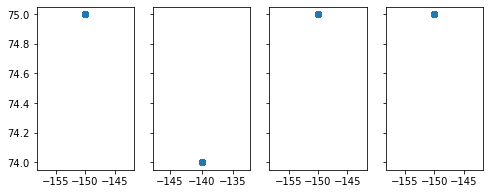

In [9]:
fig, axs = plt.subplots(1,4, figsize=(8,3),sharey=True)
axs[0].plot(bds12.lon,bds12.lat,marker='o')
axs[1].plot(bds15.lon,bds15.lat,marker='o')
axs[2].plot(bds17.lon,bds17.lat,marker='o')
axs[3].plot(bds18.lon,bds18.lat,marker='o')

## Read in Model Data with Simulated Wave Heights

In [4]:

mwds

<xarray.Dataset>
Dimensions:    (lat: 384, lon: 320, time: 24800)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 ... 2016-12-31T18:00:00
Dimensions without coordinates: lat, lon
Data variables:
    longitude  (lat, lon) float32 ...
    latitude   (lat, lon) float32 ...
    MAPSTA     (lat, lon) int16 ...
    dpt        (time, lat, lon) float32 ...
    uwnd       (time, lat, lon) float32 ...
    vwnd       (time, lat, lon) float32 ...
    ast        (time, lat, lon) float32 ...
    ice        (time, lat, lon) float32 ...
    hs         (time, lat, lon) float32 ...
    lm         (time, lat, lon) float32 ...
    t02        (time, lat, lon) float32 ...
    t0m1       (time, lat, lon) float32 ...
    t01        (time, lat, lon) float32 ...
    fp         (time, lat, lon) float32 ...
    dir        (time, lat, lon) float32 ...
    spr        (time, lat, lon) float32 ...
    dp         (time, lat, lon) float32 ...
Attributes:
    WAVEWATCH_III_version_number:  5.16
    WAVEWATCH_III_switches:        F90 NOGRB NOPA LRB4 NC4 PR3 UQ FLX0 LN1 ST...
    product_name:                  ww3.20000101.nc
    area:                          POP 1 degree grid (gx1v6b)
    latitude_resolution:           n/a
    longitude_resolution:          n/a
    southernmost_latitude:         -79.22052
    northernmost_latitude:         89.70641
    westernmost_longitude:         1.4731102E-02
    easternmost_longitude:         359.9960
    minimum_altitude:              -12000 m
    maximum_altitude:              9000 m
    altitude_resolution:           n/a
    start_date:                    2000-01-01 00:00:00
    stop_date:                     2000-01-01 18:00:00
    nco_openmp_thread_number:      1
    history:                       Tue Dec 17 13:58:02 2019: ncrename -O -d l...
    NCO:                           netCDF Operators version 4.7.9 (Homepage =...

In [5]:
mwds.latitude.values

array([[-79.22052 , -79.22052 , -79.22052 , ..., -79.22052 , -79.22052 ,
        -79.22052 ],
       [-78.68631 , -78.68631 , -78.68631 , ..., -78.68631 , -78.68631 ,
        -78.68631 ],
       [-78.15209 , -78.15209 , -78.15209 , ..., -78.15209 , -78.15209 ,
        -78.15209 ],
       ...,
       [ 71.29031 ,  71.29408 ,  71.301605, ...,  71.301605,  71.29408 ,
         71.29031 ],
       [ 71.735245,  71.738815,  71.745964, ...,  71.745964,  71.738815,
         71.735245],
       [ 72.185974,  72.18933 ,  72.19604 , ...,  72.19604 ,  72.18933 ,
         72.185974]], dtype=float32)

In [9]:
# used ncview to find longitude = 210 and latitude = 75
print(mwds.sel(lat=350,lon=206).latitude.values,mwds.sel(lat=350,lon=206).longitude.values)

75.22465 210.78157


In [11]:
# confirmed mwds data is every 6 hours
print(mwds.time[0],mwds.time[4])

<xarray.DataArray 'time' ()>
array('2000-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2000-01-01
Attributes:
    long_name:      julian day (UT)
    standard_name:  time
    conventions:    relative julian days with decimal part (as parts of the d...
    axis:           T <xarray.DataArray 'time' ()>
array('2000-01-02T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2000-01-02
Attributes:
    long_name:      julian day (UT)
    standard_name:  time
    conventions:    relative julian days with decimal part (as parts of the d...
    axis:           T


In [9]:
mwds.sel(lat=350,lon=206).latitude

<xarray.DataArray 'latitude' ()>
array(75.22465, dtype=float32)
Attributes:
    units:          degree_north
    long_name:      latitude
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      180.0
    axis:           Y

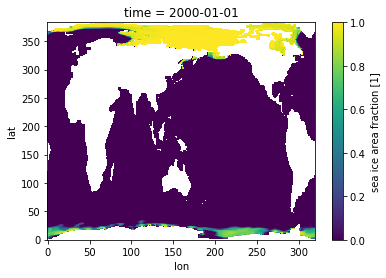

In [10]:
mwds.ice.isel(time=0).plot()

In [16]:
mwds.hs

<xarray.DataArray 'hs' (time: 24800, lat: 384, lon: 320)>
[3047424000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2016-12-31T18:00:00
Dimensions without coordinates: lat, lon
Attributes:
    long_name:      significant height of wind and swell waves
    standard_name:  sea_surface_wave_significant_height
    globwave_name:  significant_wave_height
    units:          m
    valid_min:      0
    valid_max:      32000

In [17]:
# # plot entire time series of wave height and ice fraction for model data
# fig, ax = plt.subplots(1, figsize=(20,13))

# mwds.hs.sel(lat=350,lon=206).plot(ax=ax)
# ax2 = ax.twinx()
# mwds.ice.sel(lat=350,lon=206).plot(ax=ax2,color='r')
# ax.set_ylim(0.0,1.0)
# plt.show(); plt.close()

In [18]:
# # plot entire time series of wave height for model data
# mwds.hs.sel(lat=350,lon=206).plot()

## Comparison of Model and Observations in Consistent Time Periods

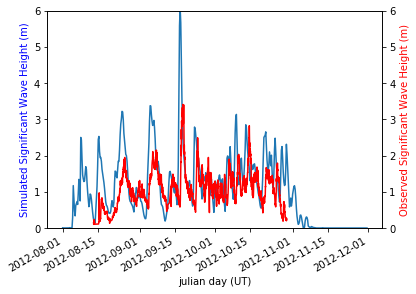

In [12]:
# comparison of Obs and Sim during the 2012 period: SigWaveHeight
fig, ax = plt.subplots(1)

mwds.hs.sel(lat=350,lon=206,time=slice(bounds[0][0],bounds[0][1])).plot(ax=ax); 
ax2 = ax.twinx()
bds12.sigwaveheight.plot(ax=ax2,color='r');
ax.set_ylabel('Simulated Significant Wave Height (m)',color='b')
ax2.set_ylabel('Observed Significant Wave Height (m)',color='r')
ax.set_ylim(0.0,6.0)
ax2.set_ylim(0.0,6.0)
plt.show(); plt.close()

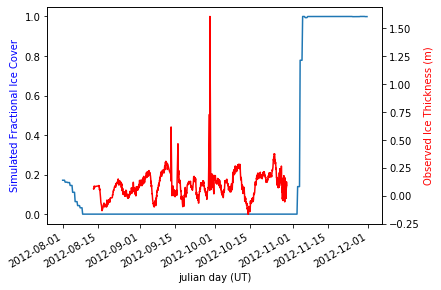

In [20]:
# comparison of Obs and Sim during the 2012 period: Ice
fig, ax = plt.subplots(1)

mwds.ice.sel(lat=350,lon=206,time=slice(bounds[0][0],bounds[0][1])).plot(ax=ax); 
ax2 = ax.twinx()
bds12.icethickness.plot(ax=ax2,color='r');
ax.set_ylabel('Simulated Fractional Ice Cover',color='b')
ax2.set_ylabel('Observed Ice Thickness (m)',color='r')
plt.show(); plt.close()

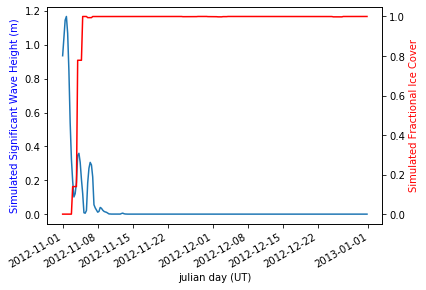

In [16]:
# Simulations during the 2012 period where ice cover develops
fig, ax = plt.subplots(1)

mwds.hs.sel(lat=350,lon=206,time=slice('2012-11-01','2012-12-31')).plot(ax=ax)
ax2 = ax.twinx()
mwds.ice.sel(lat=350,lon=206,time=slice('2012-11-01','2012-12-31')).plot(ax=ax2,color='r')
ax.set_ylabel('Simulated Significant Wave Height (m)',color='b')
ax2.set_ylabel('Simulated Fractional Ice Cover',color='r')
#ax.set_ylim(0.0,0.5)
plt.show(); plt.close()

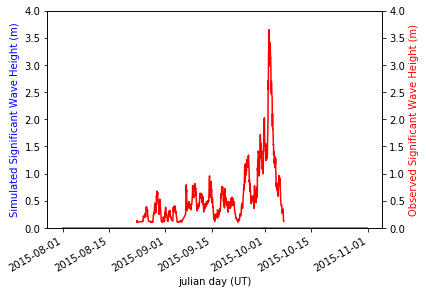

In [17]:
# comparison of Obs and Sim during the 2015 period: SigWaveHeight
# 2015 period is at 74 lat -140 lon so using different grid cell
fig, ax = plt.subplots(1)

mwds.hs.sel(lat=350,lon=214,time=slice(bounds[1][0],bounds[1][1])).plot(ax=ax); # change bounds for period
ax2 = ax.twinx()
bds15.sigwaveheight.plot(ax=ax2,color='r'); # change data set for selected period
ax.set_ylabel('Simulated Significant Wave Height (m)',color='b')
ax2.set_ylabel('Observed Significant Wave Height (m)',color='r')
ax.set_ylim(0.0,4.0)
ax2.set_ylim(0.0,4.0)
plt.show(); plt.close()

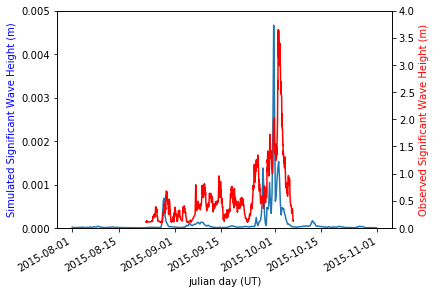

In [23]:
# REPEATED PLOT but with different Y axes

fig, ax = plt.subplots(1)

mwds.hs.sel(lat=350,lon=214,time=slice(bounds[1][0],bounds[1][1])).plot(ax=ax); # change bounds for period
ax2 = ax.twinx()
bds15.sigwaveheight.plot(ax=ax2,color='r'); # change data set for selected period
ax.set_ylabel('Simulated Significant Wave Height (m)',color='b')
ax2.set_ylabel('Observed Significant Wave Height (m)',color='r')
ax.set_ylim(0.0,0.005)
ax2.set_ylim(0.0,4.0)
plt.show(); plt.close()

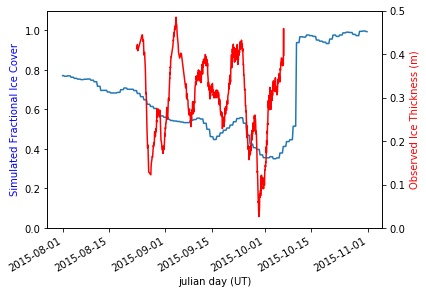

In [24]:
# comparison of Obs and Sim during the 2015 period: Ice
# 2015 period is at 74 lat -140 lon so using different grid cell
fig, ax = plt.subplots(1)

mwds.ice.sel(lat=350,lon=214,time=slice(bounds[1][0],bounds[1][1])).plot(ax=ax); #change bounds
ax2 = ax.twinx()
bds15.icethickness.plot(ax=ax2,color='r'); #change data set
ax.set_ylabel('Simulated Fractional Ice Cover',color='b')
ax2.set_ylabel('Observed Ice Thickness (m)',color='r')
ax.set_ylim(0.0,1.1)
ax2.set_ylim(0.0,0.5)
plt.show(); plt.close()

## Scratch work on daily averages

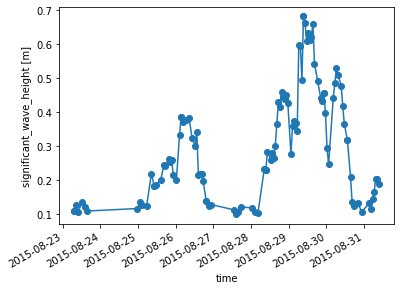

In [25]:
t = np.linspace(0,100,110).astype(int)
bds15.sigwaveheight.isel(time=t).plot(marker='o')

In [26]:
len(bds15.sigwaveheight)

844

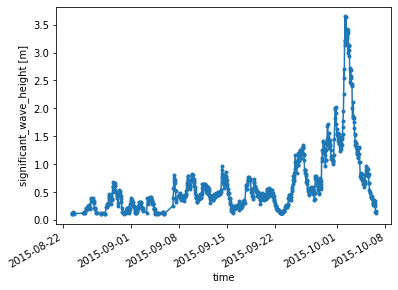

In [27]:
points = len(bds15.sigwaveheight)
t = np.linspace(0,points-1,points).astype(int)
bds15.sigwaveheight.isel(time=t).plot(marker='.')

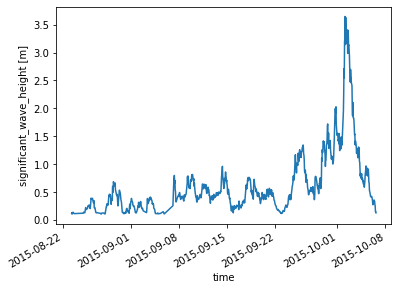

In [28]:
bds15.sigwaveheight.plot()

In [29]:
bds15

<xarray.Dataset>
Dimensions:         (freq: 42, time: 844)
Coordinates:
  * time            (time) datetime64[ns] 2015-08-23T07:31:01.999996 ... 2015-10-06T15:31:01.999999
  * freq            (freq) float64 0.009766 0.02148 0.0332 ... 0.4785 0.4902
Data variables:
    lat             (time) int64 74 74 74 74 74 74 74 ... 74 74 74 74 74 74 74
    lon             (time) int64 -140 -140 -140 -140 ... -140 -140 -140 -140
    icethickness    (time) float64 ...
    sigwaveheight   (time) float64 ...
    peakwaveperiod  (time) float64 ...
    peakwavedirT    (time) float64 ...
    energy          (time, freq) float64 ...
    a1              (time, freq) float64 ...
    b1              (time, freq) float64 ...
    a2              (time, freq) float64 ...
    b2              (time, freq) float64 ...
    check           (time, freq) float64 ...
Attributes:
    description:   AWAC
    processed by:  Jim Thomson, APL

In [12]:
#bds15.time.dt.dayofyear

In [13]:
bds15.time.dt.dayofyear[0]

<xarray.DataArray 'dayofyear' ()>
array(235)
Coordinates:
    time     datetime64[ns] 2015-08-23T07:31:01.999996

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


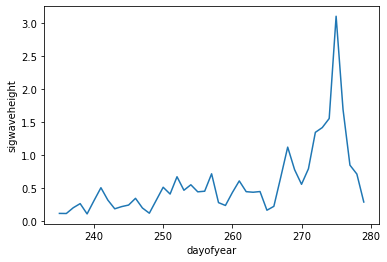

In [14]:
bds15_daily = bds15.groupby('time.dayofyear',squeeze=False).mean()
bds15_daily.sigwaveheight.plot()

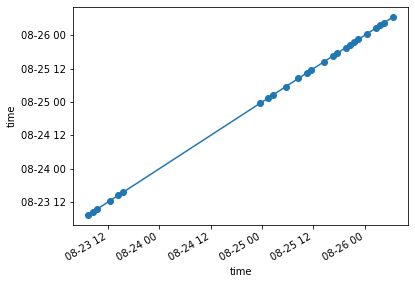

In [33]:
# create array of calendar days to replace the dayofyear -- shift by one value due to groupby convention
# temp = np.array(bds15.groupby('time.dayofyear').mean().dayofyear.values-1,dtype='datetime64[D]')
#print(bds15.groupby('time.dayofyear').mean().sigwaveheight[0])
bds15.time[0:25].plot(marker='o')

In [34]:
# create array of calendar days to replace the dayofyear -- shift by one value due to groupby convention
#temp = pd.array(bds15.groupby('time.dayofyear').mean().dayofyear.values-1,dtype='datetime64[D]')
temp = pd.array(bds15.groupby('time.dayofyear').mean().dayofyear.values-1,dtype='datetime64[D]')
#diff = 2015 - 1970
#temp[0].year # = temp[0] + np.datetime64('2015-01-01')
pd.DatetimeIndex(temp)[0]
#type(temp)
#diff = 
#pandas.tseries.temp[0] # + np.timedelta64(45,'Y')

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Timestamp('1970-08-23 00:00:00')

In [15]:
bds15_daily.assign_coords(dayofyear=np.array(bds15.groupby('time.dayofyear').mean().dayofyear.values-1,dtype='datetime64[D]'))

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:         (dayofyear: 44, freq: 42)
Coordinates:
  * freq            (freq) float64 0.009766 0.02148 0.0332 ... 0.4785 0.4902
  * dayofyear       (dayofyear) datetime64[ns] 1970-08-23 ... 1970-10-06
Data variables:
    lat             (dayofyear) float64 74.0 74.0 74.0 74.0 ... 74.0 74.0 74.0
    lon             (dayofyear) float64 -140.0 -140.0 -140.0 ... -140.0 -140.0
    icethickness    (dayofyear) float64 0.4147 0.4443 0.4047 ... 0.358 0.3908
    sigwaveheight   (dayofyear) float64 0.1184 0.1169 0.2041 ... 0.7141 0.2907
    peakwaveperiod  (dayofyear) float64 2.346 2.599 2.328 ... 5.419 4.653 3.517
    peakwavedirT    (dayofyear) float64 188.0 nan 245.4 ... 285.5 293.7 221.2
    energy          (dayofyear, freq) float64 0.0 0.0 0.0 ... 0.009886 0.01053
    a1              (dayofyear, freq) float64 0.002417 -0.0003853 ... -0.01335
    b1              (dayofyear, freq) float64 -0.0003285 -0.01759 ... -0.05979
    a2              (dayofyear, freq) float64 0.04485 0.02161 ... -0.1055
    b2              (dayofyear, freq) float64 0.0001648 -4.115e-05 ... 0.9413
    check           (dayofyear, freq) float64 2.175e+04 4.585e+03 ... 4.32 6.785

In [16]:
#pd.to_datetime(bds15_daily.dayofyear,'D')
df = pd.DataFrame({''})

## Daily average plots for mooring data

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


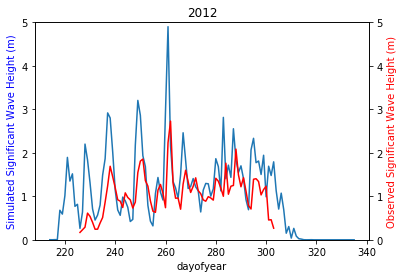

In [37]:
## 2012 daily average mooring vs simulation
fig, ax = plt.subplots(1)
mooringdata = bds12

mwds_daily = mwds.hs.sel(lat=350,lon=206,time=slice(bounds[0][0],bounds[0][1])).groupby('time.dayofyear',squeeze=False).mean()
mwds_daily.plot(ax=ax);
ax.set_ylabel('Simulated Significant Wave Height (m)',color='b')
ax2 = ax.twinx()

mooring_daily = mooringdata.groupby('time.dayofyear',squeeze=False).mean()
mooring_daily.sigwaveheight.plot(ax=ax2,color='r')
ax2.set_ylabel('Observed Significant Wave Height (m)',color='r')

plt.title('2012')
ax.set_ylim(0.0,5.0)
ax2.set_ylim(0.0,5.0)
plt.show(); plt.close()

In [38]:
# # comparison of Obs and Sim during the 2015 period: SigWaveHeight
# # 2015 period is at 74 lat -140 lon so using different grid cell
# fig, ax = plt.subplots(1)

# mwds.hs.sel(lat=350,lon=214,time=slice(bounds[1][0],bounds[1][1])).plot(ax=ax); # change bounds for period
# ax2 = ax.twinx()
# bds15_daily.sigwaveheight.plot(ax=ax2,color='r'); # change data set for selected period
# ax.set_ylabel('Simulated Significant Wave Height (m)',color='b')
# ax2.set_ylabel('Observed Significant Wave Height (m)',color='r')
# ax.set_ylim(0.0,4.0)
# ax2.set_ylim(0.0,4.0)
# plt.show(); plt.close()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


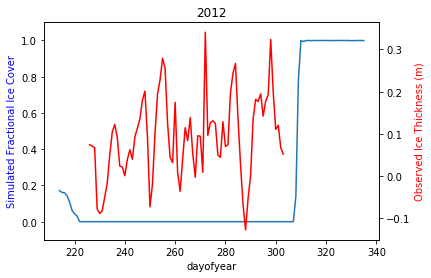

In [39]:
## 2012 daily average mooring vs simulation: ice
fig, ax = plt.subplots(1)
mooringdata = bds12

mwds_daily = mwds.ice.sel(lat=350,lon=206,time=slice(bounds[0][0],bounds[0][1])).groupby('time.dayofyear',squeeze=False).mean()
mwds_daily.plot(ax=ax);
ax.set_ylabel('Simulated Fractional Ice Cover',color='b')
ax2 = ax.twinx()

mooring_daily = mooringdata.groupby('time.dayofyear',squeeze=False).mean()
mooring_daily.icethickness.plot(ax=ax2,color='r')
ax2.set_ylabel('Observed Ice Thickness (m)',color='r')

plt.title('2012')
ax.set_ylim(-0.1,1.1)
#ax2.set_ylim(-0.,0.4)
plt.show(); plt.close()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


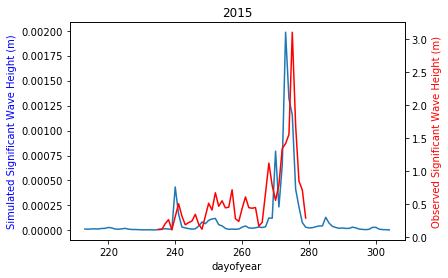

In [40]:
## 2015 daily average mooring vs simulation
fig, ax = plt.subplots(1)
mooringdata = bds15

mwds_daily = mwds.hs.sel(lat=350,lon=214,time=slice(bounds[1][0],bounds[1][1])).groupby('time.dayofyear',squeeze=False).mean()
mwds_daily.plot(ax=ax);
ax.set_ylabel('Simulated Significant Wave Height (m)',color='b')
ax2 = ax.twinx()

mooring_daily = mooringdata.groupby('time.dayofyear',squeeze=False).mean()
mooring_daily.sigwaveheight.plot(ax=ax2,color='r')
ax2.set_ylabel('Observed Significant Wave Height (m)',color='r')

plt.title('2015')
#ax.set_ylim(0.0,3.1) ## CURRENTLY SET ON DIFFERENT Y AXES -- UNCOMMENT TO CORRECT
#ax2.set_ylim(0.0,3.1)
plt.show(); plt.close()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


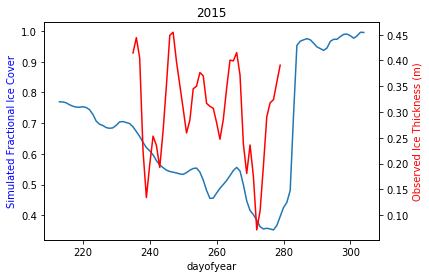

In [41]:
## 2015 daily average mooring vs simulation: ice
fig, ax = plt.subplots(1)
mooringdata = bds15

mwds_daily = mwds.ice.sel(lat=350,lon=214,time=slice(bounds[1][0],bounds[1][1])).groupby('time.dayofyear',squeeze=False).mean()
mwds_daily.plot(ax=ax);
ax.set_ylabel('Simulated Fractional Ice Cover',color='b')
ax2 = ax.twinx()

mooring_daily = mooringdata.groupby('time.dayofyear',squeeze=False).mean()
mooring_daily.icethickness.plot(ax=ax2,color='r')
ax2.set_ylabel('Observed Ice Thickness (m)',color='r')

plt.title('2015')
#ax.set_ylim(-0.1,1.1)
#ax2.set_ylim(-0.,0.4)
plt.show(); plt.close()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


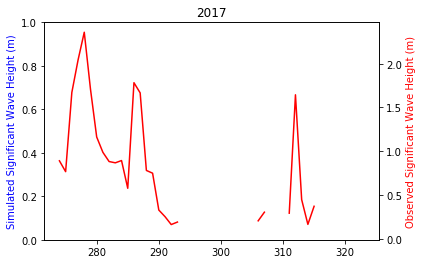

In [42]:
## 2017 daily average mooring vs simulation -- NO MODEL DATA YET
fig, ax = plt.subplots(1)
mooringdata = bds17

# mwds_daily = mwds.hs.sel(lat=350,lon=206,time=slice(bounds[0][0],bounds[0][1])).groupby('time.dayofyear',squeeze=False).mean()
# mwds_daily.plot(ax=ax);
ax.set_ylabel('Simulated Significant Wave Height (m)',color='b')
ax2 = ax.twinx()

mooring_daily = mooringdata.groupby('time.dayofyear',squeeze=False).mean()
mooring_daily.sigwaveheight.plot(ax=ax2,color='r')
ax2.set_ylabel('Observed Significant Wave Height (m)',color='r')

plt.title('2017')
#ax.set_ylim(0.0,5.0)
#ax2.set_ylim(0.0,5.0)
plt.show(); plt.close()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


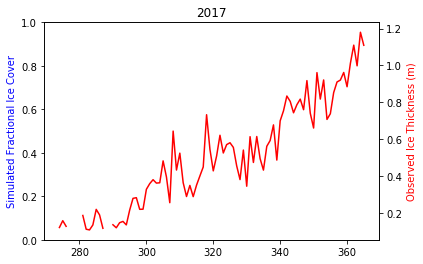

In [43]:
## 2017 daily average mooring vs simulation: ice -- NO MODEL DATA YET
fig, ax = plt.subplots(1)
mooringdata = bds17

#mwds_daily = mwds.ice.sel(lat=350,lon=206,time=slice(bounds[1][0],bounds[1][1])).groupby('time.dayofyear',squeeze=False).mean()
#mwds_daily.plot(ax=ax);
ax.set_ylabel('Simulated Fractional Ice Cover',color='b')
ax2 = ax.twinx()

mooring_daily = mooringdata.groupby('time.dayofyear',squeeze=False).mean()
mooring_daily.icethickness.plot(ax=ax2,color='r')
ax2.set_ylabel('Observed Ice Thickness (m)',color='r')

plt.title('2017')
#ax.set_ylim(-0.1,1.1)
#ax2.set_ylim(-0.,0.4)
plt.show(); plt.close()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


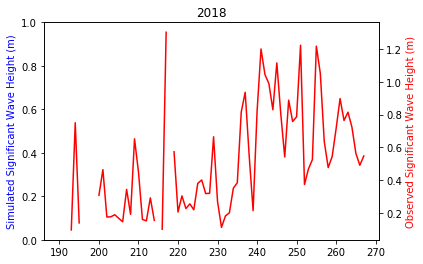

In [44]:
## 2018 daily average mooring vs simulation -- NO MODEL DATA YET
fig, ax = plt.subplots(1)
mooringdata = bds18

# mwds_daily = mwds.hs.sel(lat=350,lon=206,time=slice(bounds[0][0],bounds[0][1])).groupby('time.dayofyear',squeeze=False).mean()
# mwds_daily.plot(ax=ax);
ax.set_ylabel('Simulated Significant Wave Height (m)',color='b')
ax2 = ax.twinx()

mooring_daily = mooringdata.groupby('time.dayofyear',squeeze=False).mean()
mooring_daily.sigwaveheight.plot(ax=ax2,color='r')
ax2.set_ylabel('Observed Significant Wave Height (m)',color='r')

plt.title('2018')
#ax.set_ylim(0.0,5.0)
#ax2.set_ylim(0.0,5.0)
plt.show(); plt.close()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


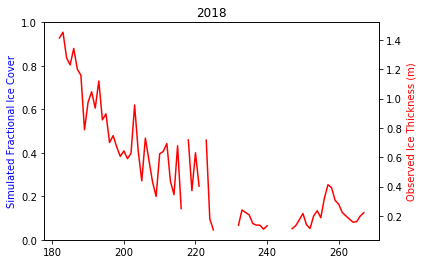

In [45]:
## 2017 daily average mooring vs simulation: ice -- NO MODEL DATA YET
fig, ax = plt.subplots(1)
mooringdata = bds18

#mwds_daily = mwds.ice.sel(lat=350,lon=206,time=slice(bounds[1][0],bounds[1][1])).groupby('time.dayofyear',squeeze=False).mean()
#mwds_daily.plot(ax=ax);
ax.set_ylabel('Simulated Fractional Ice Cover',color='b')
ax2 = ax.twinx()

mooring_daily = mooringdata.groupby('time.dayofyear',squeeze=False).mean()
mooring_daily.icethickness.plot(ax=ax2,color='r')
ax2.set_ylabel('Observed Ice Thickness (m)',color='r')

plt.title('2018')
#ax.set_ylim(-0.1,1.1)
#ax2.set_ylim(-0.,0.4)
plt.show(); plt.close()

## Assess how ice cover and wave height vary with latitude

In [18]:
## find bounds of 2015 data set
bds15.time

<xarray.DataArray 'time' (time: 844)>
array(['2015-08-23T07:31:01.999996000', '2015-08-23T08:31:02.000002000',
       '2015-08-23T09:31:01.999999000', ..., '2015-10-06T13:31:01.999996000',
       '2015-10-06T14:31:02.000002000', '2015-10-06T15:31:01.999999000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-08-23T07:31:01.999996 ... 2015-10-06T15:31:01.999999

ValueError: cannot reduce over dimensions ['lat']. expected either '...' to reduce over all dimensions or one or more of ('time', 'lon').

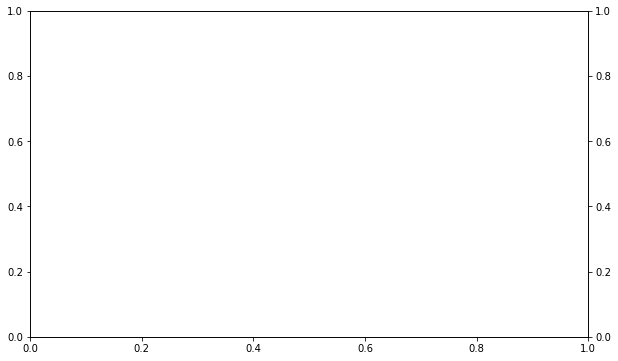

In [19]:
## Plot ice cover and wave heights from equator to pole

fig, ax = plt.subplots(1, figsize=(10,6))
ax2 = ax.twinx()
date='2015-09-20' # temporary selection of single day -- time slice TBD

mwds.sel(time=date,lat=slice(280,383))
mwds.hs.sel(time=date,lat=slice(280,383)).groupby('lat').mean().plot(ax=ax,c='r')
mwds.ice.sel(time=date,lat=slice(280,383)).groupby('lat').mean().plot(ax=ax2,c='b')
plt.plot(350-280,0,marker='o') # mooring latitude

ax.set_xlabel('Latitude: equator (0) to north pole (103)')
ax.set_ylabel('Significant Wave Height (m)', color='r')
ax2.set_ylabel('Ice Fraction', color='b')
plt.title(date)
plt.show(); plt.close()


# mwds.sel(time=date).groupby('latitude').mean().hs.plot()

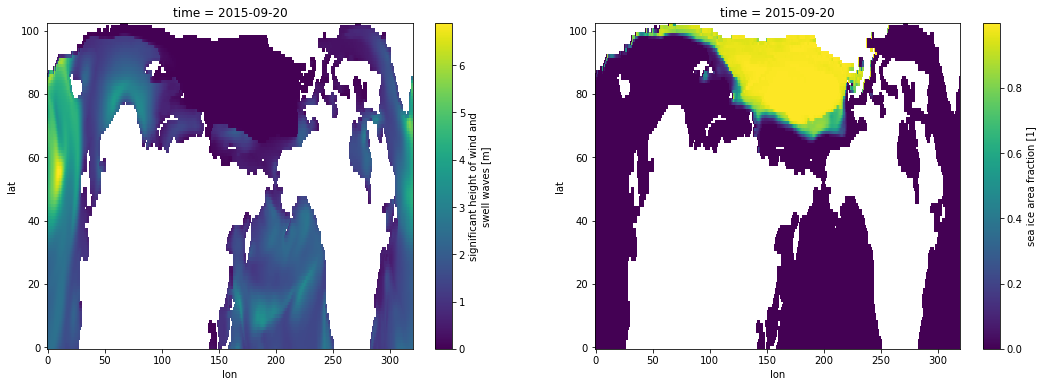

In [20]:
# testing out selecting data and comparing wave height with ice cover
fig, ax = plt.subplots(1,2,figsize=(18,6))
mwds.sel(time=date,lat=slice(280,383)).isel(time=0).hs.plot(ax=ax[0])
mwds.sel(time=date,lat=slice(280,383)).isel(time=0).ice.plot(ax=ax[1])

In [21]:
hs_lat = mwds.sel(time=date,lat=slice(280,383)).isel(time=0).groupby('latitude').mean().hs

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [50]:
ice_lat = mwds.sel(time=date,lat=slice(280,383)).isel(time=0).groupby('latitude').mean().ice

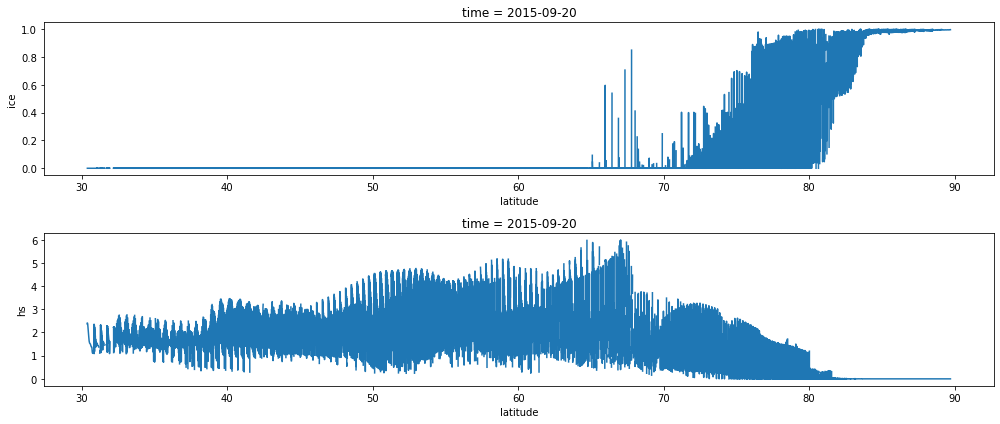

In [51]:
fig, ax = plt.subplots(2,1,figsize=(14,6))
ice_lat.plot(ax=ax[0]) # ice cover by latitude
hs_lat.plot(ax=ax[1]) # sig wave height by latitude
plt.tight_layout()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


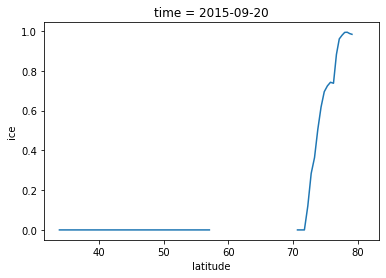

In [52]:
ice_lat_lon214 = mwds.sel(time='2015-09-20',lat=slice(280,383),lon=214).isel(time=0).groupby('latitude').mean().ice
ice_lat_lon214.plot()

ValueError: cannot reduce over dimensions ['lat']. expected either '...' to reduce over all dimensions or one or more of ('time', 'lon').

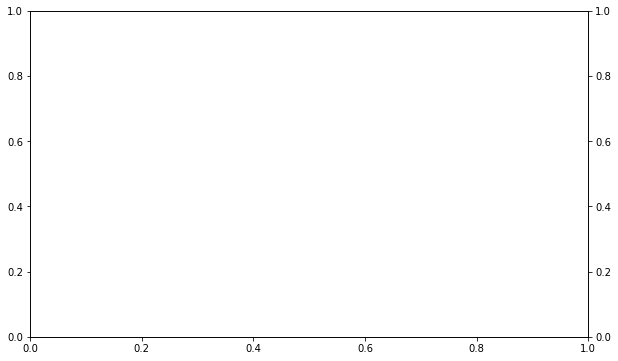

In [53]:
## Plot ice cover and wave heights from equator to pole

fig, ax = plt.subplots(1, figsize=(10,6))
ax2 = ax.twinx()
date='2015-09-20' # temporary selection of single day -- time slice TBD

mwds.hs.sel(time=date,lat=slice(280,383)).groupby('lat').mean().plot(ax=ax,c='r')
mwds.ice.sel(time=date,lat=slice(280,383)).groupby('lat').mean().plot(ax=ax2,c='b')
plt.plot(350-280,0,marker='o') # mooring latitude

ax.set_xlabel('Latitude: equator (0) to north pole (103)')
ax.set_ylabel('Significant Wave Height (m)', color='r')
ax2.set_ylabel('Ice Fraction', color='b')
plt.title(date)
plt.show(); plt.close()

In [22]:
## plot ice cover along a longitude line
mwds.ice.sel(time='2015-10-05',lon=214).groupby('lat').mean().plot()

ValueError: cannot reduce over dimensions ['lat']. expected either '...' to reduce over all dimensions or one or more of ('time',).

## Regrid satellite observations and compare with simulation (separate from moorings)

In [6]:
# Get observations from NSIDC bootstrap, regridded to match CICE grid
path = '/glade/work/vcooper/BGEP_vtc/regrid_sat/' ## location of regridded file
ice_file = 'seaice_conc_daily_nh_1979-2018_cicegrid.nc' # name of regridded file

boot = xr.open_dataset(path+ice_file)
boot

<xarray.Dataset>
Dimensions:                         (ni: 320, nj: 384, time: 13012)
Coordinates:
  * time                            (time) datetime64[ns] 1979-01-02 ... 2018-12-31
    TLON                            (nj, ni) float32 ...
    TLAT                            (nj, ni) float32 ...
Dimensions without coordinates: ni, nj
Data variables:
    seaice_conc_cdr                 (time, nj, ni) float32 ...
    stdev_of_seaice_conc_cdr        (time, nj, ni) float32 ...
    melt_onset_day_seaice_conc_cdr  (time, nj, ni) float32 ...
    qa_of_seaice_conc_cdr           (time, nj, ni) float32 ...
    goddard_merged_seaice_conc      (time, nj, ni) float32 ...
    goddard_nt_seaice_conc          (time, nj, ni) float32 ...
    goddard_bt_seaice_conc          (time, nj, ni) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    history:                   Tue Jan 21 12:40:16 2020: cdo remapbil,o.nc se...
    source:                    ftp://sidads.colorado.edu/DATASETS/nsidc0051_g...
    institution:               NSIDC > National Snow and Ice Data Center
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    program:                   NOAA Climate Data Record Program
    cdr_variable:              seaice_conc_cdr
    software_version_id:       git@bitbucket.org:nsidc/seaice_cdr.git@a4589e0...
    Metadata_Link:             http://nsidc.org/api/metadata?id=g02202
    product_version:           v03r01
    spatial_resolution:        25km
    standard_name_vocabulary:  CF Standard Name Table (v16, 11 October 2010)
    id:                        G02202
    naming_authority:          nsidc.org
    license:                   No constraints on data access or use
    summary:                   This data set provides a passive microwave sea...
    keywords:                  EARTH SCIENCE > CRYOSPHERE > SEA ICE > SEA ICE...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Key...
    cdm_data_type:             Grid
    project:                   NOAA/NSIDC passive microwave sea ice concentra...
    creator_url:               http://nsidc.org/
    creator_email:             nsidc@nsidc.org
    processing_level:          NOAA Level 3
    geospatial_lat_min:        31.35
    geospatial_lat_max:        90.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lon_units:      degrees_east
    time_coverage_duration:    P1D
    time_coverage_resolution:  P1D
    contributor_name:          Walt Meier, Ruth Duerr, Florence Fetterer, Jul...
    contributor_role:          PrincipalInvestigator,author,author,author,aut...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2017-11-18T06:25:29Z
    time_coverage_start:       1979-01-02T00:00:00Z
    time_coverage_end:         1979-01-02T23:59:59Z
    comment:                   The variables seaice_conc_cdr, stdev_of_seaice...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...

In [7]:
# rename bootstrap dimensions to match the model dims
rename = {'ni':'lon','nj':'lat'}
print(rename)
print(boot.dims)
print(rename.keys)
boot = boot.rename_dims(rename)

{'ni': 'lon', 'nj': 'lat'}
Frozen(SortedKeysDict({'time': 13012, 'nj': 384, 'ni': 320}))
<built-in method keys of dict object at 0x2b0346eee5a0>


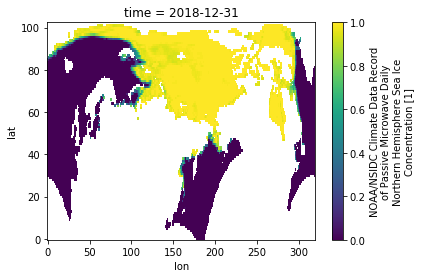

In [8]:
boot.seaice_conc_cdr[-1,280:383,:].plot()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


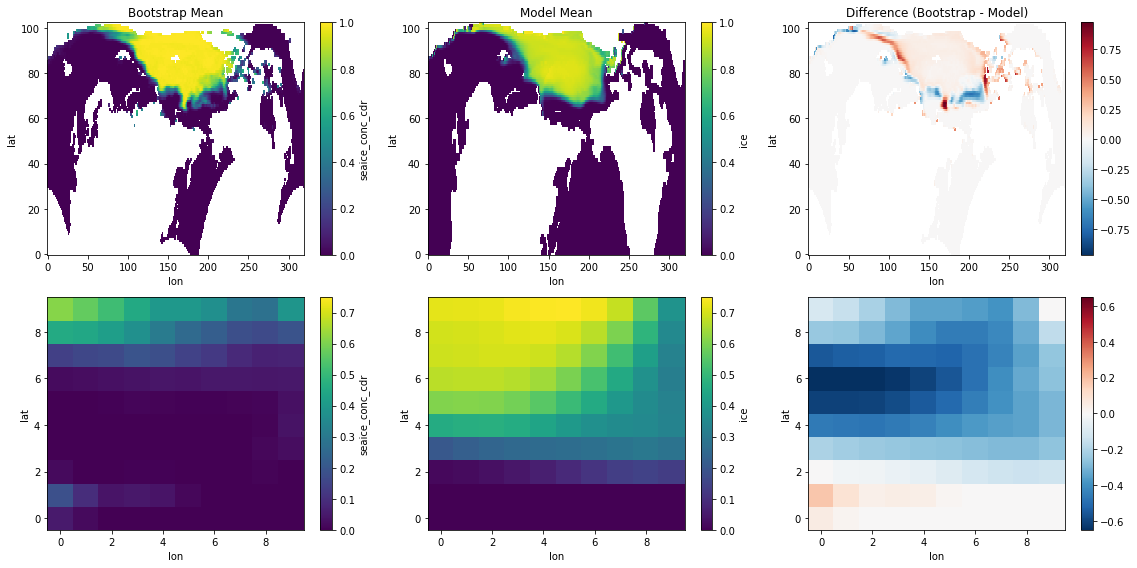

In [14]:
# plot ice cover mean of observations and model during mooring period
## 2015 08-10
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(16,8))

dates = slice('2015-08-23','2015-10-06')

# ROW 1 -- Northern Hemi
left = boot.seaice_conc_cdr[:,280:383,:].sel(time=dates).mean(dim='time')
left.plot(ax=ax[0][0],vmin=0,vmax=1)
ax[0][0].set_title('Bootstrap Mean')

right = mwds.ice[:,280:383,:].sel(time=dates).mean(dim='time')
right.plot(ax=ax[0][1],vmin=0,vmax=1)
ax[0][1].set_title('Model Mean')

diff = left - right
diff.plot(ax=ax[0][2])
ax[0][2].set_title('Difference (Bootstrap - Model)')

# ROW 2 -- local around mooring
left = boot.seaice_conc_cdr[:,345:355,209:219].sel(time=dates).mean(dim='time')
left.plot(ax=ax[1][0],vmin=0,vmax=0.75)


right = mwds.ice[:,345:355,209:219].sel(time=dates).mean(dim='time')
right.plot(ax=ax[1][1],vmin=0,vmax=0.75)

diff = left - right
diff.plot(ax=ax[1][2])

plt.tight_layout()

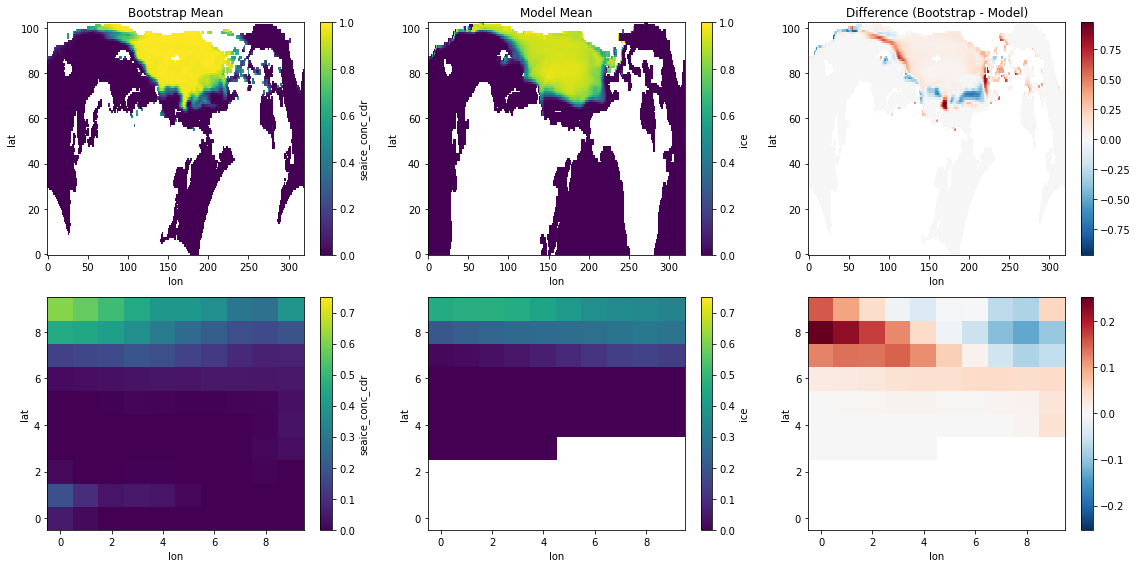

In [15]:
# Finding model grid cell that replicates ice cover
## 2015 08-10
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(16,8))

dates = slice('2015-08-23','2015-10-06')

# ROW 1 -- Northern Hemi
left = boot.seaice_conc_cdr[:,280:383,:].sel(time=dates).mean(dim='time')
left.plot(ax=ax[0][0],vmin=0,vmax=1)
ax[0][0].set_title('Bootstrap Mean')

right = mwds.ice[:,280:383,:].sel(time=dates).mean(dim='time')
right.plot(ax=ax[0][1],vmin=0,vmax=1)
ax[0][1].set_title('Model Mean')

diff = left - right
diff.plot(ax=ax[0][2])
ax[0][2].set_title('Difference (Bootstrap - Model)')

# ROW 2 -- local around mooring
left = boot.seaice_conc_cdr[:,345:355,209:219].sel(time=dates).mean(dim='time')
left.plot(ax=ax[1][0],vmin=0,vmax=0.75)


right = mwds.ice[:,340:350,209:219].sel(time=dates).mean(dim='time') # shifted lower
right.plot(ax=ax[1][1],vmin=0,vmax=0.75)

diff = left - right
diff.plot(ax=ax[1][2])

plt.tight_layout()

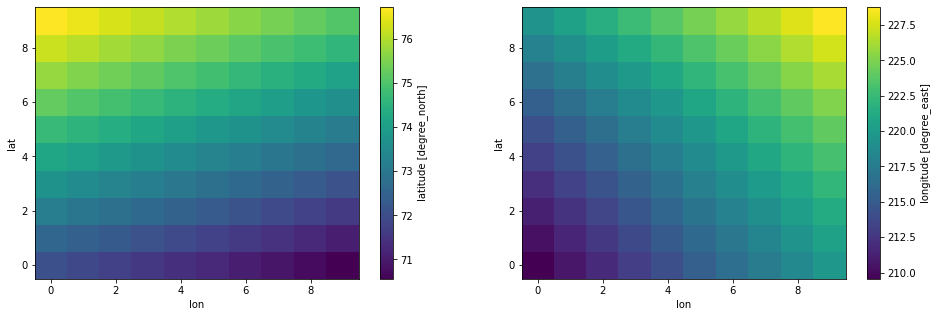

In [28]:
# making sure i have correct grid area for 2015
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
mwds.latitude[345:355,209:219].plot(ax=ax[0])
mwds.longitude[345:355,209:219].plot(ax=ax[1])

In [29]:
print(mwds.latitude[350,214],mwds.longitude[350,214])

<xarray.DataArray 'latitude' ()>
array(73.84869, dtype=float32)
Attributes:
    units:          degree_north
    long_name:      latitude
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      180.0
    axis:           Y <xarray.DataArray 'longitude' ()>
array(219.82047, dtype=float32)
Attributes:
    units:          degree_east
    long_name:      longitude
    standard_name:  longitude
    valid_min:      -180.0
    valid_max:      360.0
    axis:           X


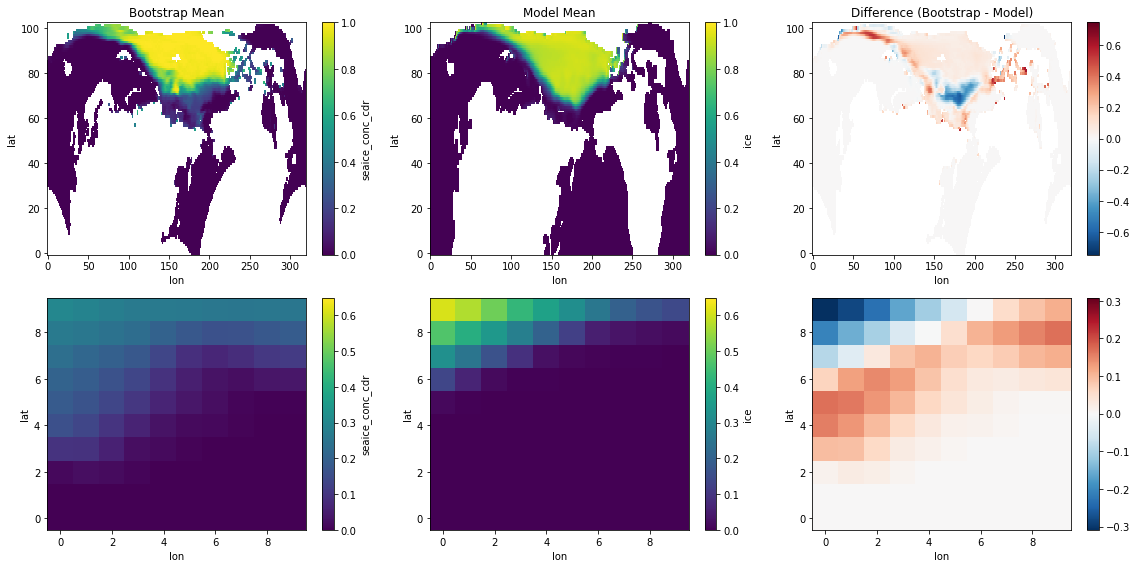

In [30]:
# plot ice cover mean of observations and model during mooring period
## 2012 08-10
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(16,8))

dates = slice('2012-08-13','2012-10-29')

# ROW 1 -- Northern Hemi
left = boot.seaice_conc_cdr[:,280:383,:].sel(time=dates).mean(dim='time')
left.plot(ax=ax[0][0],vmin=0,vmax=1)
ax[0][0].set_title('Bootstrap Mean')

right = mwds.ice[:,280:383,:].sel(time=dates).mean(dim='time')
right.plot(ax=ax[0][1],vmin=0,vmax=1)
ax[0][1].set_title('Model Mean')

diff = left - right
diff.plot(ax=ax[0][2])
ax[0][2].set_title('Difference (Bootstrap - Model)')

# ROW 2 -- local around mooring
left = boot.seaice_conc_cdr[:,345:355,201:211].sel(time=dates).mean(dim='time')
left.plot(ax=ax[1][0],vmin=0,vmax=0.65)

right = mwds.ice[:,345:355,201:211].sel(time=dates).mean(dim='time')
right.plot(ax=ax[1][1],vmin=0,vmax=0.65)

diff = left - right
diff.plot(ax=ax[1][2])

plt.tight_layout()

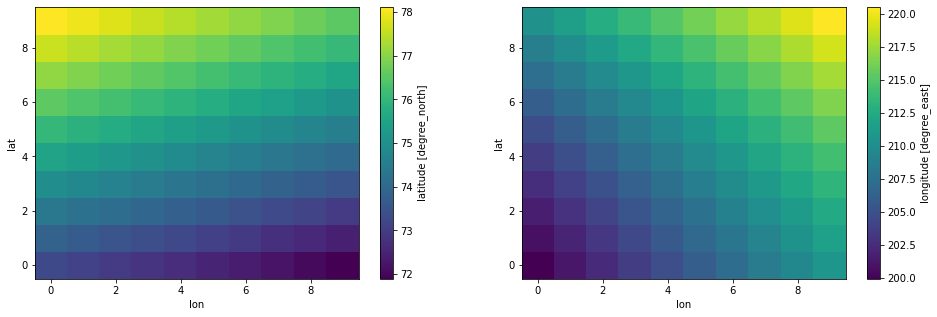

In [31]:
# making sure i have correct grid area for 2012
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
mwds.latitude[345:355,201:211].plot(ax=ax[0])
mwds.longitude[345:355,201:211].plot(ax=ax[1])

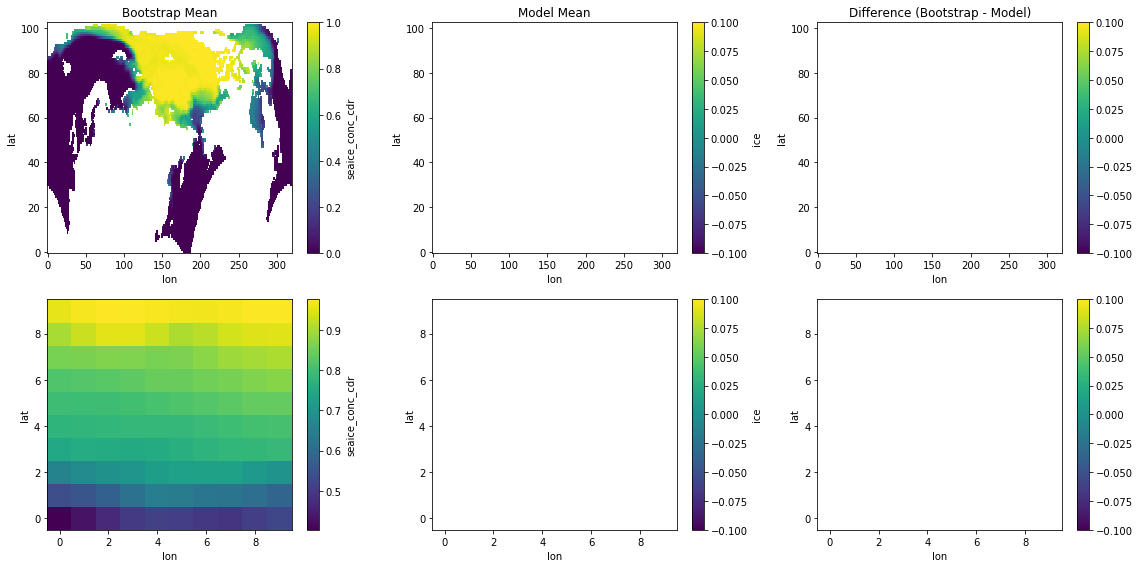

In [32]:
# plot ice cover mean of observations and model during mooring period
## 2017 10-12
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(16,8))

dates = slice('2017-10-01','2017-12-31')

# ROW 1 -- Northern Hemi
left = boot.seaice_conc_cdr[:,280:383,:].sel(time=dates).mean(dim='time')
left.plot(ax=ax[0][0])
ax[0][0].set_title('Bootstrap Mean')

right = mwds.ice[:,280:383,:].sel(time=dates).mean(dim='time')
right.plot(ax=ax[0][1])
ax[0][1].set_title('Model Mean')

diff = left - right
diff.plot(ax=ax[0][2])
ax[0][2].set_title('Difference (Bootstrap - Model)')

# ROW 2 -- local around mooring
left = boot.seaice_conc_cdr[:,345:355,201:211].sel(time=dates).mean(dim='time')
left.plot(ax=ax[1][0])

right = mwds.ice[:,345:355,201:211].sel(time=dates).mean(dim='time')
right.plot(ax=ax[1][1])

diff = left - right
diff.plot(ax=ax[1][2])

plt.tight_layout()

In [33]:
bds18

<xarray.Dataset>
Dimensions:         (freq: 42, time: 2058)
Coordinates:
  * time            (time) datetime64[ns] 2018-07-01T00:31:01.000004 ... 2018-09-24T17:31:00.999998
  * freq            (freq) float64 0.009766 0.02148 0.0332 ... 0.4785 0.4902
Data variables:
    lat             (time) int64 75 75 75 75 75 75 75 ... 75 75 75 75 75 75 75
    lon             (time) int64 -150 -150 -150 -150 ... -150 -150 -150 -150
    icethickness    (time) float64 ...
    sigwaveheight   (time) float64 ...
    peakwaveperiod  (time) float64 ...
    peakwavedirT    (time) float64 ...
    energy          (time, freq) float64 ...
    a1              (time, freq) float64 ...
    b1              (time, freq) float64 ...
    a2              (time, freq) float64 ...
    b2              (time, freq) float64 ...
    check           (time, freq) float64 ...
Attributes:
    description:   AWAC
    processed by:  Jim Thomson, APL

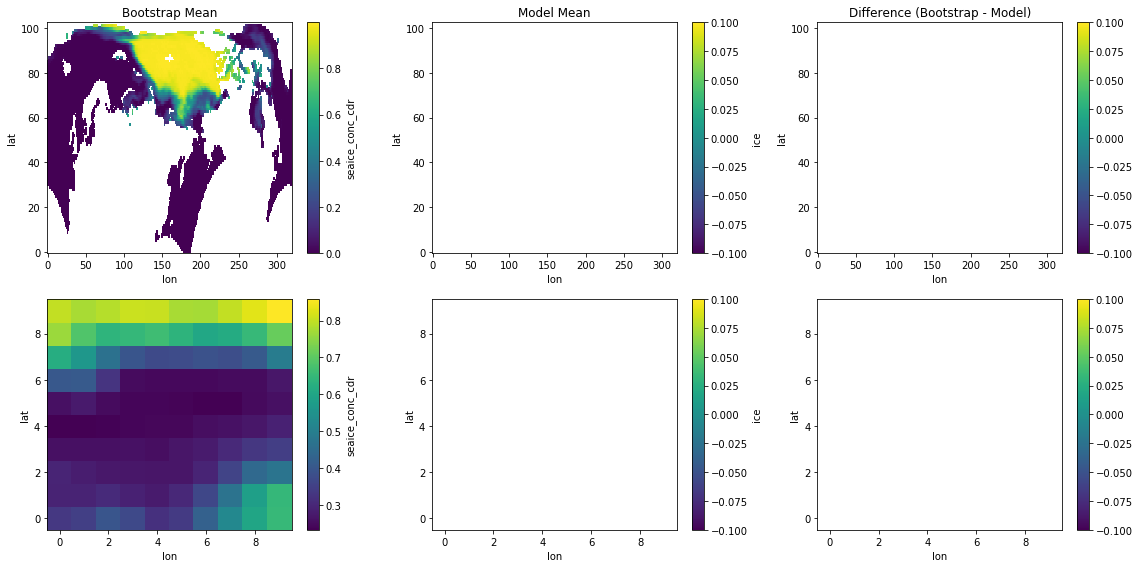

In [66]:
# plot ice cover mean of observations and model during mooring period
## 2018 07-09
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(16,8))

dates = slice('2018-07-01','2018-09-24')

# ROW 1 -- Northern Hemi
left = boot.seaice_conc_cdr[:,280:383,:].sel(time=dates).mean(dim='time')
left.plot(ax=ax[0][0])
ax[0][0].set_title('Bootstrap Mean')

right = mwds.ice[:,280:383,:].sel(time=dates).mean(dim='time')
right.plot(ax=ax[0][1])
ax[0][1].set_title('Model Mean')

diff = left - right
diff.plot(ax=ax[0][2])
ax[0][2].set_title('Difference (Bootstrap - Model)')

# ROW 2 -- local around mooring
left = boot.seaice_conc_cdr[:,345:355,201:211].sel(time=dates).mean(dim='time')
left.plot(ax=ax[1][0])

right = mwds.ice[:,345:355,201:211].sel(time=dates).mean(dim='time')
right.plot(ax=ax[1][1])

diff = left - right
diff.plot(ax=ax[1][2])

plt.tight_layout()

In [67]:
# plot model grid cell ice data vs bootstrap

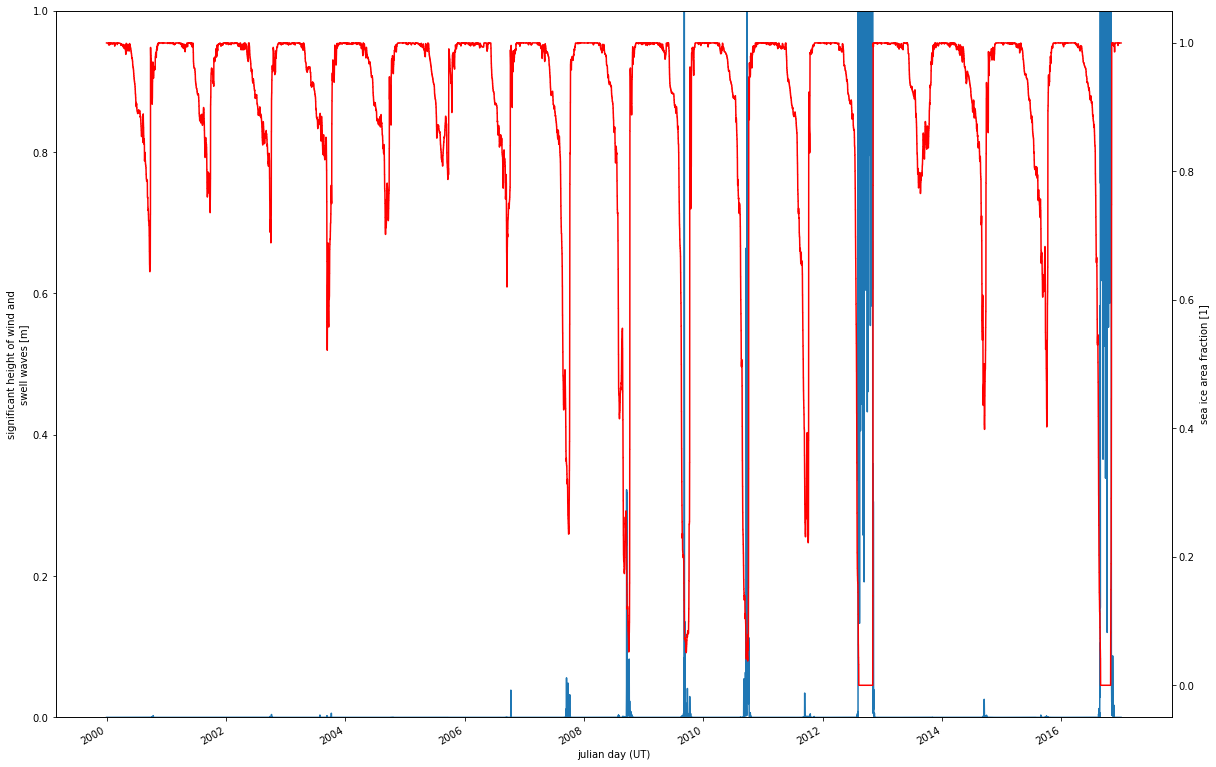

In [68]:
# plot entire time series of wave height and ice fraction for model data
# fig, ax = plt.subplots(1, figsize=(20,13))

# mwds.hs.sel(lat=350,lon=206).plot(ax=ax)
# ax2 = ax.twinx()
# mwds.ice.sel(lat=350,lon=206).plot(ax=ax2,color='r')
# ax.set_ylim(0.0,1.0)
# plt.show(); plt.close()

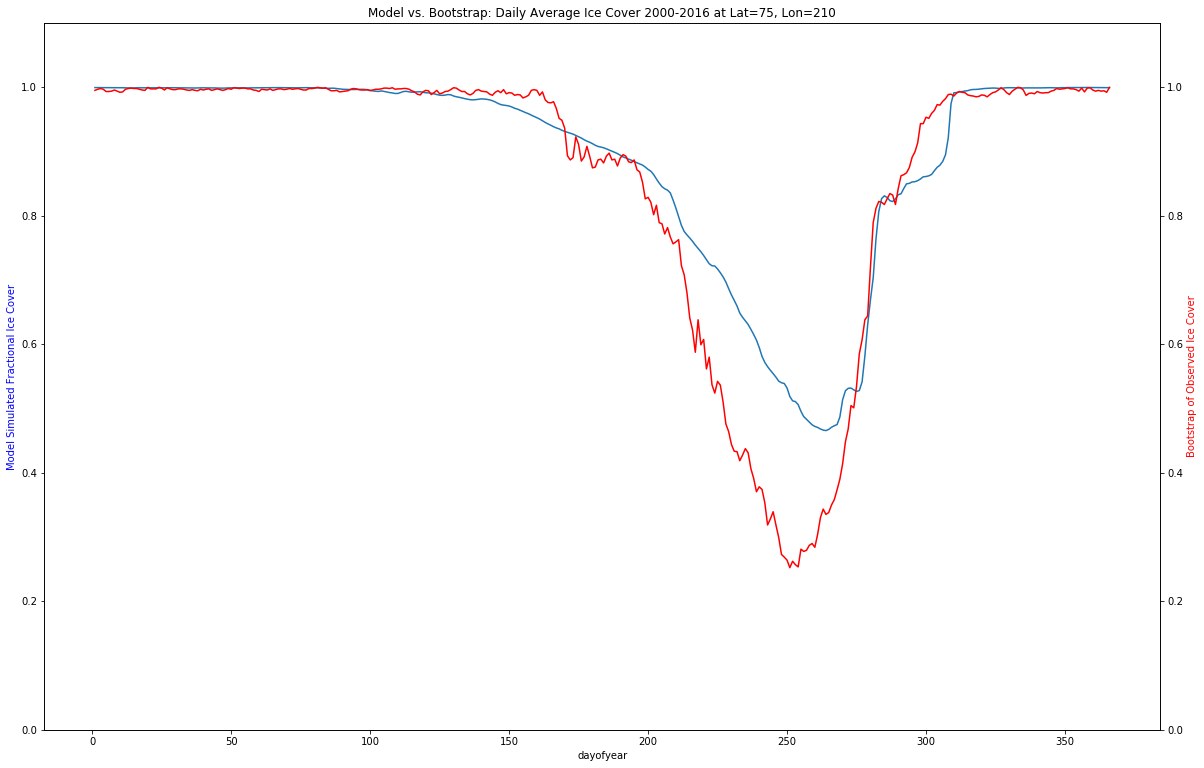

In [69]:
# ## daily average mooring vs simulation: ice cover
# fig, ax = plt.subplots(1, figsize=(20,13))

# mwds_daily = mwds.ice.sel(lat=350,lon=206).groupby('time.dayofyear',squeeze=False).mean()
# mwds_daily.plot(ax=ax);
# ax.set_ylabel('Model Simulated Fractional Ice Cover',color='b')
# ax2 = ax.twinx()

# boot_daily = boot.seaice_conc_cdr.sel(lat=350,lon=206,time=slice('2000','2016')).groupby('time.dayofyear',squeeze=False).mean()
# boot_daily.plot(ax=ax2,color='r')
# ax2.set_ylabel('Bootstrap of Observed Ice Cover',color='r')

# plt.title('Model vs. Bootstrap: Daily Average Ice Cover 2000-2016 at Lat=75, Lon=210')
# ax.set_ylim(0,1.1)
# ax2.set_ylim(0,1.1)
# plt.show(); plt.close()

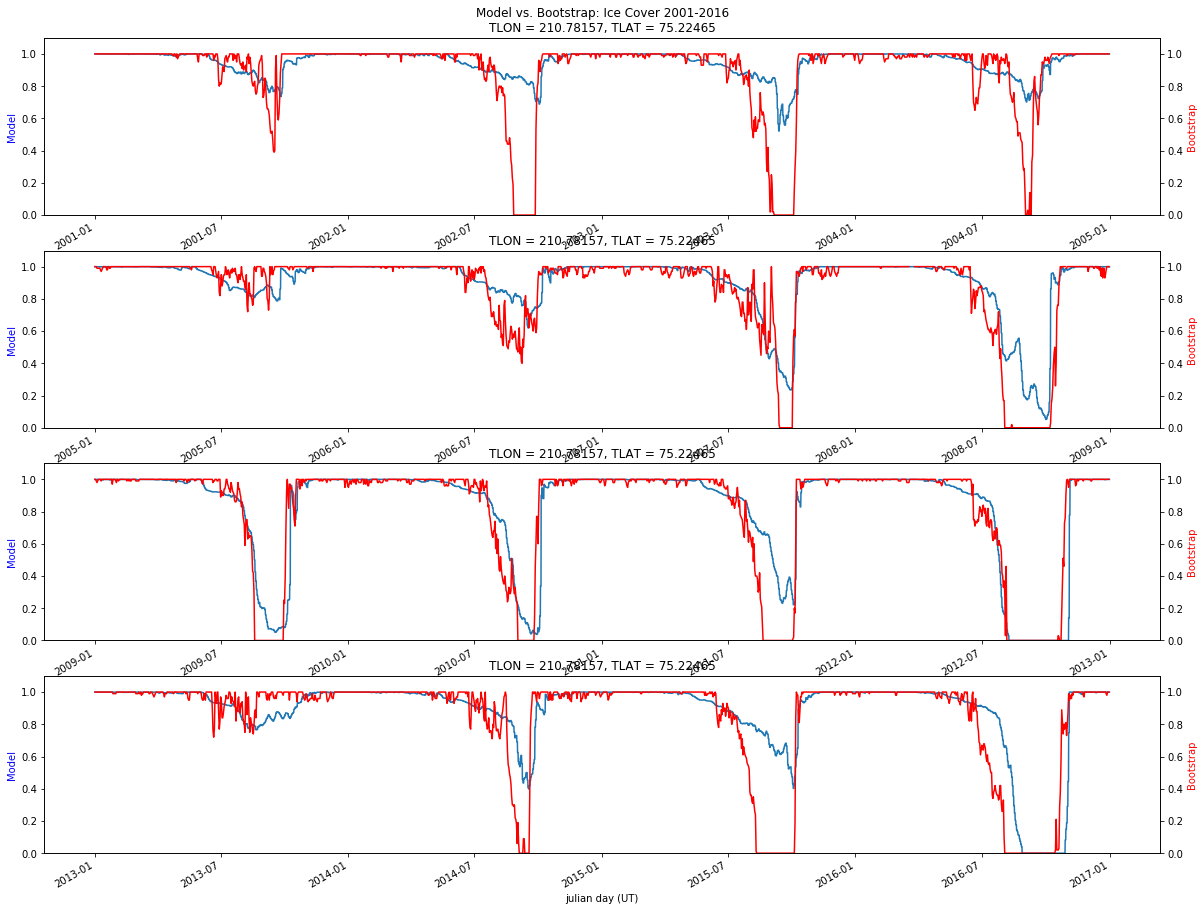

<Figure size 432x288 with 0 Axes>

In [70]:
## mooring vs simulation: ice cover -- split across time for more detailed view
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,15))

# first four years
mwds_daily = mwds.ice.sel(lat=350,lon=206,time=slice('2001','2004'))
mwds_daily.plot(ax=ax[0])
ax[0].set_ylabel('Model',color='b')
ax_2a = ax[0].twinx()

boot_daily = boot.seaice_conc_cdr.sel(lat=350,lon=206,time=slice('2001','2004'))
boot_daily.plot(ax=ax_2a,color='r')
ax_2a.set_ylabel('Bootstrap',color='r')

# 2nd four years
mwds_daily = mwds.ice.sel(lat=350,lon=206,time=slice('2005','2008'))
mwds_daily.plot(ax=ax[1])
ax[1].set_ylabel('Model',color='b')
ax_2b = ax[1].twinx()

boot_daily = boot.seaice_conc_cdr.sel(lat=350,lon=206,time=slice('2005','2008'))
boot_daily.plot(ax=ax_2b,color='r')
ax_2b.set_ylabel('Bootstrap',color='r')

# 3rd four years
mwds_daily = mwds.ice.sel(lat=350,lon=206,time=slice('2009','2012'))
mwds_daily.plot(ax=ax[2])
ax[2].set_ylabel('Model',color='b')
ax_2c = ax[2].twinx()

boot_daily = boot.seaice_conc_cdr.sel(lat=350,lon=206,time=slice('2009','2012'))
boot_daily.plot(ax=ax_2c,color='r')
ax_2c.set_ylabel('Bootstrap',color='r')

# 4th four years
mwds_daily = mwds.ice.sel(lat=350,lon=206,time=slice('2013','2016'))
mwds_daily.plot(ax=ax[3])
ax[3].set_ylabel('Model',color='b')
ax_2d = ax[3].twinx()

boot_daily = boot.seaice_conc_cdr.sel(lat=350,lon=206,time=slice('2013','2016'))
boot_daily.plot(ax=ax_2d,color='r')
ax_2d.set_ylabel('Bootstrap',color='r')

ax[0].set_title('Model vs. Bootstrap: Ice Cover 2001-2016\n')

for i in range(0,len(ax)):
    ax[i].set_ylim(0,1.1)

ax_2a.set_ylim(0,1.1)
ax_2b.set_ylim(0,1.1)
ax_2c.set_ylim(0,1.1)
ax_2d.set_ylim(0,1.1)
plt.show(); plt.tight_layout()

In [21]:
#boot.seaice_conc_cdr.sel(lat=350,lon=206,time=slice('2000','2016')).groupby('time.dayofyear',squeeze=False).mean()

## Create plot of ice cover, wave heights, and locations

In [34]:
mwds.ice[:,345:355,201:211]

<xarray.DataArray 'ice' (time: 24800, lat: 10, lon: 10)>
[2480000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2016-12-31T18:00:00
Dimensions without coordinates: lat, lon
Attributes:
    long_name:      sea ice area fraction
    standard_name:  sea_ice_area_fraction
    globwave_name:  sea_ice_area_fraction
    units:          1
    valid_min:      0
    valid_max:      1000

In [35]:
#mwds.latitude[345:355,201:211]

In [36]:
# 
print(mwds.latitude[350,214].values, mwds.longitude[350,214].values)
print(mwds.latitude[350,205].values, mwds.longitude[350,205].values)

73.84869 219.82047
75.38975 209.60138


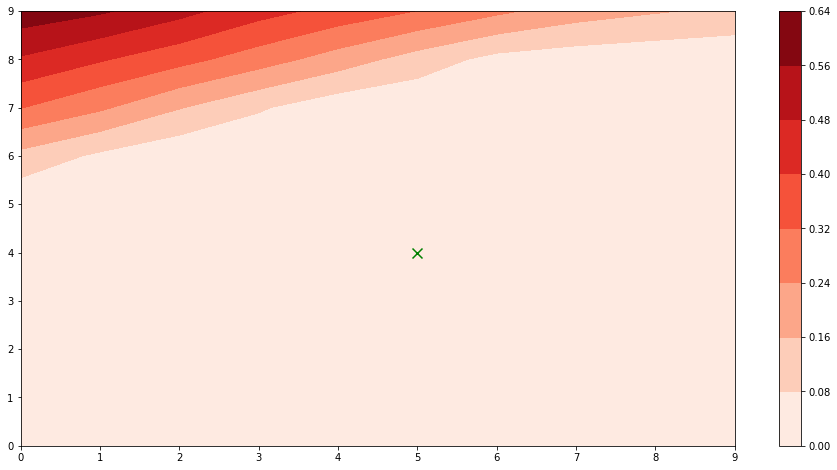

In [37]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
dates = slice('2012-08-13','2012-10-29')

right = mwds.ice[:,345:355,201:211].sel(time=dates).mean(dim='time')
#right.plot(vmin=0,vmax=0.65)
contf = ax.contourf(right.lon,right.lat,right,cmap='Reds',)
cbar = fig.colorbar(contf)
plt.scatter(5,4,marker='x',s=100,c='g')

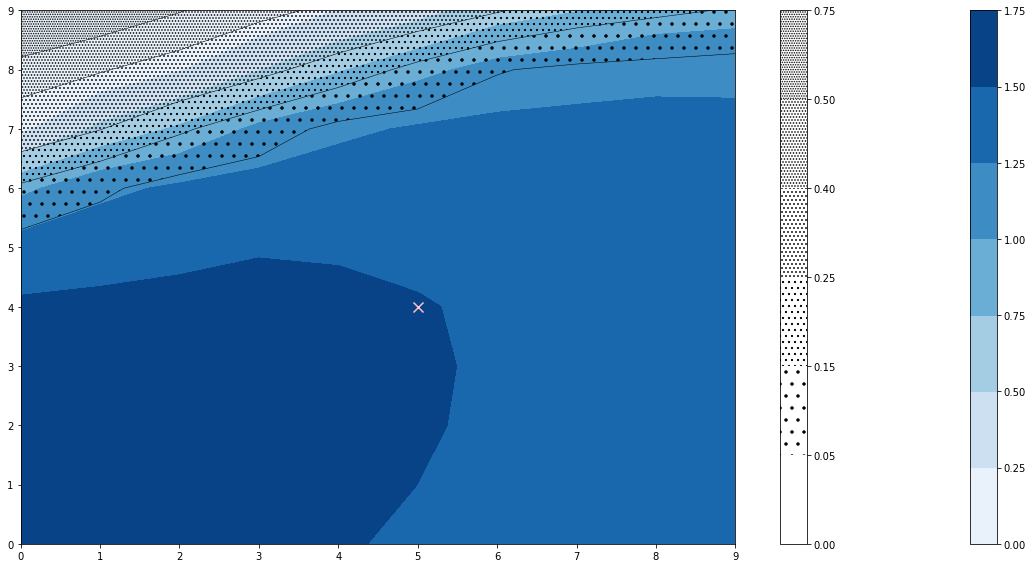

In [15]:
# attempt with stipples for ice
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
dates = slice('2012-08-13','2012-10-29')
hatches = ["",".","..","...","....","....."]
levels = [0,0.05,0.15,0.25,0.4,0.5,.75]

left = mwds.hs[:,345:355,201:211].sel(time=dates).mean(dim='time')
contf2 = ax.contourf(left,cmap='Blues')
cbar2 = fig.colorbar(contf2)

right = mwds.ice[:,345:355,201:211].sel(time=dates).mean(dim='time')
#right.plot(vmin=0,vmax=0.65)

contf = ax.contourf(right,
                    levels=levels,
                    hatches=hatches,
                    colors=['none'])
cbar = fig.colorbar(contf)

levels_nomin = levels[1:]
ax.contour(right,colors=['Black'],
           levels=levels_nomin,
           linewidths=0.5,
           linestyles='solid')

plt.scatter(5,4,marker='x',s=100,c='pink') # mooring

plt.tight_layout()
plt.show()

In [39]:
# create array with mooring locations
longitude = mwds.longitude[345:355,201:211]
latitude = mwds.latitude[345:355,201:211]
latitude

<xarray.DataArray 'latitude' (lat: 10, lon: 10)>
array([[73.268875, 73.12387 , 72.97679 , 72.82768 , 72.67663 , 72.523674,
        72.36889 , 72.21234 , 72.054085, 71.89417 ],
       [73.83239 , 73.68493 , 73.53539 , 73.38386 , 73.230385, 73.075035,
        72.91788 , 72.758965, 72.59837 , 72.43615 ],
       [74.39102 , 74.24105 , 74.089035, 73.935036, 73.77912 , 73.62135 ,
        73.4618  , 73.30052 , 73.13759 , 72.973045],
       [74.944244, 74.791725, 74.637184, 74.4807  , 74.32232 , 74.16212 ,
        74.00016 , 73.83651 , 73.671234, 73.50439 ],
       [75.49147 , 75.33637 , 75.179276, 75.02027 , 74.859406, 74.69676 ,
        74.532394, 74.36637 , 74.19875 , 74.02961 ],
       [76.03206 , 75.87433 , 75.71465 , 75.55311 , 75.38975 , 75.22465 ,
        75.05787 , 74.88948 , 74.71954 , 74.54811 ],
       [76.56525 , 76.40486 , 76.24258 , 76.078476, 75.91261 , 75.745056,
        75.575874, 75.405136, 75.232895, 75.05922 ],
       [77.09019 , 76.92712 , 76.762215, 76.59554 , 76.42718 , 76.25719 ,
        76.085625, 75.91256 , 75.73805 , 75.562164],
       [77.605896, 77.44013 , 77.272606, 77.103386, 76.93253 , 76.76012 ,
        76.586205, 76.41086 , 76.23414 , 76.05609 ],
       [78.11127 , 77.94281 , 77.772675, 77.600914, 77.42761 , 77.25283 ,
        77.07662 , 76.899055, 76.720184, 76.54006 ]], dtype=float32)
Dimensions without coordinates: lat, lon
Attributes:
    units:          degree_north
    long_name:      latitude
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      180.0
    axis:           Y

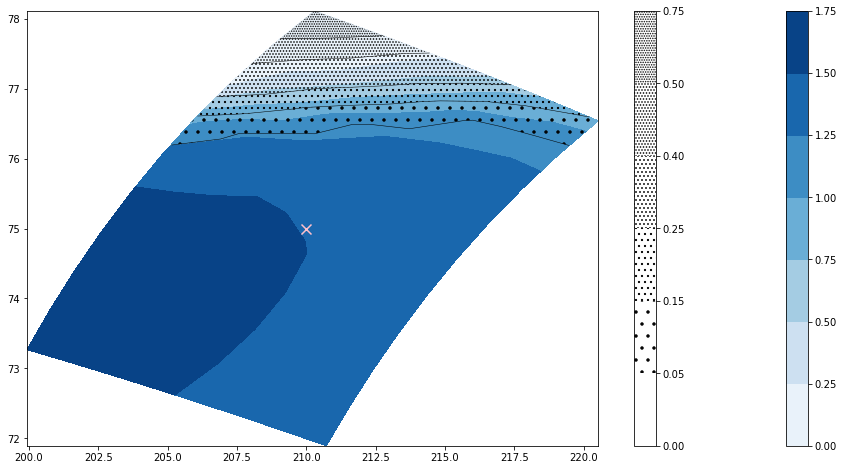

In [21]:
# attempt with stipples for ice
# 
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
dates = slice('2012-08-13','2012-10-29')
hatches = ["",".","..","...","....","....."]
levels = [0,0.05,0.15,0.25,0.4,0.5,.75]

hs = mwds.hs[:,345:355,201:211].sel(time=dates).mean(dim='time')
icefrac = mwds.ice[:,345:355,201:211].sel(time=dates).mean(dim='time')
longitude = mwds.longitude[345:355,201:211]
latitude = mwds.latitude[345:355,201:211]

contf2 = ax.contourf(longitude,latitude,hs,cmap='Blues')
cbar2 = fig.colorbar(contf2)

contf = ax.contourf(longitude,latitude,icefrac,
                    levels=levels,
                    hatches=hatches,
                    colors=['none'])
cbar = fig.colorbar(contf)

levels_nomin = levels[1:]
ax.contour(longitude,latitude,icefrac,colors=['Black'],
           levels=levels_nomin,
           linewidths=0.5,
           linestyles='solid')

plt.scatter(210,75,marker='x',s=100,c='pink') # mooring
plt.show()

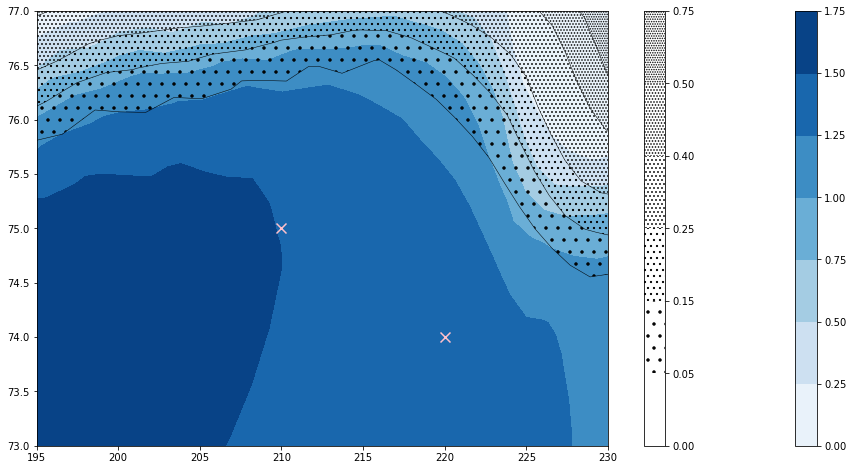

In [22]:
# 2012
## WAVE HEIGHT -- MODEL
## IceFrac -- MODEL
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
dates = slice('2012-08-13','2012-10-29')
hatches = ["",".","..","...","....","....."]
levels = [0,0.05,0.15,0.25,0.4,0.5,.75]
latsel = slice(340,380)
lonsel = slice(188,230)
#laty = slice(345,355)
#lonx = slice(201,211)

hs = mwds.hs.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
icefrac = mwds.ice.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
longitude = mwds.longitude.sel(lat=latsel,lon=lonsel)
latitude = mwds.latitude.sel(lat=latsel,lon=lonsel)

contf2 = ax.contourf(longitude,latitude,hs,cmap='Blues')
cbar2 = fig.colorbar(contf2)

contf = ax.contourf(longitude,latitude,icefrac,
                    levels=levels,
                    hatches=hatches,
                    colors=['none'])
cbar = fig.colorbar(contf)

levels_nomin = levels[1:]
ax.contour(longitude,latitude,icefrac,colors=['Black'],
           levels=levels_nomin,
           linewidths=0.5,
           linestyles='solid')

plt.xlim(195,230)
plt.ylim(73,77)
plt.scatter(210,75,marker='x',s=100,c='pink') # mooring
plt.scatter(220,74,marker='x',s=100,c='pink') # mooring
plt.show()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


NameError: name 'boot' is not defined

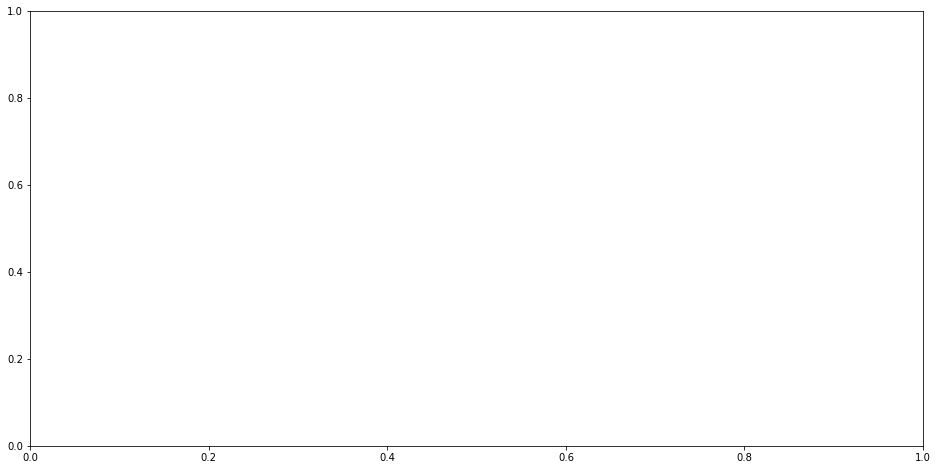

In [11]:
# 2012
## ICEFRAC -- BOOTSTRAP
## WAVE HEIGHT -- Simulation
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
dates = slice('2012-08-13','2012-10-29')
hatches = ["",".","..","...","....","....."]
levels = [0,0.05,0.15,0.25,0.4,0.5,.75]
latsel = slice(340,380)
lonsel = slice(188,230)
#laty = slice(345,355)
#lonx = slice(201,211)

hs = mwds.hs.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
icefrac = boot.seaice_conc_cdr.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
longitude = mwds.longitude.sel(lat=latsel,lon=lonsel)
latitude = mwds.latitude.sel(lat=latsel,lon=lonsel)

contf2 = ax.contourf(longitude,latitude,hs,cmap='Blues')
cbar2 = fig.colorbar(contf2)

contf = ax.contourf(longitude,latitude,icefrac,
                    levels=levels,
                    hatches=hatches,
                    colors=['none'])
cbar = fig.colorbar(contf)

levels_nomin = levels[1:]
ax.contour(longitude,latitude,icefrac,colors=['Black'],
           levels=levels_nomin,
           linewidths=0.5,
           linestyles='solid')

#mooring_hs = str(bds12.sigwaveheight.sel(time=dates).mean().values)
print(bds12.sigwaveheight.sel(time=dates).mean().values)

plt.xlim(195,230)
plt.ylim(73,77)
plt.scatter(210,75,marker='x',s=100,c='pink') # mooring
#ax.annotate(mooring_hs,210,75)
plt.scatter(220,74,marker='x',s=100,c='pink') # mooring
plt.show()

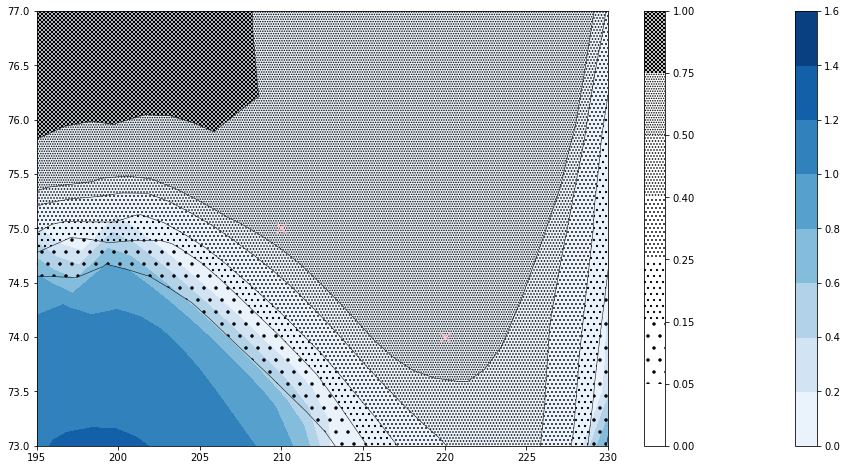

In [24]:
# 2015
## WAVE HEIGHT -- MODEL
## IceFrac -- MODEL
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
# dates = slice('2015-08-23','2015-10-06')
dates = slice('2015-09-03','2015-09-05')
hatches = ["",".","..","...","....",".....","xxxxxx"]
levels = [0,0.05,0.15,0.25,0.4,0.5,.75,1]
latsel = slice(340,380)
lonsel = slice(188,230)
#laty = slice(345,355)
#lonx = slice(201,211)

hs = mwds.hs.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
icefrac = mwds.ice.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
longitude = mwds.longitude.sel(lat=latsel,lon=lonsel)
latitude = mwds.latitude.sel(lat=latsel,lon=lonsel)

contf2 = ax.contourf(longitude,latitude,hs,cmap='Blues')
cbar2 = fig.colorbar(contf2)

contf = ax.contourf(longitude,latitude,icefrac,
                    levels=levels,
                    hatches=hatches,
                    colors=['none'])
cbar = fig.colorbar(contf)

levels_nomin = levels[1:]
ax.contour(longitude,latitude,icefrac,colors=['Black'],
           levels=levels_nomin,
           linewidths=0.5,
           linestyles='solid')

plt.xlim(195,230)
plt.ylim(73,77)
plt.scatter(210,75,marker='x',s=100,c='pink') # mooring
plt.scatter(220,74,marker='x',s=100,c='pink') # mooring
plt.show()

0.24823902554856958


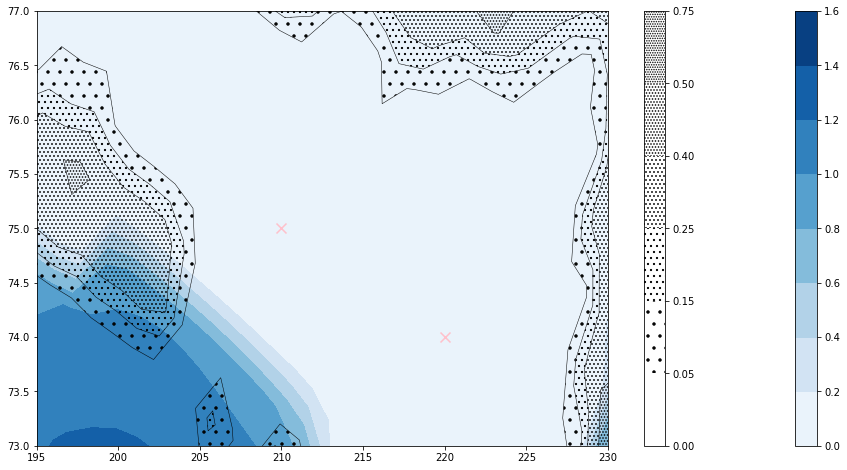

In [16]:
# 2015
## ICEFRAC -- BOOTSTRAP
## WAVE HEIGHT -- Simulation
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
# dates = slice('2015-08-23','2015-10-06')
dates = slice('2015-09-03','2015-09-05')
hatches = ["",".","..","...","....","....."]
levels = [0,0.05,0.15,0.25,0.4,0.5,.75]
latsel = slice(340,380)
lonsel = slice(188,230)
#laty = slice(345,355)
#lonx = slice(201,211)

hs = mwds.hs.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
icefrac = boot.seaice_conc_cdr.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
longitude = mwds.longitude.sel(lat=latsel,lon=lonsel)
latitude = mwds.latitude.sel(lat=latsel,lon=lonsel)

contf2 = ax.contourf(longitude,latitude,hs,cmap='Blues')
cbar2 = fig.colorbar(contf2)

contf = ax.contourf(longitude,latitude,icefrac,
                    levels=levels,
                    hatches=hatches,
                    colors=['none'])
cbar = fig.colorbar(contf)

levels_nomin = levels[1:]
ax.contour(longitude,latitude,icefrac,colors=['Black'],
           levels=levels_nomin,
           linewidths=0.5,
           linestyles='solid')

#mooring_hs = str(bds12.sigwaveheight.sel(time=dates).mean().values)
print(bds15.sigwaveheight.sel(time=dates).mean().values)

plt.xlim(195,230)
plt.ylim(73,77)
plt.scatter(210,75,marker='x',s=100,c='pink') # mooring
#ax.annotate(mooring_hs,210,75)
plt.scatter(220,74,marker='x',s=100,c='pink') # mooring
plt.show()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


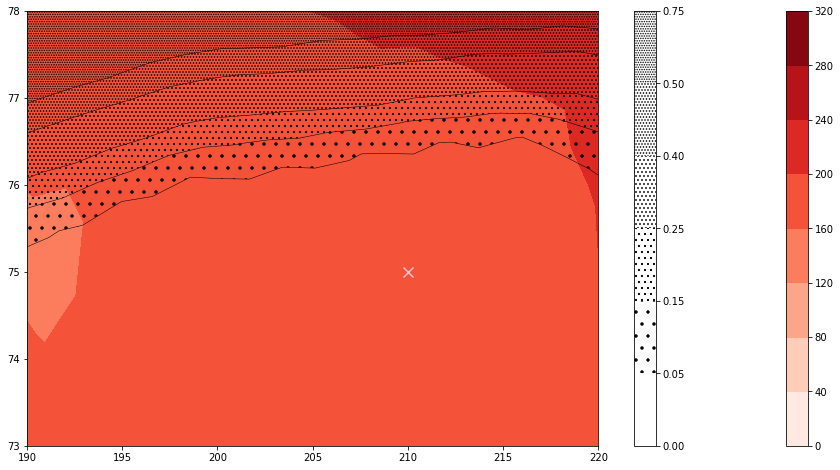

In [20]:
## WAVE DIRECTION
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
dates = slice('2012-08-13','2012-10-29')
hatches = ["",".","..","...","....","....."]
levels = [0,0.05,0.15,0.25,0.4,0.5,.75]
latsel = slice(340,380)
lonsel = slice(188,220)
#laty = slice(345,355)
#lonx = slice(201,211)

direction = mwds.dp.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
icefrac = mwds.ice.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
longitude = mwds.longitude.sel(lat=latsel,lon=lonsel)
latitude = mwds.latitude.sel(lat=latsel,lon=lonsel)

contf2 = ax.contourf(longitude,latitude,direction,cmap='Reds')
cbar2 = fig.colorbar(contf2)

contf = ax.contourf(longitude,latitude,icefrac,
                    levels=levels,
                    hatches=hatches,
                    colors=['none'])
cbar = fig.colorbar(contf)

levels_nomin = levels[1:]
ax.contour(longitude,latitude,icefrac,colors=['Black'],
           levels=levels_nomin,
           linewidths=0.5,
           linestyles='solid')

plt.xlim(190,220)
plt.ylim(73,78)
plt.scatter(210,75,marker='x',s=100,c='pink') # mooring
plt.show()

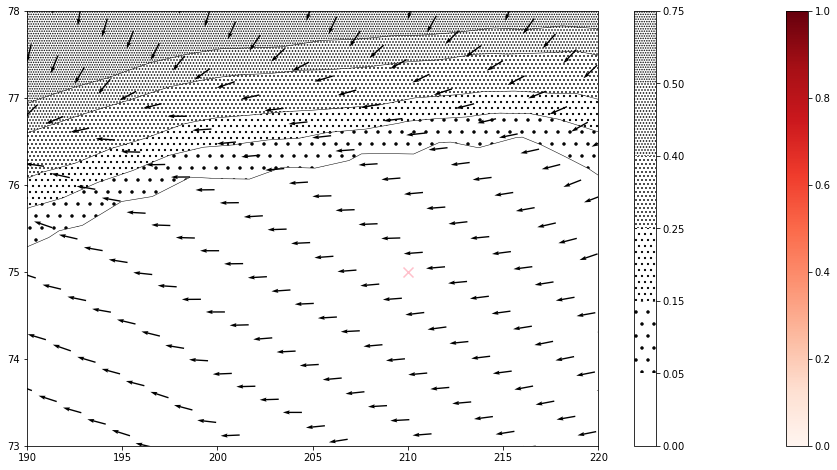

In [21]:
## WAVE DIRECTION
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
dates = slice('2012-08-13','2012-10-29')
hatches = ["",".","..","...","....","....."]
levels = [0,0.05,0.15,0.25,0.4,0.5,.75]
latsel = slice(340,380)
lonsel = slice(188,220)
#laty = slice(345,355)
#lonx = slice(201,211)

direction = mwds.dir.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
u = np.cos(np.deg2rad(direction))
v = np.sin(np.deg2rad(direction))
icefrac = mwds.ice.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
longitude = mwds.longitude.sel(lat=latsel,lon=lonsel)
latitude = mwds.latitude.sel(lat=latsel,lon=lonsel)

contf2 = ax.quiver(longitude,latitude,u,v,scale=30,cmap='Reds')
cbar2 = fig.colorbar(contf2)

contf = ax.contourf(longitude,latitude,icefrac,
                    levels=levels,
                    hatches=hatches,
                    colors=['none'])
cbar = fig.colorbar(contf)

levels_nomin = levels[1:]
ax.contour(longitude,latitude,icefrac,colors=['Black'],
           levels=levels_nomin,
           linewidths=0.5,
           linestyles='solid')

plt.xlim(190,220)
plt.ylim(73,78)
plt.scatter(210,75,marker='x',s=100,c='pink') # mooring
plt.show()

In [22]:
mwds.spr

<xarray.DataArray 'spr' (time: 24800, lat: 384, lon: 320)>
[3047424000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2016-12-31T18:00:00
Dimensions without coordinates: lat, lon
Attributes:
    long_name:      directional spread
    standard_name:  sea_surface_wave_directional_spread
    globwave_name:  directional_spread
    units:          degree
    valid_min:      0
    valid_max:      900

## Read in SWIFT data

In [5]:
for i, file in enumerate(swift_files):
    print(i, file, swift_names[i])

0 SWIFT09_02Nov2015_30min_converted.nc SWIFT09_02Nov2015
1 SWIFT09_06-08Oct2015_30min_converted.nc SWIFT09_06-08Oct2015
2 SWIFT09_11-14Oct2015_30min_converted.nc SWIFT09_11-14Oct2015
3 SWIFT09_23-24Oct2015_30min_converted.nc SWIFT09_23-24Oct2015
4 SWIFT09_31Oct-01Nov2015_30min_converted.nc SWIFT09_31Oct-01Nov2015
5 SWIFT11_04Oct2015_30min_converted.nc SWIFT11_04Oct2015
6 SWIFT11_10Oct2015_30min_converted.nc SWIFT11_10Oct2015
7 SWIFT11_11-14Oct2015_30min_converted.nc SWIFT11_11-14Oct2015
8 SWIFT11_16-18Oct2015_30min_converted.nc SWIFT11_16-18Oct2015
9 SWIFT11_23-24Oct2015_30min_converted.nc SWIFT11_23-24Oct2015
10 SWIFT11_31Oct-01Nov2015_30min_converted.nc SWIFT11_31Oct-01Nov2015
11 SWIFT12_02Oct2015_30min_converted.nc SWIFT12_02Oct2015
12 SWIFT12_04Oct2015_30min_converted.nc SWIFT12_04Oct2015
13 SWIFT12_06-08Oct2015_30min_converted.nc SWIFT12_06-08Oct2015
14 SWIFT12_11-14Oct2015_30min_converted.nc SWIFT12_11-14Oct2015
15 SWIFT12_23-24Oct2015_30min_converted.nc SWIFT12_23-24Oct2015
16 S

In [6]:
# inspect data
swift_dict[swift_names[22]]

<xarray.Dataset>
Dimensions:                       (freq_wavespectra: 42, time: 66, z_downlooking: 40, z_uplooking: 16)
Coordinates:
  * time                          (time) datetime64[ns] 2015-10-17T00:45:00 ... 2015-10-18T10:14:59
  * z_uplooking                   (z_uplooking) float64 0.62 0.58 ... 0.06 0.02
  * z_downlooking                 (z_downlooking) float64 nan nan ... nan nan
  * freq_wavespectra              (freq_wavespectra) float64 0.009766 ... 0.4902
Data variables:
    uplooking_tkedissipationrate  (time, z_uplooking) float64 ...
    downlooking_velocityprofile   (time, z_downlooking) float64 ...
    wavespectra_energy            (time, freq_wavespectra) float64 ...
    wavespectra_a1                (time, freq_wavespectra) float64 ...
    wavespectra_b1                (time, freq_wavespectra) float64 ...
    wavespectra_a2                (time, freq_wavespectra) float64 ...
    wavespectra_b2                (time, freq_wavespectra) float64 ...
    wavespectra_check             (time, freq_wavespectra) float64 ...
    winddirT                      (time) float64 ...
    winddirTstddev                (time) float64 ...
    windspd                       (time) float64 ...
    windspdstddev                 (time) float64 ...
    airtemp                       (time) float64 ...
    airtempstddev                 (time) float64 ...
    airpres                       (time) float64 ...
    airpresstddev                 (time) float64 ...
    driftdirT                     (time) float64 ...
    driftdirTstddev               (time) float64 ...
    driftspd                      (time) float64 ...
    driftspdstddev                (time) float64 ...
    sigwaveheight                 (time) float64 ...
    peakwaveperiod                (time) float64 ...
    peakwavedirT                  (time) float64 ...
    lat                           (time) float64 ...
    lon                           (time) float64 ...
    watertemp                     (time) float64 ...
    salinity                      (time) float64 ...
Attributes:
    description:   SWIFT
    processed by:  Jim Thomson, APL

In [7]:
for i,name in enumerate(swift_dict):
    print(i, swift_dict[name].time.min().values, swift_dict[name].time.max().values,)

0 2015-11-02T09:14:59.000000000 2015-11-02T16:44:59.000000000
1 2015-10-06T12:45:00.000000000 2015-10-08T03:45:00.000000000
2 2015-10-11T10:44:59.000000000 2015-10-14T02:14:59.000000000
3 2015-10-23T15:45:00.000000000 2015-10-25T00:14:59.000000000
4 2015-10-31T17:44:59.000000000 2015-11-01T18:44:59.000000000
5 2015-10-04T12:45:00.000000000 2015-10-04T18:45:00.000000000
6 2015-10-10T10:14:59.000000000 2015-10-10T22:44:59.000000000
7 2015-10-11T14:44:59.000000000 2015-10-12T14:44:59.000000000
8 2015-10-17T10:14:59.000000000 2015-10-18T14:44:59.000000000
9 2015-10-23T17:14:59.000000000 2015-10-24T17:44:59.000000000
10 2015-10-31T16:44:59.000000000 2015-11-01T20:44:59.000000000
11 2015-10-02T17:14:59.000000000 2015-10-02T20:14:59.000000000
12 2015-10-04T09:45:00.000000000 2015-10-04T14:44:59.000000000
13 2015-10-06T13:14:59.000000000 2015-10-08T03:14:59.000000000
14 2015-10-11T12:45:00.000000000 2015-10-12T15:45:00.000000000
15 2015-10-23T17:44:59.000000000 2015-10-25T00:14:59.000000000
16

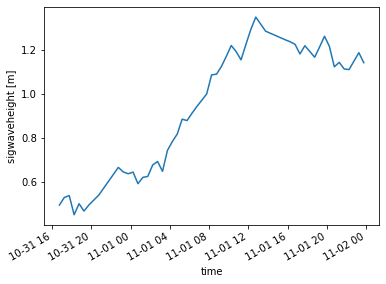

In [13]:
swift_dict[swift_names[26]].sigwaveheight.plot()

201.3 72.5
203.9 75.4
209.7 72.7
201.2 72.7
200.7 72.7
198.7 74.4
209.8 73.4
211.1 72.4
197.9 74.0
201.3 72.6
200.8 72.6
194.9 70.0
198.5 74.4
203.8 75.4
210.6 72.5
201.2 72.7
210.7 72.5
201.3 72.6
200.7 72.7
198.7 74.4
209.7 73.4
209.3 72.9
198.7 73.8
200.9 72.6
208.3 72.9
200.8 72.5
200.8 72.6


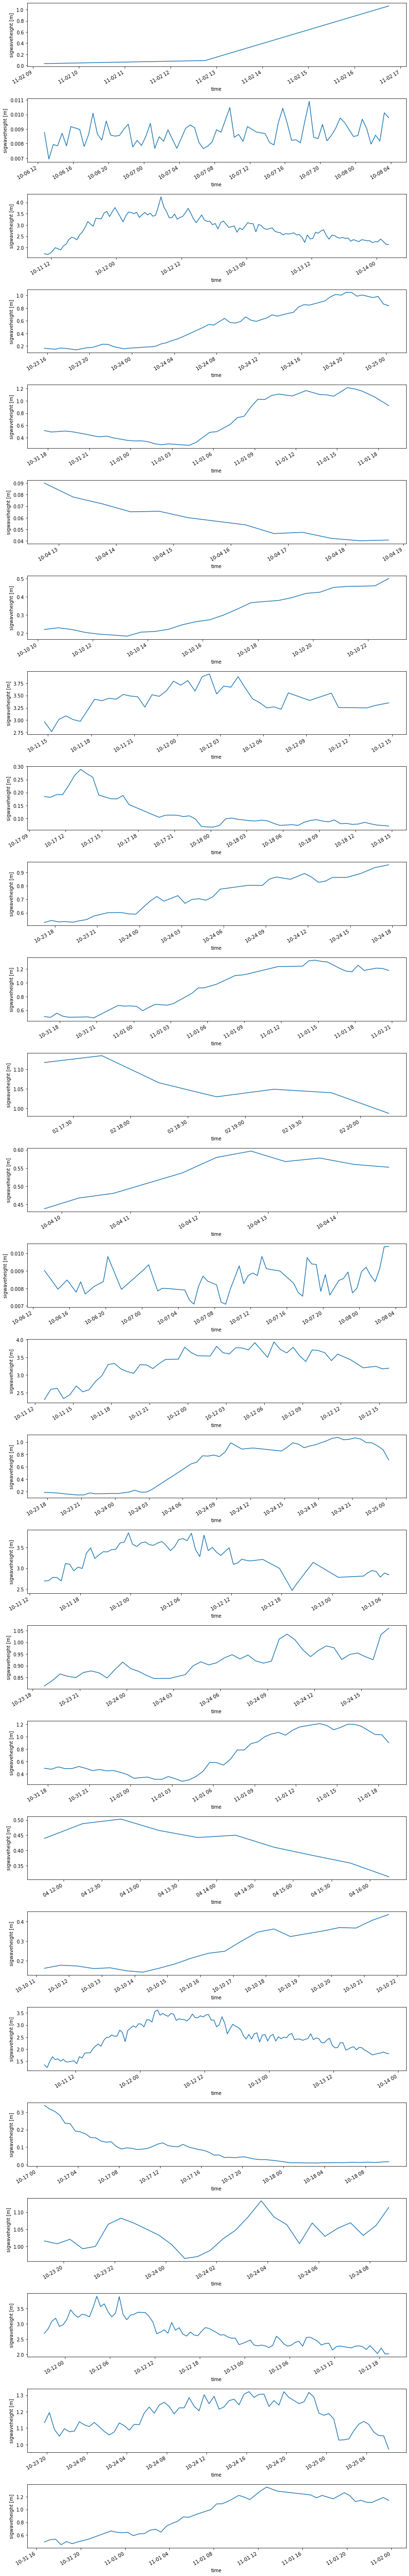

In [14]:
# plot sigwave height for each of the swifts
fig,ax = plt.subplots(nrows=nswift,figsize=(12,75))

for i,name in enumerate(swift_dict):
    swift_dict[name].sigwaveheight.plot(ax=ax[i])
    print(np.round(swift_dict[name].lon.mean().values+360,1),
          np.round(swift_dict[name].lat.mean().values,1))
    #plt.ylim(0,2)
    
plt.tight_layout()

In [15]:
boot

<xarray.Dataset>
Dimensions:                         (lat: 384, lon: 320, time: 13012)
Coordinates:
  * time                            (time) datetime64[ns] 1979-01-02 ... 2018-12-31
    TLON                            (lat, lon) float32 ...
    TLAT                            (lat, lon) float32 ...
Dimensions without coordinates: lat, lon
Data variables:
    seaice_conc_cdr                 (time, lat, lon) float32 ...
    stdev_of_seaice_conc_cdr        (time, lat, lon) float32 ...
    melt_onset_day_seaice_conc_cdr  (time, lat, lon) float32 ...
    qa_of_seaice_conc_cdr           (time, lat, lon) float32 ...
    goddard_merged_seaice_conc      (time, lat, lon) float32 ...
    goddard_nt_seaice_conc          (time, lat, lon) float32 ...
    goddard_bt_seaice_conc          (time, lat, lon) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    history:                   Tue Jan 21 12:40:16 2020: cdo remapbil,o.nc se...
    source:                    ftp://sidads.colorado.edu/DATASETS/nsidc0051_g...
    institution:               NSIDC > National Snow and Ice Data Center
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    program:                   NOAA Climate Data Record Program
    cdr_variable:              seaice_conc_cdr
    software_version_id:       git@bitbucket.org:nsidc/seaice_cdr.git@a4589e0...
    Metadata_Link:             http://nsidc.org/api/metadata?id=g02202
    product_version:           v03r01
    spatial_resolution:        25km
    standard_name_vocabulary:  CF Standard Name Table (v16, 11 October 2010)
    id:                        G02202
    naming_authority:          nsidc.org
    license:                   No constraints on data access or use
    summary:                   This data set provides a passive microwave sea...
    keywords:                  EARTH SCIENCE > CRYOSPHERE > SEA ICE > SEA ICE...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Key...
    cdm_data_type:             Grid
    project:                   NOAA/NSIDC passive microwave sea ice concentra...
    creator_url:               http://nsidc.org/
    creator_email:             nsidc@nsidc.org
    processing_level:          NOAA Level 3
    geospatial_lat_min:        31.35
    geospatial_lat_max:        90.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lon_units:      degrees_east
    time_coverage_duration:    P1D
    time_coverage_resolution:  P1D
    contributor_name:          Walt Meier, Ruth Duerr, Florence Fetterer, Jul...
    contributor_role:          PrincipalInvestigator,author,author,author,aut...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2017-11-18T06:25:29Z
    time_coverage_start:       1979-01-02T00:00:00Z
    time_coverage_end:         1979-01-02T23:59:59Z
    comment:                   The variables seaice_conc_cdr, stdev_of_seaice...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...

In [16]:
# create array of swift coordinates
swift_coords = np.zeros(nswift*2).reshape(nswift,2)

for i,name in enumerate(swift_dict):
    swift_coords[i,0] = swift_dict[name].lon.mean().values+360
    swift_coords[i,1] = swift_dict[name].lat.mean().values
swift_coords

array([[201.27315267,  72.47679901],
       [203.85631634,  75.37822953],
       [209.65747783,  72.67939502],
       [201.15814289,  72.73556545],
       [200.74565941,  72.68591326],
       [198.68183899,  74.43858983],
       [209.78346546,  73.40149747],
       [211.13195437,  72.41470864],
       [197.92319254,  73.95926886],
       [201.33508725,  72.63204066],
       [200.76873627,  72.62610416],
       [194.85533796,  69.96548244],
       [198.5201355 ,  74.36516037],
       [203.8482508 ,  75.36899689],
       [210.57883189,  72.48496819],
       [201.22011208,  72.70039383],
       [210.70981155,  72.50194279],
       [201.25592644,  72.61640008],
       [200.74642334,  72.68595139],
       [198.67805634,  74.42159729],
       [209.68418954,  73.42971039],
       [209.2802422 ,  72.85668528],
       [198.6567503 ,  73.78159679],
       [200.94837734,  72.58176368],
       [208.32714425,  72.94181572],
       [200.79774955,  72.54915946],
       [200.77098436,  72.63397261]])

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


1.1010814775002213


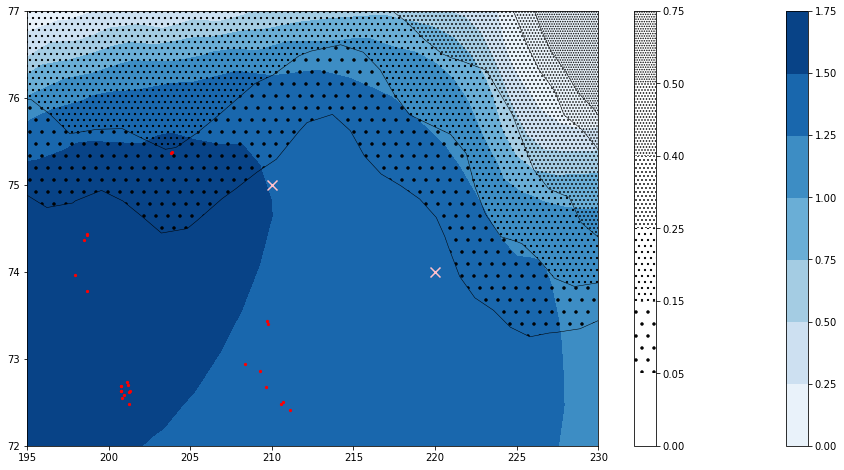

In [17]:
# 2012
## ICEFRAC -- BOOTSTRAP
## WAVE HEIGHT -- Simulation
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
dates = slice('2012-08-13','2012-10-29')
hatches = ["",".","..","...","....","....."]
levels = [0,0.05,0.15,0.25,0.4,0.5,.75]
latsel = slice(340,380)
lonsel = slice(188,230)
#laty = slice(345,355)
#lonx = slice(201,211)

hs = mwds.hs.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
icefrac = boot.seaice_conc_cdr.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
longitude = mwds.longitude.sel(lat=latsel,lon=lonsel)
latitude = mwds.latitude.sel(lat=latsel,lon=lonsel)

contf2 = ax.contourf(longitude,latitude,hs,cmap='Blues')
cbar2 = fig.colorbar(contf2)

contf = ax.contourf(longitude,latitude,icefrac,
                    levels=levels,
                    hatches=hatches,
                    colors=['none'])
cbar = fig.colorbar(contf)

levels_nomin = levels[1:]
ax.contour(longitude,latitude,icefrac,colors=['Black'],
           levels=levels_nomin,
           linewidths=0.5,
           linestyles='solid')

#mooring_hs = str(bds12.sigwaveheight.sel(time=dates).mean().values)
print(bds12.sigwaveheight.sel(time=dates).mean().values)

plt.xlim(195,230)
plt.ylim(72,77)
plt.scatter(210,75,marker='x',s=100,c='pink') # mooring
#ax.annotate(mooring_hs,210,75)
plt.scatter(220,74,marker='x',s=100,c='pink') # mooring
plt.scatter(swift_coords[:,0],swift_coords[:,1],s=20,marker='.',c='r')
plt.show()

1.4698151577373442


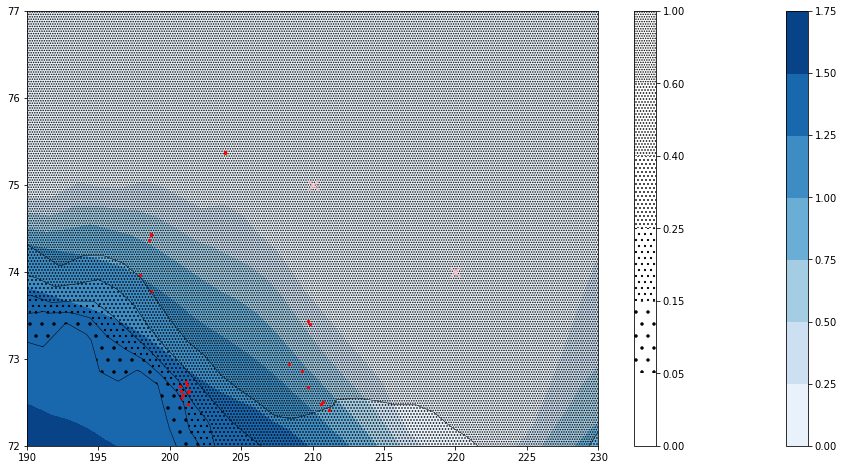

In [18]:
# 2015
## ICEFRAC -- BOOTSTRAP
## WAVE HEIGHT -- Simulation
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
dates = slice('2015-10-01','2015-11-03')
hatches = ["",".","..","...","....","....."]
levels = [0,0.05,0.15,0.25,0.4,0.6,1]
latsel = slice(340,380)
lonsel = slice(188,230)
#laty = slice(345,355)
#lonx = slice(201,211)

hs = mwds.hs.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
icefrac = boot.seaice_conc_cdr.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
longitude = mwds.longitude.sel(lat=latsel,lon=lonsel)
latitude = mwds.latitude.sel(lat=latsel,lon=lonsel)

contf2 = ax.contourf(longitude,latitude,hs,cmap='Blues')
cbar2 = fig.colorbar(contf2)

contf = ax.contourf(longitude,latitude,icefrac,
                    levels=levels,
                    hatches=hatches,
                    colors=['none'])
cbar = fig.colorbar(contf)

levels_nomin = levels[1:]
ax.contour(longitude,latitude,icefrac,colors=['Black'],
           levels=levels_nomin,
           linewidths=0.5,
           linestyles='solid')

#mooring_hs = str(bds12.sigwaveheight.sel(time=dates).mean().values)
print(bds15.sigwaveheight.sel(time=dates).mean().values)

plt.xlim(190,230)
plt.ylim(72,77)
plt.scatter(210,75,marker='x',s=100,c='pink') # mooring
#ax.annotate(mooring_hs,210,75)
plt.scatter(220,74,marker='x',s=100,c='pink') # mooring
plt.scatter(swift_coords[:,0],swift_coords[:,1],s=20,marker='.',c='r')
plt.show()

1.4698151577373442


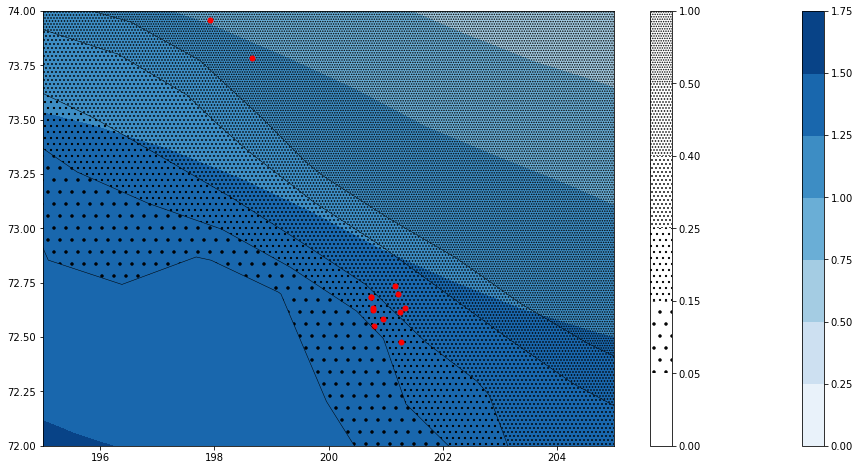

In [24]:
# 2015
## ICEFRAC -- BOOTSTRAP
## WAVE HEIGHT -- Simulation
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
dates = slice('2015-10-01','2015-11-03')
hatches = ["",".","..","...","....","....."]
levels = [0,0.05,0.15,0.25,0.4,0.5,1]
latsel = slice(340,380)
lonsel = slice(188,230)
#laty = slice(345,355)
#lonx = slice(201,211)

hs = mwds.hs.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
icefrac = boot.seaice_conc_cdr.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
longitude = mwds.longitude.sel(lat=latsel,lon=lonsel)
latitude = mwds.latitude.sel(lat=latsel,lon=lonsel)

contf2 = ax.contourf(longitude,latitude,hs,cmap='Blues')
cbar2 = fig.colorbar(contf2)

contf = ax.contourf(longitude,latitude,icefrac,
                    levels=levels,
                    hatches=hatches,
                    colors=['none'])
cbar = fig.colorbar(contf)

levels_nomin = levels[1:]
ax.contour(longitude,latitude,icefrac,colors=['Black'],
           levels=levels_nomin,
           linewidths=0.5,
           linestyles='solid')

#mooring_hs = str(bds12.sigwaveheight.sel(time=dates).mean().values)
print(bds15.sigwaveheight.sel(time=dates).mean().values)

plt.xlim(195,205)
plt.ylim(72,74)
plt.scatter(210,75,marker='x',s=100,c='pink') # mooring
#ax.annotate(mooring_hs,210,75)
plt.scatter(220,74,marker='x',s=100,c='pink') # mooring
plt.scatter(swift_coords[:,0],swift_coords[:,1],s=100,marker='.',c='r')
plt.show()

In [26]:
swift_dict[swift_names[20]].time.dt.dayofyear

<xarray.DataArray 'dayofyear' (time: 22)>
array([283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283,
       283, 283, 283, 283, 283, 283, 283, 283, 283])
Coordinates:
  * time     (time) datetime64[ns] 2015-10-10T11:14:59 ... 2015-10-10T21:44:59

In [52]:
# determine what date the swifts were dropped in this area
october2325 = []

for i,name in enumerate(swift_dict):
    if swift_dict[name].lon.mean().values < 202 and swift_dict[name].lat.mean().values < 73:
        print(i)
        print(swift_dict[name].time.min().values, swift_dict[name].time.max().values)
    else:
        print("")

0
2015-11-02T09:14:59.000000000 2015-11-02T16:44:59.000000000

2
2015-10-11T10:44:59.000000000 2015-10-14T02:14:59.000000000
3
2015-10-23T15:45:00.000000000 2015-10-25T00:14:59.000000000
4
2015-10-31T17:44:59.000000000 2015-11-01T18:44:59.000000000


7
2015-10-11T14:44:59.000000000 2015-10-12T14:44:59.000000000

9
2015-10-23T17:14:59.000000000 2015-10-24T17:44:59.000000000
10
2015-10-31T16:44:59.000000000 2015-11-01T20:44:59.000000000
11
2015-10-02T17:14:59.000000000 2015-10-02T20:14:59.000000000


14
2015-10-11T12:45:00.000000000 2015-10-12T15:45:00.000000000
15
2015-10-23T17:44:59.000000000 2015-10-25T00:14:59.000000000
16
2015-10-11T13:44:59.000000000 2015-10-13T06:44:59.000000000
17
2015-10-23T18:45:00.000000000 2015-10-24T16:44:59.000000000
18
2015-10-31T17:44:59.000000000 2015-11-01T18:44:59.000000000


21
2015-10-11T06:14:59.000000000 2015-10-13T22:14:59.000000000

23
2015-10-23T19:14:59.000000000 2015-10-24T08:44:59.000000000
24
2015-10-11T21:14:59.000000000 2015-10-13T19:14:59

nan


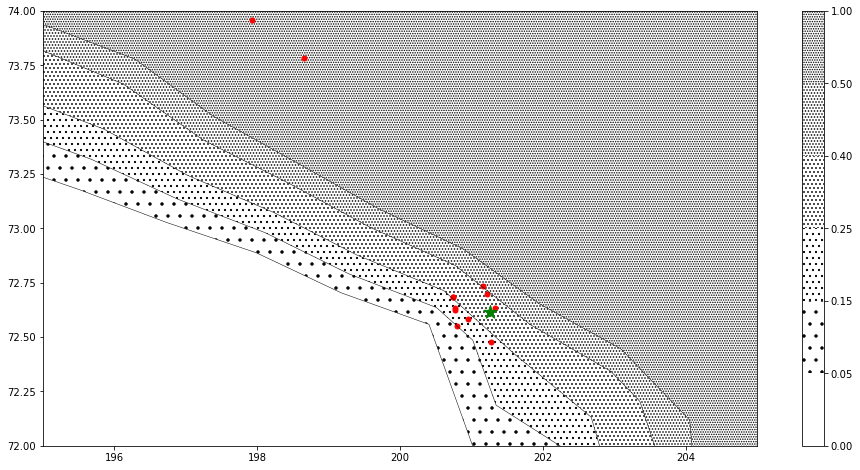

In [53]:
# 2015 redo plot for specific days
## ICEFRAC -- BOOTSTRAP
## WAVE HEIGHT -- Simulation
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
dates = slice('2015-10-23','2015-10-25')
hatches = ["",".","..","...","....","....."]
levels = [0,0.05,0.15,0.25,0.4,0.5,1]
latsel = slice(340,380)
lonsel = slice(188,230)
#laty = slice(345,355)
#lonx = slice(201,211)

hs = mwds.hs.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
icefrac = boot.seaice_conc_cdr.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
longitude = mwds.longitude.sel(lat=latsel,lon=lonsel)
latitude = mwds.latitude.sel(lat=latsel,lon=lonsel)

# contf2 = ax.contourf(longitude,latitude,hs,cmap='Blues')
# cbar2 = fig.colorbar(contf2)

contf = ax.contourf(longitude,latitude,icefrac,
                    levels=levels,
                    hatches=hatches,
                    colors=['none'])
cbar = fig.colorbar(contf)

levels_nomin = levels[1:]
ax.contour(longitude,latitude,icefrac,colors=['Black'],
           levels=levels_nomin,
           linewidths=0.5,
           linestyles='solid')

#mooring_hs = str(bds12.sigwaveheight.sel(time=dates).mean().values)
print(bds15.sigwaveheight.sel(time=dates).mean().values)

plt.xlim(195,205)
plt.ylim(72,74)
plt.scatter(210,75,marker='x',s=100,c='pink') # mooring
#ax.annotate(mooring_hs,210,75)
plt.scatter(220,74,marker='x',s=100,c='pink') # mooring
plt.scatter(swift_coords[:,0],swift_coords[:,1],s=100,marker='.',c='r')
plt.scatter(swift_dict[swift_names[17]].lon.mean().values+360,swift_dict[swift_names[17]].lat.mean().values,
            s=200,marker='*',c='g') 
plt.show()

nan


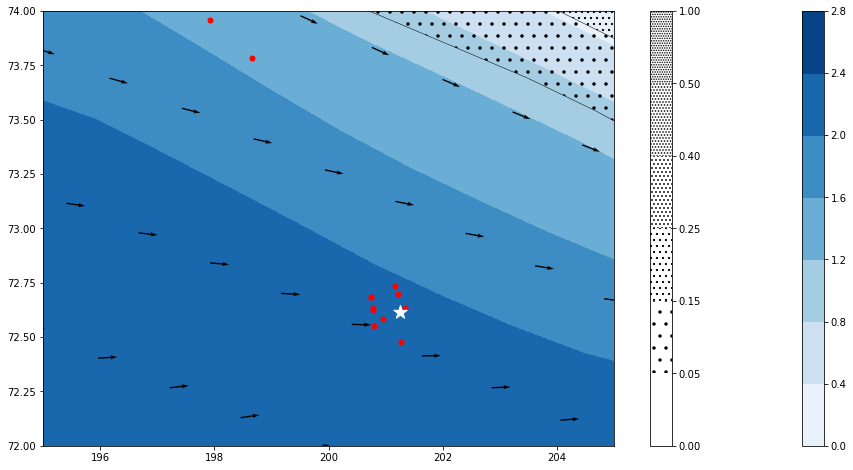

In [54]:
# 2015 redo plot for specific days
## ICEFRAC -- MODEL
## WAVE HEIGHT -- Simulation
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
dates = slice('2015-10-23','2015-10-25')
hatches = ["",".","..","...","....","....."]
levels = [0,0.05,0.15,0.25,0.4,0.5,1]
latsel = slice(340,380)
lonsel = slice(188,230)
#laty = slice(345,355)
#lonx = slice(201,211)

hs = mwds.hs.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
icefrac = mwds.ice.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time')
longitude = mwds.longitude.sel(lat=latsel,lon=lonsel)
latitude = mwds.latitude.sel(lat=latsel,lon=lonsel)

contf2 = ax.contourf(longitude,latitude,hs,cmap='Blues')
cbar2 = fig.colorbar(contf2)

contf = ax.contourf(longitude,latitude,icefrac,
                    levels=levels,
                    hatches=hatches,
                    colors=['none'])
cbar = fig.colorbar(contf)

levels_nomin = levels[1:]
ax.contour(longitude,latitude,icefrac,colors=['Black'],
           levels=levels_nomin,
           linewidths=0.5,
           linestyles='solid')

direction = 90-mwds.dir.sel(lat=latsel,lon=lonsel,time=dates).mean(dim='time') # bearing to std
u = np.cos(np.deg2rad(direction))
v = np.sin(np.deg2rad(direction))
contf3 = ax.quiver(longitude,latitude,u,v,scale=30)

#mooring_hs = str(bds12.sigwaveheight.sel(time=dates).mean().values)
print(bds15.sigwaveheight.sel(time=dates).mean().values)

plt.xlim(195,205)
plt.ylim(72,74)
plt.scatter(210,75,marker='x',s=100,c='pink') # mooring
#ax.annotate(mooring_hs,210,75)
plt.scatter(220,74,marker='x',s=100,c='pink') # mooring
plt.scatter(swift_coords[:,0],swift_coords[:,1],s=100,marker='.',c='r')
plt.scatter(swift_dict[swift_names[17]].lon.mean().values+360,swift_dict[swift_names[17]].lat.mean().values,
            s=200,marker='*',c='w') 
plt.show()

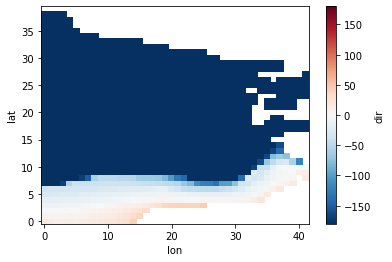

In [55]:
direction.plot()
#plt.pcolormesh(mwds.lon,mwds.lat,mwds.longitude)


# swift_dict[swift_names[17]].peakwavedirT.plot()
# plt.ylim(0,360)
# wind is not in the direction we want

201.25592644270077 72.61640007551327


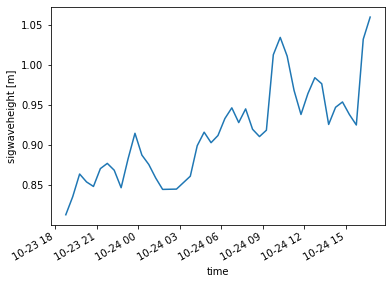

In [56]:
# but this shows that we should get wave heights approaching 1 meter in ~30-35% icefrac
print(swift_dict[swift_names[17]].lon.mean().values+360,swift_dict[swift_names[17]].lat.mean().values)
swift_dict[swift_names[17]].sigwaveheight.plot()

(320, 375)

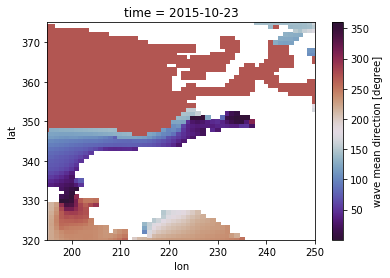

In [19]:
mwds.dir.sel(time='2015-10-23').isel(time=0).plot(cmap='twilight_shifted')
plt.xlim(195,250)
plt.ylim(320,375)

## Select cells...

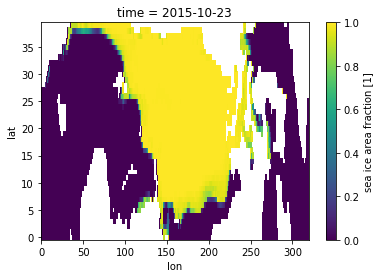

In [29]:
dates = slice('2015-10-23','2015-10-25')
latsel = slice(340,380)
#lonsel = slice(188,230)

icefrac = mwds.sel(time=dates,lat=latsel).isel(time=0).ice
hs = mwds.sel(time=dates,lat=latsel).isel(time=0).hs
icefrac.plot()

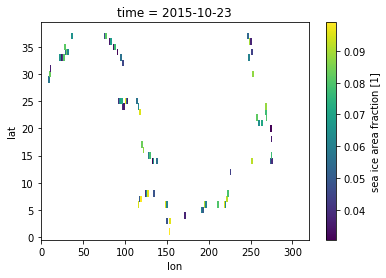

In [25]:
dates = slice('2015-10-23','2015-10-25')
latsel = slice(340,380)
#lonsel = slice(188,230)

icefrac = mwds.sel(time=dates,lat=latsel).isel(time=0).ice
hs = mwds.sel(time=dates,lat=latsel).isel(time=0).hs
icefrac.where(icefrac>0).where(icefrac<0.1).plot()

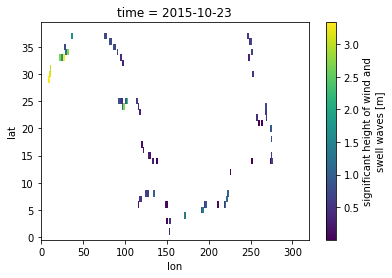

In [26]:
hs.where(icefrac>0).where(icefrac<0.1).plot()

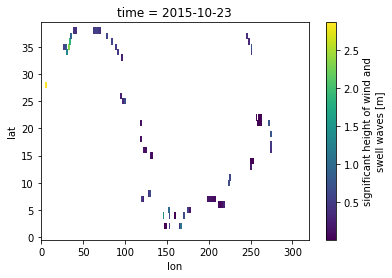

In [27]:
hs.where(icefrac>0.1).where(icefrac<0.25).plot()

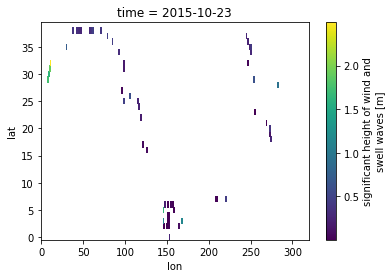

In [28]:
hs.where(icefrac>0.25).where(icefrac<0.5).plot()

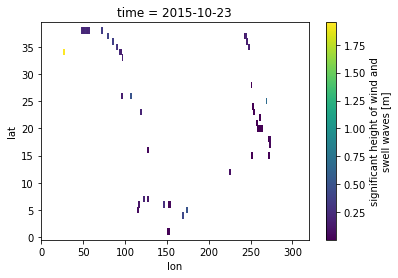

In [29]:
hs.where(icefrac>0.5).where(icefrac<0.75).plot()

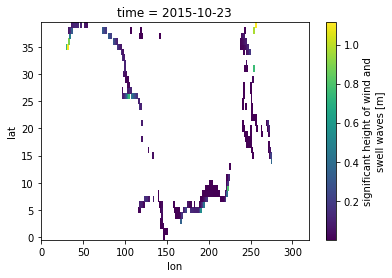

In [30]:
hs.where(icefrac>0.75).where(icefrac<0.95).plot()

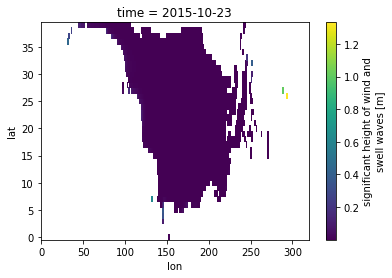

In [31]:
hs.where(icefrac>0.95).plot()

In [32]:
print('Mean Sig Wave Heights for icefrac bins\n',
      hs.where(icefrac>0.0).where(icefrac<0.1).mean().values,'\n',
      hs.where(icefrac>0.1).where(icefrac<0.2).mean().values,'\n',
      hs.where(icefrac>0.2).where(icefrac<0.5).mean().values,'\n',
      hs.where(icefrac>0.5).where(icefrac<0.75).mean().values,'\n',
      hs.where(icefrac>0.75).where(icefrac<0.95).mean().values,'\n',
      hs.where(icefrac>0.95).where(icefrac<1).mean().values)

Mean Sig Wave Heights for icefrac bins
 0.83080626 
 0.48804304 
 0.3470789 
 0.19100966 
 0.08775721 
 0.003989052


In [33]:
## TO DO
## pair swift data to icefrac bins from bootstrap, focus on beaufort sea
## see how swift compares to model

In [34]:
## Mooring data
bds15.sigwaveheight.mean()

<xarray.DataArray 'sigwaveheight' ()>
array(0.65712055)

## Scratch work to create function of distance

In [21]:
# create matrix of made-up values for icefrac
icefracs = np.array([[0.2,0.25,0.3],[0.1,0.05,0.15],[0.001,0.001,0.001]])
# try with a NaN
# icefracs = np.array([[0.2,0.25,0.3],[0.1,0.05,0.15],[0.001,0.001,float('NaN')]])
icefracs

array([[0.2  , 0.25 , 0.3  ],
       [0.1  , 0.05 , 0.15 ],
       [0.001, 0.001, 0.001]])

In [22]:
# this returns the actual values
icefracs[icefracs<0.01]

array([0.001, 0.001, 0.001])

In [23]:
# this returns the index location
locations = np.where(icefracs<0.01)
print(locations)

refloc = np.array([1,1])
distances = np.zeros(len(locations))

(array([2, 2, 2]), array([0, 1, 2]))


In [24]:
# list comprehension style, much more efficient
np.min([np.linalg.norm(loc-refloc) for loc in (np.transpose(locations))])

1.0

In [25]:
# for i,coord in enumerate(locations):
#     distances[i] = np.linalg.norm(coord-refloc)
# #     print(np.linalg.norm(coord-refloc))
# #     print(i,coord)

# print(distances)

# # use minimum distance to index back to the location
# # but maybe i dont even need this because all i care about is minimum distance
# # either way this is the short rig, i will have to change it to get km distance instead of cell distance
# locations[np.where(distances==distances.min())[0][0]]

## Try with intermediate step of real data, a small subset

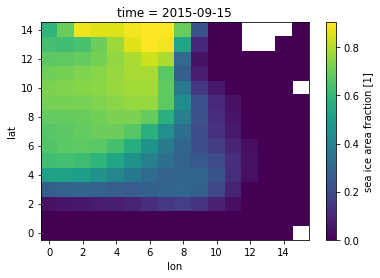

In [20]:
icefracs = mwds.ice[:,345:360,209:225].sel(time='2015-09-15')[0]
icefracs.plot()

In [21]:
icefracs[0][0]

<xarray.DataArray 'ice' ()>
array(0., dtype=float32)
Coordinates:
    time     datetime64[ns] 2015-09-15
Attributes:
    long_name:      sea ice area fraction
    standard_name:  sea_ice_area_fraction
    globwave_name:  sea_ice_area_fraction
    units:          1
    valid_min:      0
    valid_max:      1000

In [22]:
# turn icefracs to numpy array
icefracsnp = np.zeros(len(icefracs.lat)*len(icefracs.lon)).reshape(len(icefracs.lat),len(icefracs.lon))
icefracsnp = icefracs.values
icefracsnp

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
               nan],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.04174172, 0.04961797, 0.05868932, 0.06709045, 0.07587776,
        0.09121437, 0.1174312 , 0.14814338, 0.16395624, 0.14114861,
        0.08442433, 0.03333042, 0.        , 0.        , 0.        ,
        0.        ],
       [0.26637578, 0.28209168, 0.28961122, 0.2811984 , 0.26687676,
        0.26151994, 0.27309662, 0.28940627, 0.2937039 , 0.27221254,
        0.19494884, 0.08633815, 0.        , 0.        , 0.        ,
        0.        ],
       [0.5118457 , 0.5136794 , 0.49912873, 0.4647903 , 0.4169515 ,
        0.36372602, 0.3119284 , 

In [23]:
# this returns the index location
locations = np.where(icefracsnp<0.01)
print(locations)

refloc = np.array([4,4])
# distances = np.zeros(len(locations))

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        2,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  7,
        7,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 12, 13, 14,
       15, 12, 13, 14, 15, 13, 14, 15, 13, 14, 15, 13, 14, 15, 12, 13, 14,
       15, 12, 13, 14, 15, 12, 13, 14, 15, 11, 12, 13, 14, 10, 11, 12, 13,
       14, 15, 10, 11, 12, 13, 14, 15, 10, 11, 14, 15, 10, 11, 15]))


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [24]:
# np.transpose(locations)

In [25]:
# create array to hold the distances
distances = icefracsnp.copy() # same size array as the evaluated data
distances -= distances # make zeros or nan
distances

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0

In [26]:
# iterate through every cell, store the minimum distance in array that matches the icefrac size
for i,refloc in enumerate(np.transpose(np.where(icefracsnp>-1))):
    # get the minimum distance for every cell
    distances[refloc[0]][refloc[1]] = np.min([np.linalg.norm(loc-refloc) for loc in np.transpose(locations)])

# get wave data at each of these points
waveheights = mwds.hs[:,345:360,209:225].sel(time='2015-09-15')[0]

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


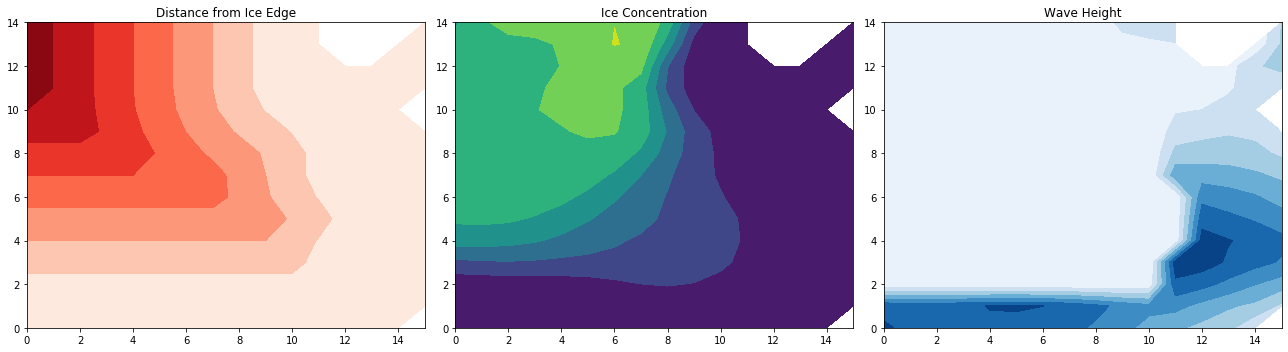

In [172]:
# this is a map of the distance from the ice edge, so it is working
plt.figure(figsize=(18,5))

plt.subplot(131)
plt.contourf(distances,cmap='Reds') # the calculated distances from ice edge
plt.title('Distance from Ice Edge')

plt.subplot(132)
plt.contourf(icefracs)
plt.title('Ice Concentration')

plt.subplot(133)
plt.contourf(waveheights,cmap='Blues')
plt.title('Wave Height')
plt.tight_layout()
plt.show()

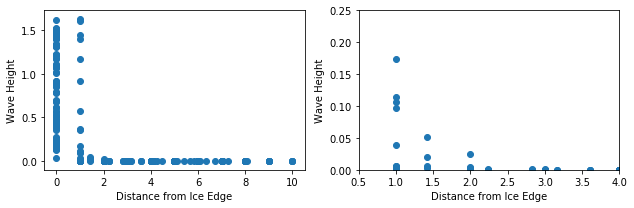

In [28]:
# try to plot the waveheight vs. distance from ice edge
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.scatter(distances.reshape(distances.size),waveheights.values.reshape(waveheights.size))
plt.xlabel('Distance from Ice Edge')
plt.ylabel('Wave Height')

plt.subplot(122)
plt.scatter(distances.reshape(distances.size),waveheights.values.reshape(waveheights.size))
plt.ylim(0,0.25)
plt.xlim(0.5,4)
plt.xlabel('Distance from Ice Edge')
plt.ylabel('Wave Height')

plt.tight_layout()
plt.show()

## Try to expand to full Northern Hemisphere

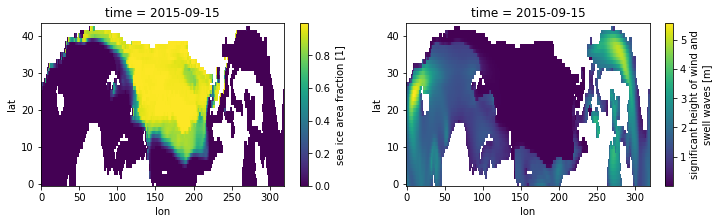

In [173]:
# march
# icefracs = mwds.ice[:,305:].sel(time='2015-03-15')[0] 
# waveheights = mwds.hs[:,305:].sel(time='2015-03-15')[0]

# september
icefracs = mwds.ice[:,340:].sel(time='2015-09-15')[0]
waveheights = mwds.hs[:,340:].sel(time='2015-09-15')[0]
wavefreq = mwds.fp[:,340:].sel(time='2015-09-15')[0]

plt.figure(figsize=(12,3))
plt.subplot(121)
icefracs.plot()

plt.subplot(122)
waveheights.plot()

In [175]:
# turn icefracs to numpy array
icefracsnp = icefracs.values
icefracsnp.shape

# create array to hold the distances
distances = icefracsnp.copy() # same size array as the evaluated data
distances -= distances # make zeros or nan # this will set default to zero or nan where there is no ice
print(distances.shape)

# get all open water locations
locations_openw = np.where(icefracsnp<0.001)

(44, 320)


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


In [176]:
%%time
# this works but slowly # DO NOT CHANGE
# iterate through every cell, store the minimum distance in array that matches the icefrac size
for i,refloc in enumerate(np.transpose(np.where(icefracsnp>-1))): # note this np.where is a dummy just to get index
    # get the minimum distance for every cell
    distances[refloc[0]][refloc[1]] = np.min([np.linalg.norm(loc-refloc) for loc in np.transpose(locations_openw)])

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 5min 46s, sys: 23.9 ms, total: 5min 46s
Wall time: 5min 46s


In [177]:
print(len(np.transpose(np.where(icefracsnp>0.001))))
print(len(np.transpose(np.where(icefracsnp>-1))))

3467
9188


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [63]:
# try to limit what I enumerate through

for i,refloc in enumerate(np.transpose(np.where(icefracsnp>0.001))):
    print(i,refloc)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


0 [  2 143]
1 [  2 144]
2 [  3 143]
3 [  3 144]
4 [  4 144]
5 [  5 144]
6 [  5 186]
7 [  5 187]
8 [  5 188]
9 [  5 189]
10 [  5 190]
11 [  5 191]
12 [  5 192]
13 [  6 143]
14 [  6 144]
15 [  6 181]
16 [  6 182]
17 [  6 183]
18 [  6 184]
19 [  6 185]
20 [  6 186]
21 [  6 187]
22 [  6 188]
23 [  6 189]
24 [  6 190]
25 [  6 191]
26 [  6 192]
27 [  6 193]
28 [  6 194]
29 [  7 140]
30 [  7 141]
31 [  7 142]
32 [  7 143]
33 [  7 144]
34 [  7 177]
35 [  7 178]
36 [  7 179]
37 [  7 180]
38 [  7 181]
39 [  7 182]
40 [  7 183]
41 [  7 184]
42 [  7 185]
43 [  7 186]
44 [  7 187]
45 [  7 188]
46 [  7 189]
47 [  7 190]
48 [  7 191]
49 [  7 192]
50 [  7 193]
51 [  7 194]
52 [  7 195]
53 [  7 196]
54 [  7 197]
55 [  7 198]
56 [  7 207]
57 [  7 208]
58 [  7 209]
59 [  7 210]
60 [  7 211]
61 [  7 212]
62 [  7 213]
63 [  7 214]
64 [  7 215]
65 [  7 216]
66 [  7 217]
67 [  7 218]
68 [  7 219]
69 [  7 220]
70 [  8 140]
71 [  8 141]
72 [  8 142]
73 [  8 143]
74 [  8 144]
75 [  8 173]
76 [  8 174]
77 [  8 1

2012 [ 27 190]
2013 [ 27 191]
2014 [ 27 192]
2015 [ 27 193]
2016 [ 27 194]
2017 [ 27 195]
2018 [ 27 196]
2019 [ 27 197]
2020 [ 27 198]
2021 [ 27 199]
2022 [ 27 200]
2023 [ 27 201]
2024 [ 27 202]
2025 [ 27 203]
2026 [ 27 204]
2027 [ 27 205]
2028 [ 27 206]
2029 [ 27 207]
2030 [ 27 208]
2031 [ 27 209]
2032 [ 27 210]
2033 [ 27 211]
2034 [ 27 212]
2035 [ 27 213]
2036 [ 27 214]
2037 [ 27 215]
2038 [ 27 216]
2039 [ 27 217]
2040 [ 27 218]
2041 [ 27 219]
2042 [ 27 220]
2043 [ 27 221]
2044 [ 27 229]
2045 [ 27 230]
2046 [ 27 231]
2047 [ 27 232]
2048 [ 27 233]
2049 [ 27 241]
2050 [28  6]
2051 [28  7]
2052 [28  8]
2053 [28 98]
2054 [ 28 103]
2055 [ 28 104]
2056 [ 28 105]
2057 [ 28 106]
2058 [ 28 107]
2059 [ 28 108]
2060 [ 28 109]
2061 [ 28 110]
2062 [ 28 111]
2063 [ 28 112]
2064 [ 28 113]
2065 [ 28 114]
2066 [ 28 115]
2067 [ 28 116]
2068 [ 28 117]
2069 [ 28 118]
2070 [ 28 119]
2071 [ 28 120]
2072 [ 28 121]
2073 [ 28 122]
2074 [ 28 123]
2075 [ 28 124]
2076 [ 28 125]
2077 [ 28 126]
2078 [ 28 127]
207

In [178]:
%%time
# iterate through cells with ice
icecells = np.transpose(np.where(icefracsnp>0.001))
             
# store the minimum distance in array that matches the icefrac size
for i,refloc in enumerate(icecells):

    # if icefrac of refloc is < 0.001 then get zero; elseif nan get nan; else do the calculation of min dist
    ## the above 'if' statement is actually accomplished in initializing the distances array

    # get the minimum distance to open water at each cell with ice
    distances[refloc[0]][refloc[1]] = np.min([np.linalg.norm(loc-refloc) for loc in np.transpose(locations_openw)])

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


CPU times: user 2min 9s, sys: 19.7 ms, total: 2min 9s
Wall time: 2min 9s


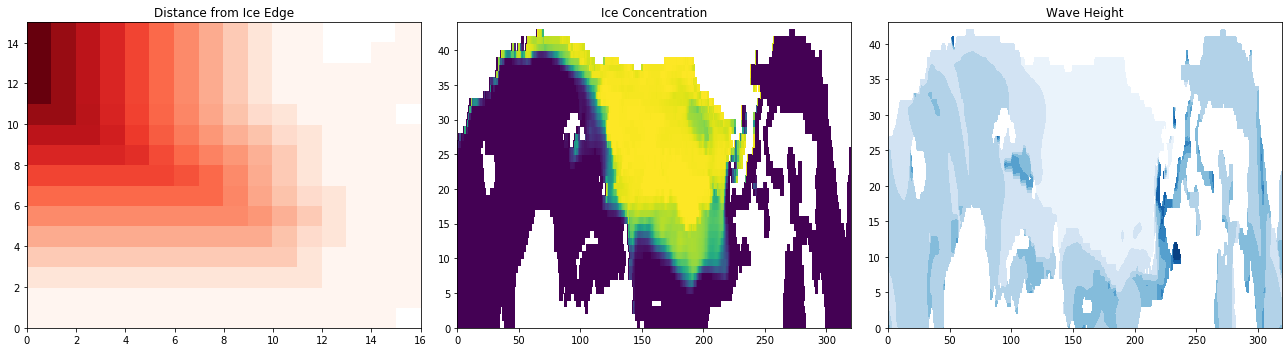

In [174]:
# this is a map of the distance from the ice edge, so it is working
plt.figure(figsize=(18,5))

plt.subplot(131)
plt.pcolormesh(distances,cmap='Reds') # the calculated distances from ice edge
plt.title('Distance from Ice Edge')

plt.subplot(132)
plt.pcolormesh(icefracs)
plt.title('Ice Concentration')

plt.subplot(133)
# plt.contourf(waveheights,cmap='Blues')
plt.contourf(wavefreq,cmap='Blues')
plt.title('Wave Height')
plt.tight_layout()
plt.show()

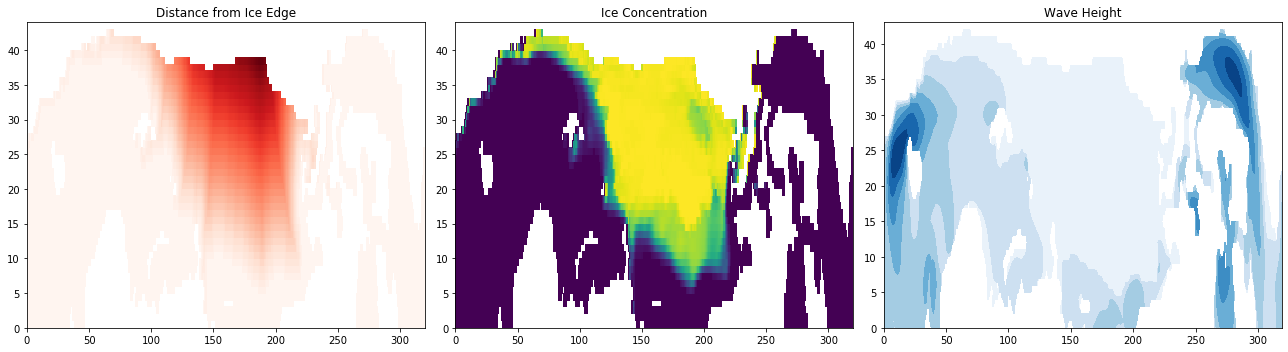

In [67]:
# this is a map of the distance from the ice edge, so it is working
plt.figure(figsize=(18,5))

plt.subplot(131)
plt.pcolormesh(distances,cmap='Reds') # the calculated distances from ice edge
plt.title('Distance from Ice Edge')

plt.subplot(132)
plt.pcolormesh(icefracs)
plt.title('Ice Concentration')

plt.subplot(133)
plt.contourf(waveheights,cmap='Blues')
plt.title('Wave Height')
plt.tight_layout()
plt.show()

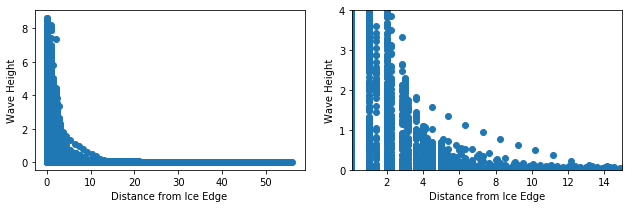

In [171]:
# try to plot the waveheight vs. distance from ice edge
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.scatter(distances.reshape(distances.size),waveheights.values.reshape(waveheights.size))
plt.xlabel('Distance from Ice Edge')
plt.ylabel('Wave Height')

plt.subplot(122)
plt.scatter(distances.reshape(distances.size),waveheights.values.reshape(waveheights.size))
plt.ylim(0,4)
plt.xlim(0.1,15)
plt.xlabel('Distance from Ice Edge')
plt.ylabel('Wave Height')

plt.tight_layout()
plt.show()

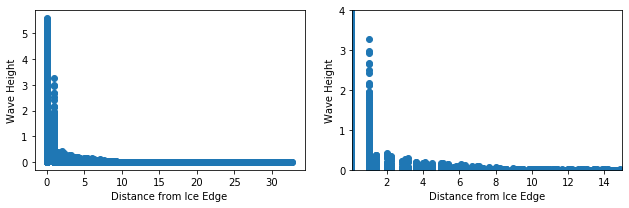

In [68]:
# try to plot the waveheight vs. distance from ice edge
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.scatter(distances.reshape(distances.size),waveheights.values.reshape(waveheights.size))
plt.xlabel('Cell Distance from Ice Edge')
plt.ylabel('Wave Height')

plt.subplot(122)
plt.scatter(distances.reshape(distances.size),waveheights.values.reshape(waveheights.size))
plt.ylim(0,4)
plt.xlim(0.1,15)
plt.xlabel('Cell Distance from Ice Edge')
plt.ylabel('Wave Height')

plt.tight_layout()
plt.show()

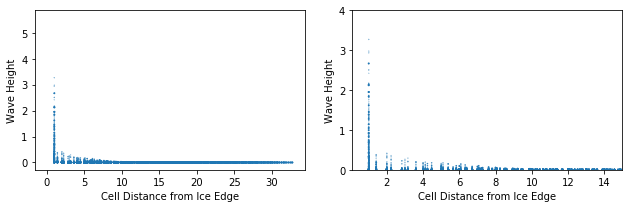

In [69]:
# try to plot the waveheight vs. distance from ice edge
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.scatter(distances.reshape(distances.size),
            waveheights.values.reshape(waveheights.size),
            s=icefracsnp.reshape(icefracs.size))
plt.xlabel('Cell Distance from Ice Edge')
plt.ylabel('Wave Height')

plt.subplot(122)
plt.scatter(distances.reshape(distances.size),waveheights.values.reshape(waveheights.size),
           s=icefracsnp.reshape(icefracs.size))
plt.ylim(0,4)
plt.xlim(0.1,15)
plt.xlabel('Cell Distance from Ice Edge')
plt.ylabel('Wave Height')

plt.tight_layout()
plt.show()

## try to make this into a function

In [29]:
def icedistance(iceconc_input):
    # turn icefracs to numpy array
    icefracsnp = iceconc_input.values

    # create array to hold the distances
    distances = icefracsnp.copy() # same size array as the evaluated data
    distances -= distances # make zeros or nan; we will keep these values for cells that don't need a calc

    # get all open water locations
    locations_openw = np.where(icefracsnp<0.001)
    
    ##### 
    
    # get all cells with ice
    icecells = np.transpose(np.where(icefracsnp>0.001))
             
    # iterate over icecells and store the minimum distance in array that matches the icefrac size
    # note that we are keeping the distance=nan or zero for cells with no ice from initialization of 'distance'
    for i,refloc in enumerate(icecells):

        # get the minimum distance to open water at each cell with ice
        distances[refloc[0]][refloc[1]] = np.min([np.linalg.norm(loc-refloc) for loc in np.transpose(locations_openw)])

    return(distances)

In [30]:
%%time
tempdist = icedistance(icefracs)
tempdist

CPU times: user 84.7 ms, sys: 1.04 ms, total: 85.7 ms
Wall time: 84.9 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


array([[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
               nan],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
         1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
         1.       ,  1.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 2.       ,  2.       ,  2.       ,  2.       ,  2.       ,
         2.       ,  2.       ,  2.       ,  2.       ,  2.       ,
         2.       ,  1.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 3.       ,  3.       ,  3.       ,  3.       ,  3.       ,
         3.       ,  3.       , 

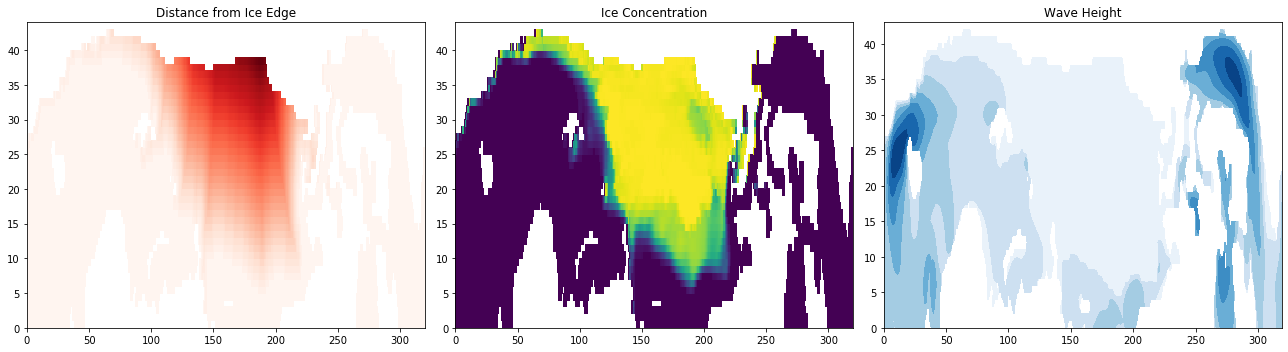

In [74]:
# this is a map of the distance from the ice edge, so it is working
plt.figure(figsize=(18,5))

plt.subplot(131)
plt.pcolormesh(tempdist,cmap='Reds') # the calculated distances from ice edge
plt.title('Distance from Ice Edge')

plt.subplot(132)
plt.pcolormesh(icefracs)
plt.title('Ice Concentration')

plt.subplot(133)
plt.contourf(waveheights,cmap='Blues')
plt.title('Wave Height')
plt.tight_layout()
plt.show()

In [76]:
mwds.ice.sel(time=slice('2014','2016'))

<xarray.DataArray 'ice' (time: 4380, lat: 384, lon: 320)>
[538214400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 ... 2016-12-31T18:00:00
Dimensions without coordinates: lat, lon
Attributes:
    long_name:      sea ice area fraction
    standard_name:  sea_ice_area_fraction
    globwave_name:  sea_ice_area_fraction
    units:          1
    valid_min:      0
    valid_max:      1000

In [79]:
mwds.ice.sel(time=slice('2014-12-30','2014-12-31'))

<xarray.DataArray 'ice' (time: 8, lat: 384, lon: 320)>
[983040 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2014-12-30 ... 2014-12-31T18:00:00
Dimensions without coordinates: lat, lon
Attributes:
    long_name:      sea ice area fraction
    standard_name:  sea_ice_area_fraction
    globwave_name:  sea_ice_area_fraction
    units:          1
    valid_min:      0
    valid_max:      1000

In [96]:
icefrac_series = mwds.ice[:,305:].sel(time=slice('2015-01-01','2015-01-07'))
for i,icef in enumerate(icefrac_series):
#     print(i,icef.values.shape)

SyntaxError: unexpected EOF while parsing (<ipython-input-96-d1343a67d2f8>, line 3)

## Collect distance data for multiple timesteps

In [52]:
# start in 2015 with series of one week length
icefrac_series = mwds.ice[:,305:].sel(time=slice('2015-01-01','2015-01-07'))
wavehs_series = mwdscp.hs[:,305:].sel(time=slice('2015-01-01','2015-01-07'))
icefrac_seriescp = mwdscp.ice[:,305:].sel(time=slice('2015-01-01','2015-01-07'))

# initialize array to hold all of distance values
distance_series = icefrac_series.values.copy()
distance_series -= distance_series
distance_series.shape

(28, 79, 320)

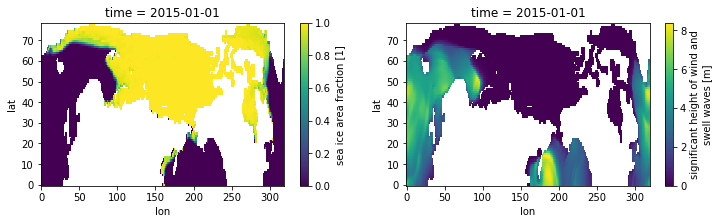

In [48]:
# check data
plt.figure(figsize=(12,3))
plt.subplot(121)
icefrac_series[0].plot()

plt.subplot(122)
wavehs_series[0].plot()

In [105]:
%%time # running from 2015-01-01 to 2015-01-07, i.e. one week
disttest = [icedistance(icefrac) for icefrac in icefrac_series]

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


CPU times: user 1h 56min 31s, sys: 2.55 s, total: 1h 56min 34s
Wall time: 1h 56min 32s


In [52]:
%%time # running from 2015-01-01 to 2015-01-07, i.e. one week
disttest_v03 = [icedistance_v03(conc) for conc in icefrac_series]

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


CPU times: user 4.38 s, sys: 5.77 s, total: 10.1 s
Wall time: 10.1 s


In [11]:
%%timeit # running from 2015-01-01 to 2015-01-07, i.e. one week
disttest_v03 = [icedistance_v03(conc) for conc in icefrac_series]

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


2.18 s ± 88.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit # running from 2015-01-01 to 2015-01-07, i.e. one week
disttest_v04 = [icedistance_v04(conc) for conc in icefrac_seriescp]

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


6.27 s ± 140 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


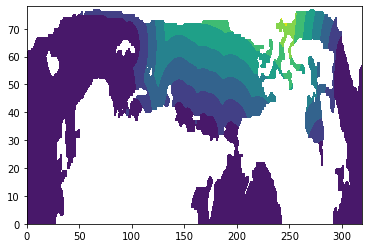

In [56]:
plt.contourf(disttest_v03[-1])

In [15]:
disttest_v04 = [icedistance_v04(conc) for conc in icefrac_seriescp]

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


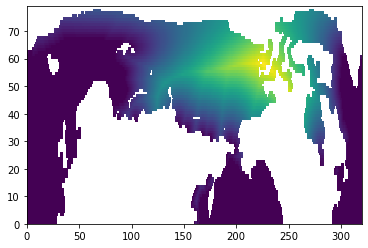

In [18]:
plt.pcolormesh(disttest_v04[-1])

In [106]:
# %%time
# for i,icefrac in enumerate(icefrac_series):
#     print(i,icefrac.shape)
#     distance_series[i] = icedistance(icefrac)
    
# [icedistance(icefrac) for icefrac in icefrac_series]

In [117]:
# reshape to be array of t x lat x lon
distance_series = np.array(disttest)
distance_series.shape

(28, 79, 320)

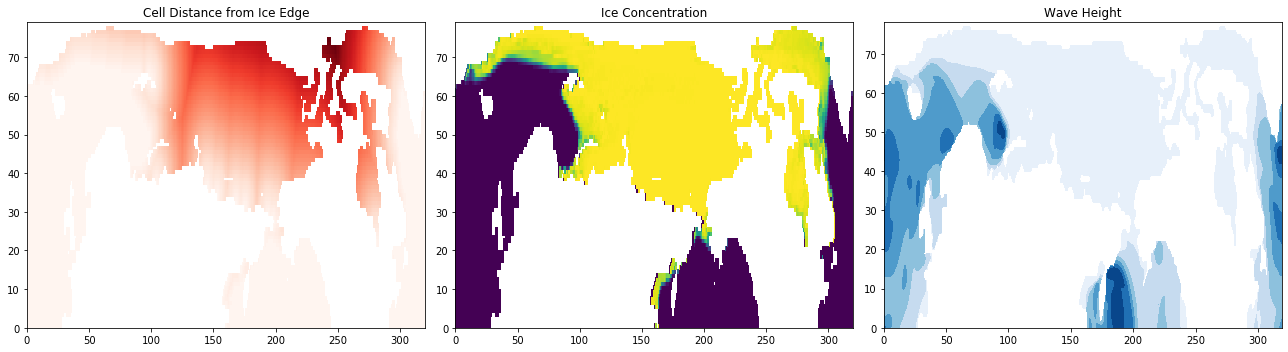

In [125]:
# this is a map of the distance from the ice edge, so it is working
plt.figure(figsize=(18,5))

plt.subplot(131)
plt.pcolormesh(distance_series[0],cmap='Reds') # the calculated distances from ice edge
plt.title('Cell Distance from Ice Edge')

plt.subplot(132)
plt.pcolormesh(icefrac_series[0])
plt.title('Ice Concentration')

plt.subplot(133)
plt.contourf(wavehs_series[0],cmap='Blues')
plt.title('Wave Height')
plt.tight_layout()
plt.show()

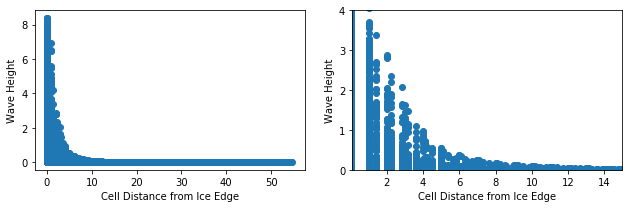

In [127]:
# try to plot the waveheight vs. distance from ice edge
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.scatter(distance_series[0].reshape(distance_series[0].size),wavehs_series[0].values.reshape(wavehs_series[0].size))
plt.xlabel('Cell Distance from Ice Edge')
plt.ylabel('Wave Height')

plt.subplot(122)
plt.scatter(distance_series[0].reshape(distance_series[0].size),wavehs_series[0].values.reshape(wavehs_series[0].size))
plt.ylim(0,4)
plt.xlim(0.1,15)
plt.xlabel('Cell Distance from Ice Edge')
plt.ylabel('Wave Height')

plt.tight_layout()
plt.show()

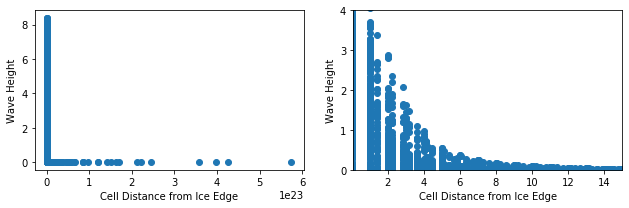

In [129]:
# try to plot the waveheight vs. distance from ice edge
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.scatter(distance_series[0].reshape(distance_series[0].size),wavehs_series[0].values.reshape(wavehs_series[0].size))
plt.xlabel('Cell Distance from Ice Edge')
plt.ylabel('Wave Height')

plt.subplot(122)
plt.scatter(distance_series[0].reshape(distance_series[0].size),wavehs_series[0].values.reshape(wavehs_series[0].size))
plt.ylim(0,4)
plt.xlim(0.1,15)
plt.xlabel('Cell Distance from Ice Edge')
plt.ylabel('Wave Height')

plt.tight_layout()
plt.show()

### Attempt to copy mwds but give it additional coordinates

<xarray.Dataset>
Dimensions:    (lat: 384, lon: 320, time: 24800)
Coordinates:
    longitude  (lat, lon) float32 ...
    latitude   (lat, lon) float32 ...
  * time       (time) datetime64[ns] 2000-01-01 ... 2016-12-31T18:00:00
Dimensions without coordinates: lat, lon
Data variables:
    MAPSTA     (lat, lon) int16 ...
    dpt        (time, lat, lon) float32 ...
    uwnd       (time, lat, lon) float32 ...
    vwnd       (time, lat, lon) float32 ...
    ast        (time, lat, lon) float32 ...
    ice        (time, lat, lon) float32 ...
    hs         (time, lat, lon) float32 ...
    lm         (time, lat, lon) float32 ...
    t02        (time, lat, lon) float32 ...
    t0m1       (time, lat, lon) float32 ...
    t01        (time, lat, lon) float32 ...
    fp         (time, lat, lon) float32 ...
    dir        (time, lat, lon) float32 ...
    spr        (time, lat, lon) float32 ...
    dp         (time, lat, lon) float32 ...
Attributes:
    WAVEWATCH_III_version_number:  5.16
    WAVEWATCH_III_switches:        F90 NOGRB NOPA LRB4 NC4 PR3 UQ FLX0 LN1 ST...
    product_name:                  ww3.20000101.nc
    area:                          POP 1 degree grid (gx1v6b)
    latitude_resolution:           n/a
    longitude_resolution:          n/a
    southernmost_latitude:         -79.22052
    northernmost_latitude:         89.70641
    westernmost_longitude:         1.4731102E-02
    easternmost_longitude:         359.9960
    minimum_altitude:              -12000 m
    maximum_altitude:              9000 m
    altitude_resolution:           n/a
    start_date:                    2000-01-01 00:00:00
    stop_date:                     2000-01-01 18:00:00
    nco_openmp_thread_number:      1
    history:                       Tue Dec 17 13:58:02 2019: ncrename -O -d l...
    NCO:                           netCDF Operators version 4.7.9 (Homepage =...

## With subset of data, attempt to vectorize

In [142]:
# sample time step
icefrac = mwds.ice[:,345:360,209:225].sel(time='2015-09-15')[0]
icefraccp = mwdscp.ice[:,345:360,209:225].sel(time='2015-09-15')[0]
icefracnp = icefrac.values
wavehs = mwds.hs[:,345:360,209:225].sel(time='2015-09-15')[0]
wavefp = mwds.fp[:,345:360,209:225].sel(time='2015-09-15')[0]
icefraccp = mwdscp.ice[:,345:360,209:225].sel(time='2015-09-15')[0]

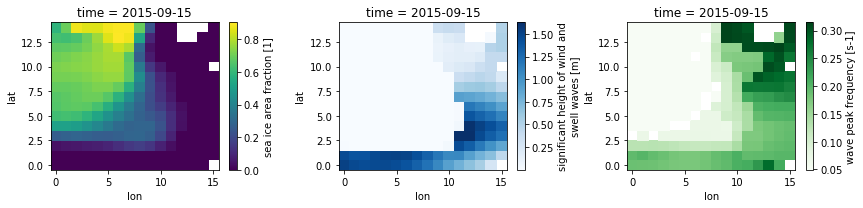

In [11]:
# check data
plt.figure(figsize=(12,3))
plt.subplot(131)
icefrac.plot()

plt.subplot(132)
wavehs.plot(cmap='Blues')

plt.subplot(133)
wavefp.plot(cmap='Greens')
plt.tight_layout()
plt.show()

In [21]:
%%time
distancev3 = icedistance_v03(icefrac)

CPU times: user 2.12 ms, sys: 3 µs, total: 2.12 ms
Wall time: 1.61 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


In [22]:
%%time
distancev2 = icedistance_v02(icefrac)

CPU times: user 32.8 ms, sys: 12.2 ms, total: 45 ms
Wall time: 33 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


In [143]:
%%time
distancev4 = icedistance_v04(icefraccp)

CPU times: user 2.34 ms, sys: 866 µs, total: 3.21 ms
Wall time: 2.77 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


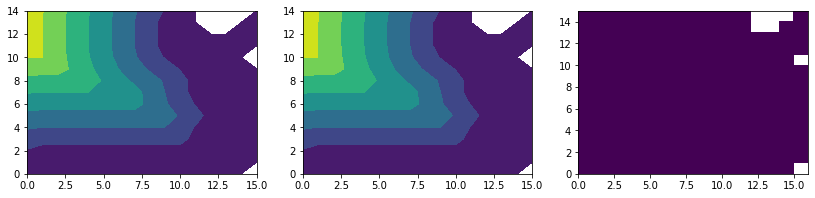

In [23]:
plt.figure(figsize=(14,3))
plt.subplot(131)
plt.contourf(distancev3)

plt.subplot(132)
plt.contourf(distancev2)

plt.subplot(133)
plt.pcolormesh(distancev3-distancev2)

In [21]:
%%time
# create 4 arrays, each represents the offset in coords by 1 unit
latp1 = np.append(locations[:,0]+1,locations[:,1]).reshape(locations.shape,order='F')
latm1 = np.append(locations[:,0]-1,locations[:,1]).reshape(locations.shape,order='F')
lonp1 = np.append(locations[:,0],locations[:,1]+1).reshape(locations.shape,order='F')
lonm1 = np.append(locations[:,0],locations[:,1]-1).reshape(locations.shape,order='F')

# sum the icefracs of 4 neighbor cells at each open water cell
iceneighborsum = np.nansum(np.stack((icefracnp[latp1[:,0],latp1[:,1]],
                    icefracnp[lonm1[:,0],lonm1[:,1]],
                    icefracnp[lonp1[:,0],lonp1[:,1]],
                    icefracnp[latm1[:,0],latm1[:,1]])),axis=0)

# get index of the open water cells with non zero ice neighbor
wateredge = locations[np.where(iceneighborsum>0)]

CPU times: user 0 ns, sys: 979 µs, total: 979 µs
Wall time: 663 µs


In [22]:
# get only locations that don't touch a border
icefracnp_noborder = icefracnp[1:-1,1:-1] # exclude borders
locations = np.transpose(np.where(icefracnp_noborder<0.001))
locations += 1 # adjust indices for the border exclusion
locationsxy = np.transpose(locations)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


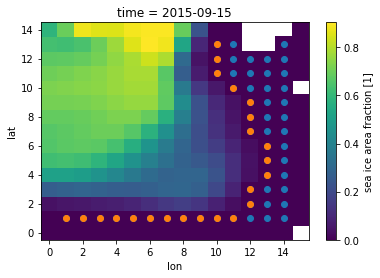

In [23]:
# this is what i am checking against now
icefrac.plot()
plt.scatter(locationsxy[1],locationsxy[0])
plt.scatter(wateredge[:,1],wateredge[:,0])
# plt.scatter(lonm1[:,1],lonm1[:,0])
# plt.scatter(lonp1[:,1],lonp1[:,0])

In [111]:
# let's limit the open water locations to those which neighbor ice
locations.shape
# locations

(52, 2)

In [51]:
print(locations.shape)
np.mean(locations,axis=1)
locations[:,1]

(52, 2)


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 12, 13, 14,
       12, 13, 14, 13, 14, 13, 14, 13, 14, 12, 13, 14, 12, 13, 14, 12, 13,
       14, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11,
       14])

#### Reworking function to vectorize

In [9]:
def icedistance_v03(iceconc_input):
    # turn icefracs to numpy array
    icefracsnp = iceconc_input.values

    # create array to hold the distances
    distances = icefracsnp.copy() # same size array as the evaluated data
    distances -= distances # make zeros or nan; we will keep these values for cells that don't need a calc

    ##### GET OPEN WATER -> WATER/ICE EDGE LOCATIONS #####
    
    # get all open water locations except at edge of domain to avoid computation breaking
    icefracsnp_noborder = icefracsnp[1:-1,1:-1] # exclude borders for open water checking neighbors
    locations_openw = np.transpose(np.where(icefracsnp_noborder<0.001))
    locations_openw += 1 # adjust indices for the border exclusion

    # create 4 arrays, each represents the offset of open water location in coords by 1 unit
    latp1 = np.append(locations_openw[:,0]+1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    latm1 = np.append(locations_openw[:,0]-1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    lonp1 = np.append(locations_openw[:,0],locations_openw[:,1]+1).reshape(locations_openw.shape,order='F')
    lonm1 = np.append(locations_openw[:,0],locations_openw[:,1]-1).reshape(locations_openw.shape,order='F')

    # sum the icefracs of 4 neighbor cells at each open water cell
    iceneighborsum = np.nansum(np.stack((icefracsnp[latp1[:,0],latp1[:,1]],
                                         icefracsnp[lonm1[:,0],lonm1[:,1]],
                                         icefracsnp[lonp1[:,0],lonp1[:,1]],
                                         icefracsnp[latm1[:,0],latm1[:,1]])),axis=0)

    # get index of the open water cells with non-zero ice neighbor # these are values for which we will calc distance
    wateredge = locations_openw[np.where(iceneighborsum>0)]
    
    ##### CALCULATION OF DISTANCES #####
    
    # get all cell locations with ice
    icecells = np.transpose(np.where(icefracsnp>0.001))

    mindist = np.min(np.linalg.norm( # get minimum distance (final) # calc distance to each cell
                                    np.tile(icecells, # duplicates icecell by length of wateredge for linalg.norm op
                                            len(wateredge)).reshape(len(icecells),len(wateredge),2) - 
                                    wateredge,axis=2),axis=1)

    icecellsT = np.transpose(icecells) # transpose for vectorized indexing
    distances[icecellsT[0],icecellsT[1]] = mindist # put mindist into each grid point

    return(distances)

In [10]:
## WIP change 
def icedistance_v04(iceconc_input):
    # turn icefracs to numpy array
    icefracsnp = iceconc_input.values
    lats = iceconc_input.latitude.values
    lons = iceconc_input.longitude.values


    # create array to hold the distances
    distances = icefracsnp.copy() # same size array as the evaluated data
    distances -= distances # make zeros or nan; we will keep these values for cells that don't need a calc

    ##### GET OPEN WATER -> WATER/ICE EDGE LOCATIONS #####
    
    # get all open water locations except at edge of domain to avoid computation breaking
    icefracsnp_noborder = icefracsnp[1:-1,1:-1] # exclude borders for open water checking neighbors
    locations_openw = np.transpose(np.where(icefracsnp_noborder<0.001))
    locations_openw += 1 # adjust indices for the border exclusion

    # create 4 arrays, each represents the offset of open water location in coords by 1 unit
    latp1 = np.append(locations_openw[:,0]+1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    latm1 = np.append(locations_openw[:,0]-1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    lonp1 = np.append(locations_openw[:,0],locations_openw[:,1]+1).reshape(locations_openw.shape,order='F')
    lonm1 = np.append(locations_openw[:,0],locations_openw[:,1]-1).reshape(locations_openw.shape,order='F')

    # sum the icefracs of 4 neighbor cells at each open water cell
    iceneighborsum = np.nansum(np.stack((icefracsnp[latp1[:,0],latp1[:,1]],
                                         icefracsnp[lonm1[:,0],lonm1[:,1]],
                                         icefracsnp[lonp1[:,0],lonp1[:,1]],
                                         icefracsnp[latm1[:,0],latm1[:,1]])),axis=0)

    # get index of the open water cells with non-zero ice neighbor # these are values for which we will calc distance
    wateredge = locations_openw[np.where(iceneighborsum>0)]
    wateredgeT = wateredge.T
    wateredgelatlon = np.array([[lats[wateredgeT[0],wateredgeT[1]]],
                                [lons[wateredgeT[0],wateredgeT[1]]]]).squeeze().T # Nx2 matrix of lat,lon
    
    ##### CALCULATION OF DISTANCES #####
    
    # get all cell locations with ice
    icewhere = np.where(icefracsnp>0.001)
    icecells = np.transpose(icewhere) # index by array position
    icelatlon = np.array([[lats[icewhere]],
                          [lons[icewhere]]]).squeeze().T # Nx2 matrix of lat,lon

    # calculate minimum distance
    mindist = haversine_distances(np.deg2rad(icelatlon),
                                  np.deg2rad(wateredgelatlon)).min(axis=1)*6371000/1000 # x by Radius-earth for km
    
    icecellsT = np.transpose(icecells) # transpose for vectorized indexing
    distances[icecellsT[0],icecellsT[1]] = mindist # put mindist into each grid point
    
#     consider adding something like this and removing the loop? so it outputs xarray
#     dist_series = iceconc_input.copy()
#     dist_series.values = np.array(disttest_v04)


    return(distances)

In [48]:
icelatlon = np.array([[lats[np.where(icefracsnp>0.001)]],[lons[np.where(icefracsnp>0.001)]]]).squeeze().T # Nx2 matrix of lat,lon

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [108]:
wateredgeT = wateredge.T
wateredgelatlon = np.array([[lats[wateredgeT[0],wateredgeT[1]]],[lons[wateredgeT[0],wateredgeT[1]]]]).squeeze().T # Nx2 matrix of lat,lon
wateredgelatlon.shape

(23, 2)

In [113]:
tempdist = haversine_distances(np.deg2rad(icelatlon),np.deg2rad(wateredgelatlon))

In [135]:
# get the minimum value above zero in each row
# tempdist.min(axis=1)

In [125]:
distances_alt = distances.copy()
distances_alt[icecellsT[0],icecellsT[1]] = tempdist.min(axis=1) * 6371000/1000  # multiply by Earth radius to get km
distances_alt

array([[  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
               nan],
       [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ],
       [ 78.57533 ,  66.200775,  66.014824,  65.8258  ,  65.634026,
         65.43685 ,  65.23778 ,  65.0342  ,  64.82878 ,  64.61898 ,
         64.40612 ,  43.136562,   0.      ,   0.      ,   0.      ,
          0.      ],
       [138.90738 , 132.34213 , 131.97192 , 131.59561 , 131.21205 ,
        130.82153 , 130.42473 , 130.02098 , 129.61081 , 125.76869 ,
         83.99417 ,  42.070507,   0.      ,   0.      ,   0.      ,
          0.      ],
       [202.884   , 198.41748 , 197.86589 , 197.30345 , 196.7327  ,
        196.14978 , 195.55858 , 

In [30]:
# turn icefracs to numpy array
icefracsnp = icefraccp.values
# icefracsnp = icefrac.values
lats = icefraccp.latitude.values
lons = icefraccp.longitude.values

# create array to hold the distances
distances = icefracsnp.copy() # same size array as the evaluated data
distances -= distances # make zeros or nan; we will keep these values for cells that don't need a calc

##### GET OPEN WATER -> WATER/ICE EDGE LOCATIONS #####

# get all open water locations except at edge of domain to avoid computation breaking
icefracsnp_noborder = icefracsnp[1:-1,1:-1] # exclude borders for open water checking neighbors
locations_openw = np.transpose(np.where(icefracsnp_noborder<0.001))
locations_openw += 1 # adjust indices for the border exclusion

# create 4 arrays, each represents the offset of open water location in coords by 1 unit
latp1 = np.append(locations_openw[:,0]+1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
latm1 = np.append(locations_openw[:,0]-1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
lonp1 = np.append(locations_openw[:,0],locations_openw[:,1]+1).reshape(locations_openw.shape,order='F')
lonm1 = np.append(locations_openw[:,0],locations_openw[:,1]-1).reshape(locations_openw.shape,order='F')

# sum the icefracs of 4 neighbor cells at each open water cell
iceneighborsum = np.nansum(np.stack((icefracsnp[latp1[:,0],latp1[:,1]],
                    icefracnp[lonm1[:,0],lonm1[:,1]],
                    icefracnp[lonp1[:,0],lonp1[:,1]],
                    icefracnp[latm1[:,0],latm1[:,1]])),axis=0)

# get index of the open water cells with non-zero ice neighbor # these are values for which we will calc distance
wateredge = locations_openw[np.where(iceneighborsum>0)]

##### CALCULATION OF DISTANCES #####

# get all cell locations with ice
icecells = np.transpose(np.where(icefracsnp>0.001))

# mindist is an array of all of the minimum distances corresponding to each icecell
mindist = np.min(np.linalg.norm( # get minimum distance (final) # calc distance to each cell
                                np.tile(icecells, # duplicates icecell by length of wateredge for linalg.norm op
                                        len(wateredge)).reshape(len(icecells),len(wateredge),2) - 
                                wateredge,axis=2),axis=1)

icecellsT = np.transpose(icecells)
distances[icecellsT[0],icecellsT[1]] = mindist

# for i,refloc in enumerate(icecells):
#     distances[refloc[0]][refloc[1]] = np.min([np.linalg.norm(loc-refloc) for loc in wateredge])

# print(mindist.shape, distances.shape, distances)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater


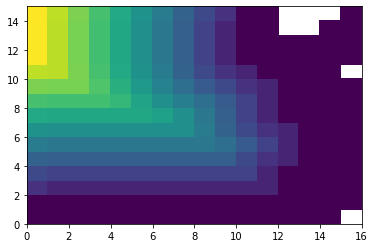

In [12]:
plt.pcolormesh(distances)

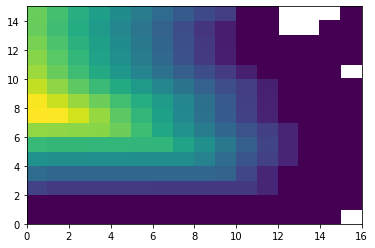

In [126]:
plt.pcolormesh(distances_alt)

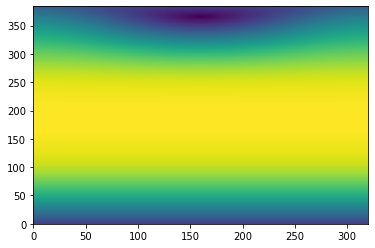

In [133]:
plt.pcolormesh(np.cos(np.deg2rad(mwdscp.latitude)))

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


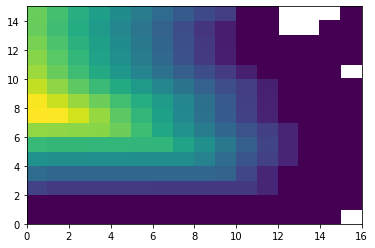

In [137]:
plt.pcolormesh(icedistance_v04(icefraccp))

In [41]:
result = haversine_distances([np.deg2rad([icefraccp[0,0].latitude.values, icefraccp[0,0].longitude.values]),
                    np.deg2rad([icefraccp[0,1].latitude.values, icefraccp[0,1].longitude.values])])
result * 6371000/1000  # multiply by Earth radius to get kilometers

array([[ 0.        , 43.78663719],
       [43.78663719,  0.        ]])

In [ ]:
##

In [19]:
locdist = np.append(np.transpose(icecells),mindist).reshape(150,3,order='F') # creates array with (coord1,coord2,mindist)

In [20]:
test = distances.copy()

In [21]:
np.transpose(locdist)[0]

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,
        9.,  9.,  9.,  9.,  9.,  9.,  9.,  9., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 11., 11., 11., 11., 11., 11., 11.,
       11., 11., 11., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 14., 14., 14.,
       14., 14., 14., 14., 14., 14., 14.])

In [43]:
int(locdist[0][0:1])
locdist[0][0:2]

array([2., 0.])

In [55]:
test[icecells[0,0],icecells[0,1]]
mindist

array([ 1.41421356,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  2.23606798,  2.        ,  2.        ,
        2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
        2.        ,  2.        ,  2.        ,  1.        ,  3.16227766,
        3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  2.23606798,
        1.41421356,  1.        ,  4.12310563,  4.        ,  4.        ,
        4.        ,  4.        ,  4.        ,  4.        ,  4.        ,
        4.        ,  3.60555128,  2.82842712,  2.        ,  1.        ,
        5.09901951,  5.        ,  5.        ,  5.        ,  5.        ,
        5.        ,  5.        ,  5.        ,  4.12310563,  3.16227766,
        2.23606798,  1.41421356,  1.        ,  6.08276253,  6.        ,
        6.        ,  6.        ,  6.        ,  6.        ,  5.65

In [58]:
icecellsT = np.transpose(icecells)
test[np.transpose(icecells)[0],np.transpose(icecells)[1]] = mindist.copy()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


AttributeError: 'tuple' object has no attribute 'shape'

In [39]:
print(icecells[0])
print(wateredge[0])
print(icecells[0]-wateredge[0])
np.linalg.norm(icecells[0]-wateredge[0])

[2 0]
[1 1]
[ 1 -1]


1.4142135623730951

In [88]:
print(icecells.shape)
print(wateredge.shape)
len(icecells)

(150, 2)
(23, 2)


150

In [96]:
icecellsdup = np.tile(icecells,len(wateredge)).reshape(len(icecells),len(wateredge),2)
np.min(
    np.linalg.norm(
        np.tile(icecells,len(wateredge)).reshape(len(icecells),len(wateredge),2) \
        - wateredge,axis=2),
    axis=1)

(150,)

In [89]:
icecellsdup = np.tile(icecells,23).reshape(150,23,2)
icecellsdup = np.tile(icecells,len(wateredge)).reshape(len(icecells),len(wateredge),2)


In [94]:
alldistances = np.linalg.norm(icecellsdup - wateredge,axis=2)
np.min(alldistances,axis=1)
# np.min(
#     np.linalg.norm(icecellsdup - wateredge,axis=2),axis=1)

array([ 1.41421356,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  2.23606798,  2.        ,  2.        ,
        2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
        2.        ,  2.        ,  2.        ,  1.        ,  3.16227766,
        3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  2.23606798,
        1.41421356,  1.        ,  4.12310563,  4.        ,  4.        ,
        4.        ,  4.        ,  4.        ,  4.        ,  4.        ,
        4.        ,  3.60555128,  2.82842712,  2.        ,  1.        ,
        5.09901951,  5.        ,  5.        ,  5.        ,  5.        ,
        5.        ,  5.        ,  5.        ,  4.12310563,  3.16227766,
        2.23606798,  1.41421356,  1.        ,  6.08276253,  6.        ,
        6.        ,  6.        ,  6.        ,  6.        ,  5.65

### Checking with larger subselection

In [42]:
# sample time step
icefrac = mwds.ice[:,305:,:].sel(time='2015-03-15')[0]
icefracnp = icefrac.values
wavehs = mwds.hs[:,305:,:].sel(time='2015-03-15')[0]
wavefp = mwds.fp[:,305:,:].sel(time='2015-03-15')[0]

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


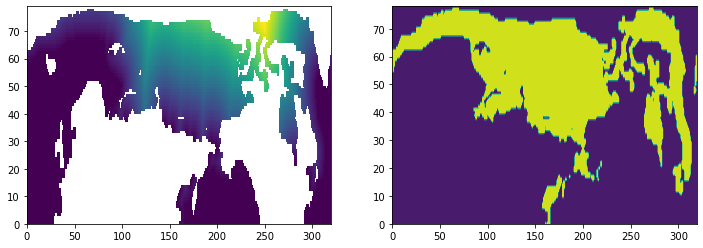

In [46]:
fig = plt.subplots(figsize=(12,4))

plt.subplot(121)
plt.pcolormesh(icedistance_v03(icefrac))

plt.subplot(122)
plt.contourf(icedistance_v03(icefrac)>0)

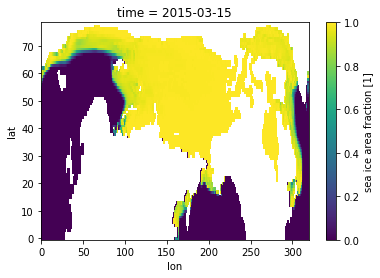

In [45]:
icefrac.plot()

## Convert to distance

In [59]:
mwds.longitude

<xarray.DataArray 'longitude' (lat: 384, lon: 320)>
[122880 values with dtype=float32]
Dimensions without coordinates: lat, lon
Attributes:
    units:          degree_east
    long_name:      longitude
    standard_name:  longitude
    valid_min:      -180.0
    valid_max:      360.0
    axis:           X

In [15]:
(np.pi/180)*np.array([25, 25])

array([0.43633231, 0.43633231])

In [19]:
%%time
haversine_distances([(np.pi/180)*np.array([25, -25]), (np.pi/180)*np.array([-10, 10])])*6371000/1000

CPU times: user 137 µs, sys: 0 ns, total: 137 µs
Wall time: 115 µs


array([[   0.        , 5434.36265163],
       [5434.36265163,    0.        ]])

## Histogram of waves in sea ice

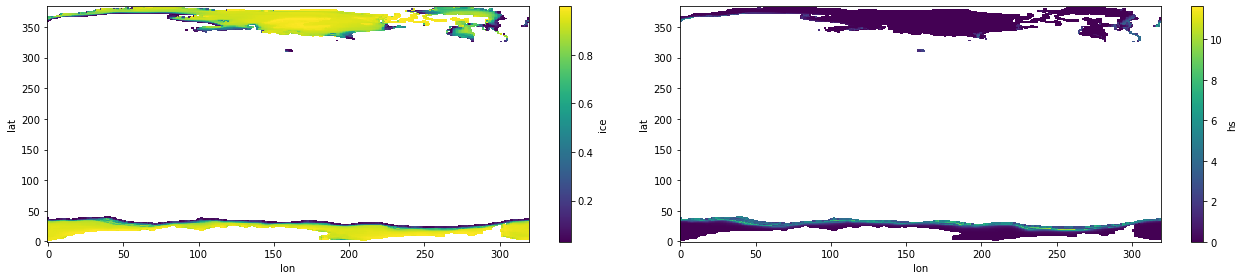

In [54]:
# attempt to select for given time, only cells with ice, average over time
fig = plt.subplots(figsize=(18,4))

# ice concentration
plt.subplot(121)
mwds.sel(time='2015-06').ice.where(mwds.sel(time='2015-06').ice>0).mean(dim='time').plot()

# wave height max
plt.subplot(122)
mwds.sel(time='2015-06').hs.where(mwds.sel(time='2015-06').ice>0).max(dim='time').plot()

plt.tight_layout()
plt.show()

(array([1.320168e+06, 3.543000e+04, 1.364000e+04, 4.691000e+03,
        1.607000e+03, 5.240000e+02, 2.010000e+02, 6.200000e+01,
        2.700000e+01, 2.000000e+00]),
 array([1.3029626e-12, 1.1626508e+00, 2.3253016e+00, 3.4879522e+00,
        4.6506033e+00, 5.8132539e+00, 6.9759045e+00, 8.1385555e+00,
        9.3012066e+00, 1.0463857e+01, 1.1626508e+01], dtype=float32),
 <a list of 10 Patch objects>)

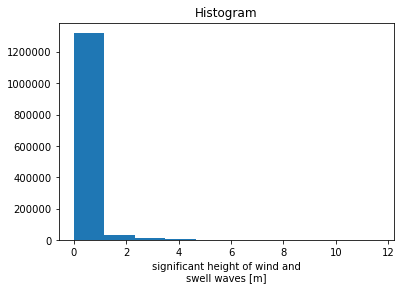

In [57]:
mwds.sel(time='2015-06').hs.where(mwds.sel(time='2015-06').ice>0).plot.hist()

(array([1.4322484e+07, 4.0132300e+05, 1.1369500e+05, 3.3125000e+04,
        9.3020000e+03, 2.7260000e+03, 8.6400000e+02, 2.5500000e+02,
        7.6000000e+01, 2.4000000e+01]),
 array([3.6844516e-13, 1.4799228e+00, 2.9598455e+00, 4.4397683e+00,
        5.9196911e+00, 7.3996139e+00, 8.8795366e+00, 1.0359460e+01,
        1.1839382e+01, 1.3319305e+01, 1.4799228e+01], dtype=float32),
 <a list of 10 Patch objects>)

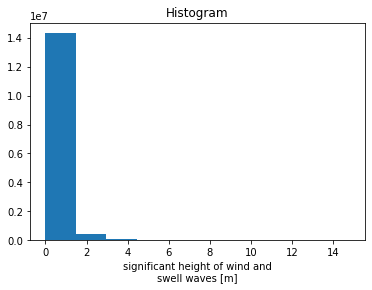

In [58]:
mwds.sel(time='2015').hs.where(mwds.sel(time='2015').ice>0).plot.hist()

(array([1.3526487e+07, 3.4962100e+05, 8.1922000e+04, 2.0321000e+04,
        5.1350000e+03, 1.2680000e+03, 3.3000000e+02, 8.3000000e+01,
        2.1000000e+01, 1.8000000e+01]),
 array([5.9994707e-13, 1.5794994e+00, 3.1589987e+00, 4.7384982e+00,
        6.3179975e+00, 7.8974967e+00, 9.4769964e+00, 1.1056496e+01,
        1.2635995e+01, 1.4215494e+01, 1.5794993e+01], dtype=float32),
 <a list of 10 Patch objects>)

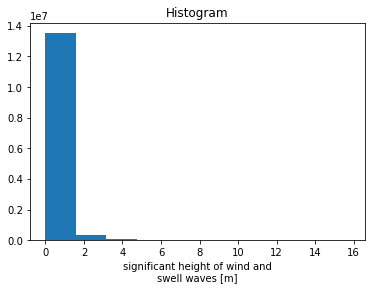

In [59]:
mwds.sel(time='2016').hs.where(mwds.sel(time='2016').ice>0).plot.hist()

### Check out 2018 model data

In [5]:
mwds18

<xarray.Dataset>
Dimensions:       (d2: 2, nc: 5, ni: 320, nj: 384, nkbio: 5, nkfsd: 12, nkice: 8, nksnow: 3, time: 365)
Coordinates:
  * time          (time) object 0086-01-02 00:00:00 ... 0087-01-01 00:00:00
    TLON          (nj, ni) float32 ...
    TLAT          (nj, ni) float32 ...
    ULON          (nj, ni) float32 ...
    ULAT          (nj, ni) float32 ...
    NCAT          (nc) float32 ...
Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkfsd, nkice, nksnow
Data variables:
    time_bounds   (time, d2) object ...
    VGRDi         (nkice) float32 ...
    VGRDs         (nksnow) float32 ...
    VGRDb         (nkbio) float32 ...
    tmask         (nj, ni) float32 ...
    blkmask       (nj, ni) float32 ...
    tarea         (nj, ni) float32 ...
    uarea         (nj, ni) float32 ...
    ANGLE         (nj, ni) float32 ...
    ANGLET        (nj, ni) float32 ...
    concforww_d   (time, nj, ni) float32 ...
    diamforww_d   (time, nj, ni) float32 ...
    thickforww_d  (time, nj, ni) float32 ...
    hi_d          (time, nj, ni) float32 ...
    aice_d        (time, nj, ni) float32 ...
    uvel_d        (time, nj, ni) float32 ...
    vvel_d        (time, nj, ni) float32 ...
    aicen_d       (time, nc, nj, ni) float32 ...
    areal_fsd_d   (time, nkfsd, nj, ni) float32 ...
    dafsdani_d    (time, nkfsd, nj, ni) float32 ...
    dafsdlatm_d   (time, nkfsd, nj, ni) float32 ...
    dafsdmrg_d    (time, nkfsd, nj, ni) float32 ...
    dafsdwave_d   (time, nkfsd, nj, ni) float32 ...
    dafsdlatg_d   (time, nkfsd, nj, ni) float32 ...
Attributes:
    title:             cicefsdww3i
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  day_1
    comment:           All years have exactly 365 days
    comment2:          File written on model date 00860102
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           Fri Apr 17 15:28:44 2020: ncrcat ./cicefsdww3i_output_...
    io_flavor:         io_pio
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....

In [15]:
mwds18season = mwds18.groupby('time.season',squeeze=False).mean()

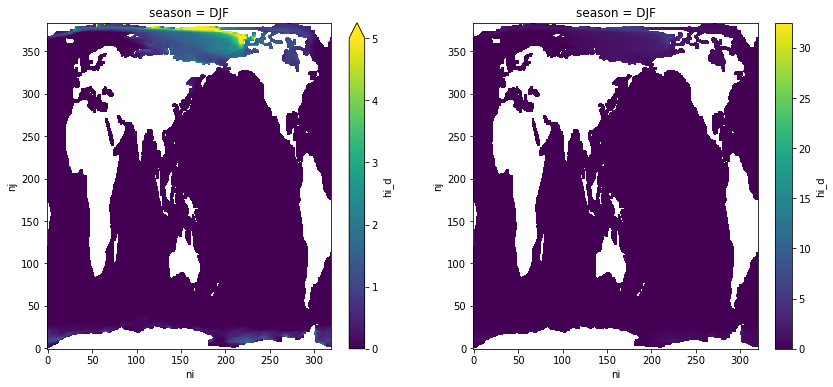

In [25]:
fig = plt.subplots(figsize=(14,6))

plt.subplot(121)
mwds18season.sel(season='DJF').hi_d.plot(vmin=0,vmax=5)

plt.subplot(122)
mwds18season.sel(season='DJF').hi_d.plot()

AttributeError: 'Dataset' object has no attribute 'hs_d'

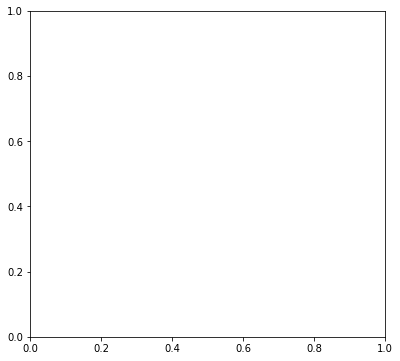

In [27]:
fig = plt.subplots(figsize=(14,6))

plt.subplot(121)
mwds18season.sel(season='DJF').hs_d.plot()

plt.subplot(122)
mwds18season.sel(season='DJF').aice_d.plot()

mwds18

### Look at SODA

In [49]:
sodaC

<xarray.Dataset>
Dimensions:             (freq_wavespectra: 42, time: 4036)
Coordinates:
  * freq_wavespectra    (freq_wavespectra) float64 0.009766 0.02148 ... 0.4902
  * time                (time) datetime64[ns] 2018-10-09 ... 2019-09-11T22:00:00
Data variables:
    wavespectra_energy  (time, freq_wavespectra) float64 ...
    wavespectra_a1      (time, freq_wavespectra) float64 ...
    wavespectra_b1      (time, freq_wavespectra) float64 ...
    wavespectra_a2      (time, freq_wavespectra) float64 ...
    wavespectra_b2      (time, freq_wavespectra) float64 ...
    wavespectra_check   (time, freq_wavespectra) float64 ...
    lat                 (time) float64 ...
    lon                 (time) float64 ...
    sigwaveheight       (time) float64 ...
    peakwaveperiod      (time) float64 ...
    peakwavedirT        (time) float64 ...
Attributes:
    description:        sigWaves
    data:               SODA cruise, Sam Brenner, APL
    netcdf_created_by:  Lettie Roach, 2020, UW

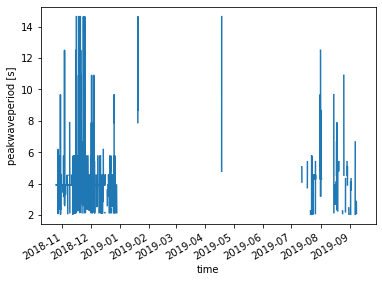

In [50]:
sodaC.peakwaveperiod.plot()

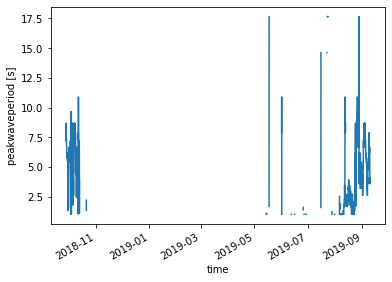

In [52]:
sodaB.peakwaveperiod.plot()

In [51]:
bds18

<xarray.Dataset>
Dimensions:         (freq: 42, time: 2058)
Coordinates:
  * time            (time) datetime64[ns] 2018-07-01T00:31:01.000004 ... 2018-09-24T17:31:00.999998
  * freq            (freq) float64 0.009766 0.02148 0.0332 ... 0.4785 0.4902
Data variables:
    lat             (time) int64 ...
    lon             (time) int64 ...
    icethickness    (time) float64 ...
    sigwaveheight   (time) float64 ...
    peakwaveperiod  (time) float64 ...
    peakwavedirT    (time) float64 ...
    energy          (time, freq) float64 ...
    a1              (time, freq) float64 ...
    b1              (time, freq) float64 ...
    a2              (time, freq) float64 ...
    b2              (time, freq) float64 ...
    check           (time, freq) float64 ...
Attributes:
    description:   AWAC
    processed by:  Jim Thomson, APL

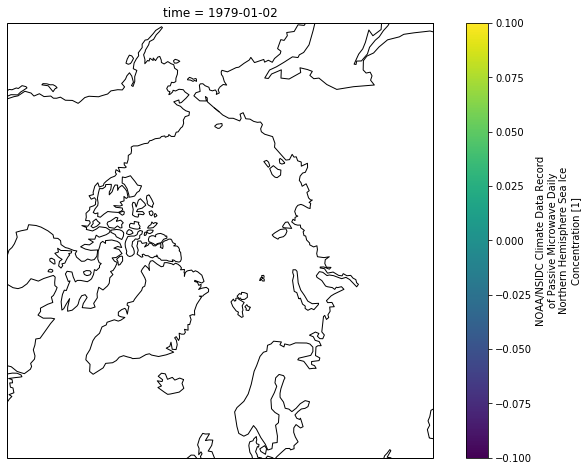

In [18]:
fig = plt.figure(figsize=(12,8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
boot.seaice_conc_cdr[0,:,:].plot.pcolormesh('TLON', 'TLAT', ax=axs, transform=ccrs.PlateCarree())

In [11]:
mwds18.aice_d[0,:,:]

<xarray.DataArray 'aice_d' (nj: 384, ni: 320)>
[122880 values with dtype=float32]
Coordinates:
    time     object 0086-01-02 00:00:00
    TLON     (nj, ni) float32 ...
    TLAT     (nj, ni) float32 ...
    ULON     (nj, ni) float32 ...
    ULAT     (nj, ni) float32 ...
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [20]:
boot.seaice_conc_cdr[0,:,:]

<xarray.DataArray 'seaice_conc_cdr' (nj: 384, ni: 320)>
[122880 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 1979-01-02
    TLON     (nj, ni) float32 ...
    TLAT     (nj, ni) float32 ...
Dimensions without coordinates: nj, ni
Attributes:
    standard_name:        sea_ice_area_fraction
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    units:                1
    flag_values:          [-5 -4 -3 -2 -1]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    reference:            http://nsidc.org/api/metadata?id=g02202
    ancillary_variables:  stdev_of_seaice_conc_cdr qa_of_seaice_conc_cdr

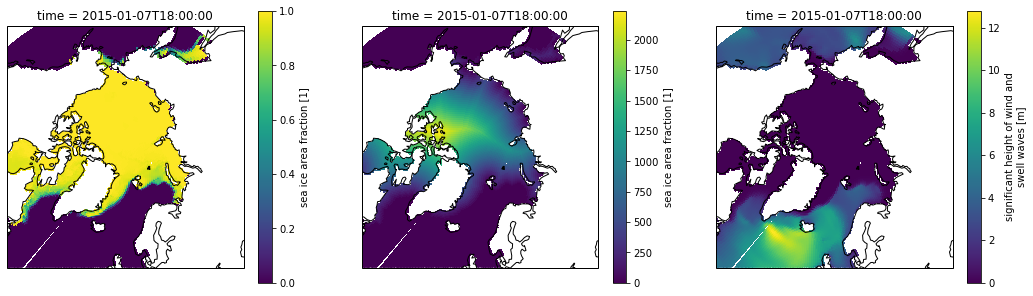

<Figure size 432x288 with 0 Axes>

In [54]:
# aice NH
fig = plt.figure(figsize=(18,5))

# aice mwds
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
icefrac_seriescp.isel(time=-1).plot.pcolormesh('longitude', 'latitude', ax=ax1, transform=ccrs.PlateCarree())

# distance
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
dist_series.isel(time=-1).plot.pcolormesh('longitude', 'latitude', ax=ax2, transform=ccrs.PlateCarree())

# wave height
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
wavehs_series.isel(time=-1).plot.pcolormesh('longitude', 'latitude', ax=ax3, transform=ccrs.PlateCarree())

plt.show()
plt.tight_layout()

In [20]:
icefrac_seriescp

<xarray.DataArray 'ice' (time: 28, lat: 79, lon: 320)>
[707840 values with dtype=float32]
Coordinates:
    longitude  (lat, lon) float32 ...
    latitude   (lat, lon) float32 ...
  * time       (time) datetime64[ns] 2015-01-01 ... 2015-01-07T18:00:00
Dimensions without coordinates: lat, lon
Attributes:
    long_name:      sea ice area fraction
    standard_name:  sea_ice_area_fraction
    globwave_name:  sea_ice_area_fraction
    units:          1
    valid_min:      0
    valid_max:      1000

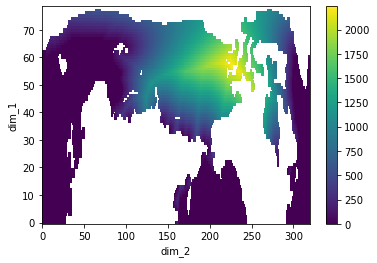

In [27]:
xr.DataArray(disttest_v04)[-1,:,:].plot()

In [44]:
dist_series = icefrac_seriescp.copy()
dist_series.values = np.array(disttest_v04)
dist_series#[-1].plot()

<xarray.DataArray 'ice' (time: 28, lat: 79, lon: 320)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    longitude  (lat, lon) float32 320.54752 321.64255 ... 319.35068 319.7835
    latitude   (lat, lon) float32 41.23691 41.238792 ... 72.18933 72.185974
  * time       (time) datetime64[ns] 2015-01-01 ... 2015-01-07T18:00:00
Dimensions without coordinates: lat, lon
Attributes:
    long_name:      sea ice area fraction
    standard_name:  sea_ice_area_fraction
    globwave_name:  sea_ice_area_fraction
    units:          1
    valid_min:      0
    valid_max:      1000

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.

In [ ]:
d